# "Digital Stress Test (DST)" - Online Study Evaluation

## Introduction:

In this notebook we will evaluate the results of the online study applying the DST.
The DST has been developed as a new **digital paradigm for the induction and analysis of acute stress responses**. 


In [200]:
# import libs

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path
from os import walk
from os import path
import numpy as np
from numpy import mean, std
from pandas.io.json import json_normalize
import scipy
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.weightstats as smws
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict


In [201]:
path = os.getcwd()
print("Current Directory", path)
data_path = os.path.abspath(os.path.join(path, os.pardir)) + "/data"
data_path = "/data/dst_21_hpi_behav_nt_online/raw"
data_path

Current Directory /home/mnorden/projects/dst_21_hpi_behav_nt_online


'/data/dst_21_hpi_behav_nt_online/raw'

# Data preparation

In [202]:
# first step is to download the result files using the GUI provided by JATOS 

# define path of where you stored the jatos results (after unfolding the zip) relative to this jupyter notebook
# in this notebook we only filter for date, so it is important to download the correct files in jatos: 
# we have to choose the results from: "randomized_study" and "General Multiple Worker" as the study is linked 
# to this address

result_path_files = data_path + "/jatos_result_files_25-02-2021"
result_path_meta = data_path + "/jatos_meta_data_25-02-2021" + ".csv"

# for later analysis, we load the downloaded SoSci-Data:

sosci_data_path = data_path + '/SoSci_Final_date-filtered.csv'
sosci_values_path = data_path +'/SoSci_values_DST_2021-01-25_10-21.csv'

# 1: Memory for objects and startle responsivity in the immediate aftermath of exposure to the Trier Social Stress Test
# 2: The role of eye fixation in memory enhancement under stress – An eye tracking study 
# 3: Enhanced Startle Responsivity 24 Hours After Acute Stress Exposure
# 4: Enhanced emotional empathy after psychosocial stress in young healthy men

TSST_path1 = data_path + '/TSST_studies/HertenOSII_MN.sav'
TSST_path2 = data_path + '/TSST_studies/HertenEyeTracking_MN.sav' 
TSST_path3 = data_path + '/TSST_studies/HertenStartle1_MN.sav'
TSST_path4 = data_path + '/TSST_studies/WolfEmpathyStress.sav'
# define date for filtering the results, i.e. all results which are not in the chosen filter period
# will be filtered out

filter_date_begin = "2021/02/10 18:00:00"
filter_date_end = "2021/02/24 18:00:00"

# interesting columns for easier choosing and displaying important data in big dataframes

interesting_columns = ["Subject ID", "Start Time", "Condition",
                       "study_cancellation","age", "gender",
                       "MathTask_time", "math_logging_end_time", 
                       "SpeechTask_time", "VAS_pre_mean", "VAS_intermediate_mean", 
                       "VAS_post_mean", "VAS_mean_post_pre", "VAS_mean_post_intermediate", 
                       "VAS_mean_intermediate_pre",
                       "PANAS_POS_pre", "PANAS_NEG_pre", 
                       "PANAS_POS_post", "PANAS_NEG_post",
                       "PANAS_POS_post_pre", "PANAS_NEG_post_pre",
                       "questions_total", "percentage_end", "user_inputs_total",
                       "Speaking Percentage Total", "Math Participation", "Total App Time"]

# queries for statistical analysis, i.e. group comparisons

queries = ["age", "VAS_mean_post_pre", "VAS_mean_post_intermediate", "VAS_mean_intermediate_pre", 
           "VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean", "PANAS_POS_pre", "PANAS_POS_post", 
           "PANAS_NEG_pre", "PANAS_NEG_post", "PANAS_POS_post_pre", "PANAS_NEG_post_pre",
           "percentage_end", "user_inputs_total", "Speaking Percentage Total", "Math Participation", 
           "PSS4 Sum", "RS_sum_german", "PANAS_VAS_post_pre", 
           "VAS_stress_post_pre", "VAS_frustrated_post_pre", "VAS_ashamed_post_pre", "VAS_overstrained_post_pre"]




In [203]:
# import and prepare SoSci-Data
sosci_data_df = pd.read_csv(sosci_data_path, delimiter = ';', encoding = 'latin1')
sosci_values_df = pd.read_csv(sosci_values_path, delimiter = ';', encoding = 'latin1')
# store abbreviated and true label column names for later use
# downloading the results in SoSci it is necessary to decide for the "first row displays translated labels" option
label_cols = sosci_data_df.iloc[0].values.tolist()
label_cols[-1] = "Maluspunkte 2"
analysis_cols = sosci_data_df.columns.tolist()

# delete label-row

sosci_data_df_analysis_raw = sosci_data_df.drop(0)
sosci_data_df_analysis_raw = sosci_data_df_analysis_raw.reset_index(drop = True)

# converting VAS and likert - scale columns to integers for mean calculation
sosci_data_df_analysis_raw.replace({"trifft nicht zu": (-2), "trifft eher nicht zu": (-1),"teils-teils":0, "trifft eher zu":1, "trifft zu":2}, inplace = True)
sosci_data_df_analysis_raw.replace({"gar nicht stressig": 0, "sehr stressig": 100}, inplace = True)
sosci_data_df_analysis_raw.replace({"Ich stimme völlig zu": 7, "Ich stimme nicht zu": 1}, inplace = True)

# convert PSS-4 values to int for score calculation:
helper_df = sosci_data_df_analysis_raw[["P205", "P213"]]
helper_df.replace({"nie":0,"fast nie":1,"manch-mal":2, "ziemlich oft":3, "sehr oft":4}, inplace = True)
sosci_data_df_analysis_raw[["P205", "P213"]] = helper_df

helper_df = sosci_data_df_analysis_raw[["P207", "P208"]]
helper_df.replace({"nie":4,"fast nie":3,"manch-mal":2, "ziemlich oft":1, "sehr oft":0} , inplace = True)
sosci_data_df_analysis_raw[["P207", "P208"]] = helper_df
    # calculate sum of values, higher values indicate higher stress
sosci_data_df_analysis_raw["PSS4 Sum"] = sosci_data_df_analysis_raw["P207"] + sosci_data_df_analysis_raw["P208"] + sosci_data_df_analysis_raw["P205"] + sosci_data_df_analysis_raw["P213"]


label_cols.append("PSS4 Sum")
analysis_cols.append("PSS4 Sum")

sosci_data_df_analysis_raw.reset_index(drop=True)

# in order to translate the variables in the columns, we use the SoSci-Survey provided values file and replace the translations
sosci_data_df_analysis_labelled = sosci_data_df_analysis_raw.copy()

# translating column values for each category with the according label as in Sosci-Values-File
 
dict_list = []
for var in sosci_values_df["VAR"].unique():
    rename_dict = sosci_values_df[sosci_values_df["VAR"] == var].set_index('RESPONSE').to_dict()['MEANING']
    dict_list.append(rename_dict)
    
    try:
        sosci_data_df_analysis_labelled[var] = sosci_data_df_analysis_raw[var].astype(float).replace(rename_dict)
    except:
        sosci_data_df_analysis_labelled[var] = sosci_data_df_analysis_raw[var]

# calculate Resilience-Sum
sosci_data_df_analysis_raw["RS_sum_german"] = 0
for col in sosci_data_df_analysis_raw.columns:
    if col.startswith("RS0") and not col.startswith("RS01_14") :
        sosci_data_df_analysis_raw[col].fillna(-1000.0, inplace = True)
        sosci_data_df_analysis_raw["RS_sum_german"] = sosci_data_df_analysis_raw["RS_sum_german"] + sosci_data_df_analysis_raw[col].astype(float)

sosci_data_df_analysis_raw["RS_sum_german"] = np.where(sosci_data_df_analysis_raw["RS_sum_german"] < 0, np.nan, sosci_data_df_analysis_raw["RS_sum_german"])


sosci_data_df_analysis_raw["RS_sum_english"] = 0
for col in sosci_data_df_analysis_raw.columns:
    if col.startswith("RS0"):
        sosci_data_df_analysis_raw[col].fillna(-1000.0, inplace = True)
        sosci_data_df_analysis_raw["RS_sum_english"] = sosci_data_df_analysis_raw["RS_sum_english"] + sosci_data_df_analysis_raw[col].astype(float)

sosci_data_df_analysis_raw["RS_sum_english"] = np.where(sosci_data_df_analysis_raw["RS_sum_english"] < 0, np.nan, sosci_data_df_analysis_raw["RS_sum_english"])

label_cols.append("RS_sum_german")
label_cols.append("RS_sum_english")
analysis_cols.append("RS_sum_german")
analysis_cols.append("RS_sum_english")

#sosci_data_df_analysis_raw.to_csv(data_path+r"/SoSci-Survey/sosci_prepped.csv")
sosci_prepped = sosci_data_df_analysis_raw
sosci_labels = pd.DataFrame(label_cols)
#sosci_labels.to_csv(data_path+r"/SoSci-Survey/'sosci_labels.csv')
                    
sosci_labels = label_cols
sosci_analysis_cols = sosci_prepped.columns.tolist()

/tmp/ipykernel_20712/3714459318.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helper_df.replace({"nie":0,"fast nie":1,"manch-mal":2, "ziemlich oft":3, "sehr oft":4}, inplace = True)
/tmp/ipykernel_20712/3714459318.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helper_df.replace({"nie":4,"fast nie":3,"manch-mal":2, "ziemlich oft":1, "sehr oft":0} , inplace = True)


In [204]:
# inspect uploaded files in Jatos and compare with meta data of Jatos:

files = []
for (dirpath, dirnames, filenames) in walk(result_path_files):
    files.extend(filenames)

print("Anzahl der Files im Result Ordner:", len(files))


meta_jatos_df = pd.read_csv(result_path_meta, delimiter=',', encoding="utf-8")

# renaming columns of Jatos meta data because of encoding
cols = ['Subject ID', 'Start Time', 'Last Seen', 'Duration', 'Batch',
       'Worker ID', 'Worker Type', 'MTurk Worker ID (Confirmation Code)',
       'State', 'Message']
meta_jatos_df.columns = cols
# filtering out useless columns
meta_jatos_df = meta_jatos_df.loc[:,"Subject ID":"Duration"]


print("Anzahl der Zeilen in JATOS-Meta-Daten insgesamt (vor filtern nach Datum):", len(meta_jatos_df))



# store result file paths in list for later loading

file_paths = []
for (dirpath, dirnames, filenames) in walk(result_path_files):
    file_paths.extend(os.path.join(dirpath, filename) for filename in filenames) 

# load mathTask files and transform to pd.dataframe, then concatenate all results
# count meta-files, count speech-files

math_df_list = []
speech_df_list = []
meta_files = 0
for path in file_paths:
    if path.count("mathTask.json")>0 and ".swp" not in path:
        file = open(path, 'r')
        math_df = pd.read_json(file)
        math_df_list.append(math_df)

    if path.count("speech")>0 and ".swp" not in path:
        file = open(path, 'r')
        speech_df = pd.read_json(file)
        speech_df_list.append(speech_df)
        
    if path.count("meta")>0 and ".swp" not in path:
        meta_files += 1
        
        
        


print("Anzahl der Meta-Result-Files im Result Ordner:", meta_files)
print("Anzahl der Math-Result-Files im Result Ordner:", len(math_df_list))
print("Anzahl der Speech-Result-Files im Result Ordner:", len(speech_df_list))
meta_jatos_df.describe()    

Anzahl der Files im Result Ordner: 8471
Anzahl der Zeilen in JATOS-Meta-Daten insgesamt (vor filtern nach Datum): 6725
Anzahl der Meta-Result-Files im Result Ordner: 2155
Anzahl der Math-Result-Files im Result Ordner: 2156
Anzahl der Speech-Result-Files im Result Ordner: 2157


Subject ID
count  6725.000000
mean   5190.099033
std    2066.236500
min    1364.000000
25%    3441.000000
50%    5275.000000
75%    6958.000000
max    8706.000000

As we can see here, there are more data in the JATOS meta data than files uploaded. As a result file is only uploaded after beginning the study, there have been a lot of landing page visits, possibly automated link clicks.

In [205]:
# filtering for date, later join with files-df to filter the files based on the JATOS meta data (same Subject ID)
meta_jatos_df = meta_jatos_df[meta_jatos_df["Start Time"] >= filter_date_begin]
if filter_date_end > filter_date_begin:
    meta_jatos_df = meta_jatos_df[meta_jatos_df["Start Time"] < filter_date_end]

print("Anzahl der Zeilen = Ergebnisse in JATOS-Meta-Daten insgesamt nach Filtern für Datum:", len(meta_jatos_df))
meta_jatos_df.describe()



Anzahl der Zeilen = Ergebnisse in JATOS-Meta-Daten insgesamt nach Filtern für Datum: 3713


Subject ID
count  3713.000000
mean   6766.339348
std    1086.225980
min    4898.000000
25%    5826.000000
50%    6754.000000
75%    7711.000000
max    8667.000000

In [206]:
# loading all meta data files and adjusting the columns, calculating values etc.

meta_df_all = pd.DataFrame()
for path in file_paths:
    if 'meta' in path:
        #print(path)
        df_MP = pd.DataFrame()
        mp4 = pd.DataFrame()
        mp5 = pd.DataFrame()
        file = open(path, 'r')
        data = json.load(file)
        try:
            df = pd.json_normalize(data)
            df_columns = df.columns.values.tolist()
            
            mp1 = df.loc[:,'reference':'panasEnd_end'].dropna(axis='index', how = 'all').reset_index()
            mp2 = df.loc[:,'test_version':'gender'].dropna(axis='index', how = 'all').reset_index()
            mp3 = df.loc[:,'baseline.stress':'freeSpeech.ashamed'].dropna(axis='index', how = 'all').reset_index()
            
            # due to renaming the logging during the pre-study
            if "sosciSurvey_link" in df_columns:
                mp2.rename(columns = {"sosciSurvey_link": "soscisurveyLink"}, inplace = True)
                
            if "soSciSurvey_link" in df_columns:
                mp2.rename(columns = {"soSciSurvey_link": "soscisurveyLink"}, inplace = True)
            
            if 'participated' in df_columns:
                mp6 = df.loc[:,"participated"].dropna(axis='index', how = 'all').reset_index()
                

                
            else:
                mp6 = pd.DataFrame([{"participated": np.nan}])

            if 'begin_panas.active' in df_columns:
                mp4 = df.loc[:,'begin_panas.active':'begin_panas.afraid'].dropna(axis='index', how = 'all').reset_index()

            else:
                mp4 = pd.DataFrame([{'begin_panas.active': np.nan, 'begin_panas.upset': np.nan, 'begin_panas.hostile': np.nan, 'begin_panas.inspired': np.nan, 'begin_panas.ashamed': np.nan, 'begin_panas.alert': np.nan, 'begin_panas.nervous': np.nan, 'begin_panas.determined': np.nan, 'begin_panas.attentive': np.nan, 'begin_panas.afraid': np.nan}])
        
            if 'end_panas.active' in  df_columns:
                mp5 = df.loc[:,'end_panas.active':'end_panas.afraid'].dropna(axis='index', how = 'all').reset_index()
        
            else:
                mp5 = pd.DataFrame([{'end_panas.active': np.nan, 'end_panas.upset': np.nan, 'end_panas.hostile': np.nan, 'end_panas.inspired': np.nan, 'end_panas.ashamed': np.nan, 'end_panas.alert': np.nan, 'end_panas.nervous': np.nan, 'end_panas.determined': np.nan, 'end_panas.attentive': np.nan, 'end_panas.afraid': np.nan}])
            
        
            df_MP = pd.concat([mp1,mp2,mp3,mp4,mp5,mp6], axis = 1, ignore_index = False)
        
            #Calculate MathTask Time
            df_MP['MathTask_time'] = df_MP.end_mathTask - df_MP.start_mathTask
            #Calculate Speech Task Time
            df_MP['SpeechTask_time'] = df_MP.end_speechTask - df_MP.start_speechTask        
            #transform panas-values
            for i in range(0,6):
                df_MP.replace('checked'+str(i), i+1, inplace = True)
            
            del df_MP['index']
            
        
        #for logging of old data where one column has not been logged correctly
        except:
            df_MP.loc[0,"study_cancellation"] = "logging-error"
        
        meta_df_all = pd.concat([meta_df_all, df_MP], axis=0, ignore_index = True)
        
#renaming columns and labels

meta_df_all.rename(columns = {"studyResultId": "Subject ID"}, inplace = True)
meta_df_all["entered_sosci_survey"].fillna(meta_df_all["enteredSoSciSurveyLink"], inplace = True)
del meta_df_all["enteredSoSciSurveyLink"]
#rename(columns ={"enteredSoSciSurveyLink" : "entered_sosci_survey_new"}, inplace = True)
meta_df_all["Subject ID"] = pd.to_numeric(meta_df_all['Subject ID'], errors = 'coerce')

meta_df_all.rename(columns = {"component_id": "Condition"}, inplace=True)
meta_df_all["Condition"].replace("16","DST", inplace = True)
meta_df_all["Condition"].replace("17","C-DST", inplace = True)

#tranforming gender to gender
meta_df_all["gender"].replace(10, "male", inplace = True)
meta_df_all["gender"].replace(20, "female", inplace = True)
meta_df_all["gender"].replace(30, "other", inplace = True)

#tranforming age to numeric
meta_df_all["age"] = pd.to_numeric(meta_df_all['age'], errors = 'coerce')


#fill NaNs in VAS with zeros for not having changed the slider (because of not being logged as such),
#use help df because of copy warnings and not inplace NA -filling...
meta_df_help = meta_df_all[meta_df_all["start_mathTask"]>0].loc[:, "baseline.stress":"baseline.ashamed"].fillna(0)
meta_df_help
meta_df_all.update(meta_df_help)

meta_df_help = meta_df_all[meta_df_all["start_speechTask"]>0].loc[:, "baseline.stress":"intermediate.ashamed"].fillna(0)
meta_df_help
meta_df_all.update(meta_df_help)

meta_df_help = meta_df_all[meta_df_all["panasEnd_end"]>0].loc[:, "freeSpeech.stress":"freeSpeech.ashamed"].fillna(0)
meta_df_help
meta_df_all.update(meta_df_help)

#calculate VAS-means
meta_df_all["VAS_pre_mean"] = 1/4 * (meta_df_all['baseline.stress'] + meta_df_all['baseline.frustrated'] + meta_df_all['baseline.overstrained'] + meta_df_all['baseline.ashamed'])
meta_df_all["VAS_intermediate_mean"] = 1/4 * (meta_df_all['intermediate.stress'] + meta_df_all['intermediate.frustrated'] + meta_df_all['intermediate.overstrained'] + meta_df_all['intermediate.ashamed'])
meta_df_all["VAS_post_mean"] = 1/4 * (meta_df_all['freeSpeech.stress'] + meta_df_all['freeSpeech.frustrated'] + meta_df_all['freeSpeech.overstrained'] + meta_df_all['freeSpeech.ashamed'])


#calculate mean VAS-differences
meta_df_all["VAS_mean_post_pre"] = meta_df_all["VAS_post_mean"] - meta_df_all['VAS_pre_mean']
meta_df_all["VAS_mean_post_intermediate"] = meta_df_all["VAS_post_mean"] - meta_df_all['VAS_intermediate_mean']
meta_df_all["VAS_mean_intermediate_pre"] = meta_df_all["VAS_intermediate_mean"] - meta_df_all['VAS_pre_mean']

meta_df_all["VAS_frustrated_post_pre"] = meta_df_all["freeSpeech.frustrated"] - meta_df_all['baseline.frustrated']
meta_df_all["VAS_ashamed_post_pre"] = meta_df_all["freeSpeech.ashamed"] - meta_df_all['baseline.ashamed']
meta_df_all["VAS_overstrained_post_pre"] = meta_df_all["freeSpeech.overstrained"] - meta_df_all['baseline.overstrained']
meta_df_all["VAS_stress_post_pre"] = meta_df_all["freeSpeech.stress"] - meta_df_all['baseline.stress']

#calculate PANAS POS and NEG affect
meta_df_all["PANAS_POS_pre"] = 1/5* (meta_df_all["begin_panas.active"] + meta_df_all["begin_panas.inspired"] + meta_df_all["begin_panas.attentive"] + meta_df_all["begin_panas.determined"] + meta_df_all["begin_panas.alert"] )
meta_df_all["PANAS_NEG_pre"] = 1/5* (meta_df_all["begin_panas.upset"] + meta_df_all["begin_panas.nervous"] + meta_df_all["begin_panas.hostile"] + meta_df_all["begin_panas.afraid"] + meta_df_all["begin_panas.ashamed"] )
meta_df_all["PANAS_POS_post"] = 1/5* (meta_df_all["end_panas.active"] + meta_df_all["end_panas.inspired"] + meta_df_all["end_panas.attentive"] + meta_df_all["end_panas.determined"] + meta_df_all["end_panas.alert"] )
meta_df_all["PANAS_NEG_post"] = 1/5* (meta_df_all["end_panas.upset"] + meta_df_all["end_panas.nervous"] + meta_df_all["end_panas.hostile"] + meta_df_all["end_panas.afraid"] + meta_df_all["end_panas.ashamed"] )

#calculate PANAS-differences
meta_df_all["PANAS_POS_post_pre"] = meta_df_all["PANAS_POS_post"] - meta_df_all["PANAS_POS_pre"]
meta_df_all["PANAS_NEG_post_pre"] = meta_df_all["PANAS_NEG_post"] - meta_df_all["PANAS_NEG_pre"]

meta_df_all["PANAS_VAS_post_pre"] = meta_df_all["PANAS_NEG_post_pre"] + meta_df_all["VAS_mean_post_pre"]


#calculate cancellation-point
for i in range(0, len(meta_df_all)):
    
    if meta_df_all.loc[i,"entered_sosci_survey"] > 0:
        meta_df_all.loc[i,"study_cancellation"] = "SoSci"

    else:
        if meta_df_all.loc[i, "end_speechTask"] > 0:
            meta_df_all.loc[i, "study_cancellation"] = "after Speech" 
    
        else:
            if meta_df_all.loc[i, "start_speechTask"] > 0:
                meta_df_all.loc[i, "study_cancellation"] = "during Speech" 
            
            else:
                if meta_df_all.loc[i, "VAS_intermediate_mean"] >= 0:
                    meta_df_all.loc[i, "study_cancellation"] = "after intermediate VAS" 
                                 
                else:
                    if meta_df_all.loc[i, "end_mathTask"] > 0:
                        meta_df_all.loc[i, "study_cancellation"] = "after Math" 
        
                    else:
                        if meta_df_all.loc[i, "start_mathTask"] > 0:
                            meta_df_all.loc[i, "study_cancellation"] = "during Math"
                        
                        else:
                            if meta_df_all.loc[i, "age"] >= 0:
                                meta_df_all.loc[i, "study_cancellation"] = "after Age (before Math)"
                    
                            else:
                                if meta_df_all.loc[i, "panasBaseline_end"] > 0:
                                    meta_df_all.loc[i, "study_cancellation"] = "after first PANAS (before Math)" 
                        
                                else:                            
                                    if meta_df_all.loc[i, "start_time_dst"] > 0:
                                        meta_df_all.loc[i, "study_cancellation"] = "after dst start"
                                
                                    else:
                                        meta_df_all.loc[i, "study_cancellation"] = "before dst start"

# rename SoSci-Column for later merge:

meta_df_all.rename(columns = {"soscisurveyLink": "REF"}, inplace = True)

# safe to .csv for not having to parse all the files everytime
#meta_jatos_df.to_csv(r'final_jatos_data')
#meta_df_all.to_csv(r"final_meta")

In [207]:
# only, if .csv are used


#meta_jatos_df = pd.read_csv("final_jatos_data")
#meta_jatos_df = meta_jatos_df.drop(meta_jatos_df.columns[0], axis=1)

#meta_df_all = pd.read_csv("final_meta")
#meta_df_all = meta_df_all.drop(meta_df_all.columns[0], axis=1)

#meta_df_all.head()

In [208]:
meta_cols = meta_df_all.columns.tolist()
label_cols_all = meta_cols + sosci_labels
label_cols_all

['reference',
 'enter_app',
 'panasBaseline_begin',
 'panasBaseline_end',
 'start_time_dst',
 'end_time_dst',
 'entered_sosci_survey',
 'start_mathTask',
 'end_mathTask',
 'start_speechTask',
 'end_speechTask',
 'panasEnd_begin',
 'panasEnd_end',
 'test_version',
 'Condition',
 'Subject ID',
 'workerId',
 'device',
 'operatingSystem',
 'REF',
 'browser',
 'language',
 'age',
 'gender',
 'baseline.stress',
 'baseline.frustrated',
 'baseline.overstrained',
 'baseline.ashamed',
 'intermediate.stress',
 'intermediate.frustrated',
 'intermediate.overstrained',
 'intermediate.ashamed',
 'freeSpeech.stress',
 'freeSpeech.frustrated',
 'freeSpeech.overstrained',
 'freeSpeech.ashamed',
 'begin_panas.active',
 'begin_panas.upset',
 'begin_panas.hostile',
 'begin_panas.inspired',
 'begin_panas.ashamed',
 'begin_panas.alert',
 'begin_panas.nervous',
 'begin_panas.determined',
 'begin_panas.attentive',
 'begin_panas.afraid',
 'end_panas.active',
 'end_panas.upset',
 'end_panas.hostile',
 'end_panas

In [209]:
# calculate multiple uploads
print("Number of meta files before filtering for date and multiple uploads", len(meta_df_all))
print("Multiple uploads of meta files (i.e. same subject id):", meta_df_all[meta_df_all["Subject ID"].notnull()]["Subject ID"].duplicated().sum())
print("Number of missing Subject IDs:", meta_df_all["Subject ID"].isnull().sum())


Number of meta files before filtering for date and multiple uploads 2155
Multiple uploads of meta files (i.e. same subject id): 43
Number of missing Subject IDs: 1349


In [210]:
# filter out missing Subject IDs:

meta_df_all = meta_df_all[meta_df_all["Subject ID"].notnull()]
meta_df_all.reset_index(drop = True)

print("After deleting missing Subject IDs, we have:", len(meta_df_all))

# filter out multiple uploads, just keep the row with the least NaNs:

for subject_id in meta_df_all["Subject ID"]:
    indices = meta_df_all[meta_df_all["Subject ID"] == subject_id].index.values
    if len(indices) >= 2:
        na_counts = [meta_df_all.loc[indices[0]].isna().sum().sum()]
        keep_index = indices[0]
        #print("na_counts erste ID", na_counts)
        #print("keep", keep_index)
        for i in range(len(indices)):
            if meta_df_all.loc[indices[i]].isna().sum().sum() < na_counts[0]:
                #print("na counts anderer Index:", meta_df_all.loc[indices[i]].isna().sum().sum())
                #print(indices[i])
                keep_index = indices[i]
        for index in indices:
            #print(index)
            if index != keep_index:
                #print("DROP RESULT")
                meta_df_all = meta_df_all.drop([index])

meta_df_all = meta_df_all.reset_index(drop = True)
print("After deleting duplicates, we have:", len(meta_df_all))



After deleting missing Subject IDs, we have: 806
After deleting duplicates, we have: 763


In [211]:
# join uploaded meta files with Jatos meta data (for date filtering in the next cell)
meta_df_joined = pd.merge(meta_df_all, meta_jatos_df, on = 'Subject ID', how = 'left')

print("After deleting multiple upload files and merging with JATOS meta data on Subject ID ", len(meta_df_joined), " meta result files remain (before filtering for date).")
meta_df_joined[["Subject ID", "Start Time"]].sort_values(by="Start Time", ascending=False)


meta_df_joined.head()

After deleting multiple upload files and merging with JATOS meta data on Subject ID  763  meta result files remain (before filtering for date).


reference  enter_app  panasBaseline_begin  panasBaseline_end  \
0           NaN        9.0             115949.0           159443.0   
1  1.613399e+12       10.0              12762.0            78597.0   
2           NaN       13.0             152375.0           202992.0   
3  1.613487e+12        4.0              25890.0            50818.0   
4           NaN        5.0             442180.0           509487.0   

   start_time_dst  end_time_dst  entered_sosci_survey  start_mathTask  \
0            15.0      449871.0              510433.0        187556.0   
1            17.0           NaN                   NaN             NaN   
2            20.0      509210.0              577052.0        246109.0   
3             5.0           NaN                   NaN         91365.0   
4             6.0      779947.0              829726.0        542699.0   

   end_mathTask  start_speechTask  end_speechTask  panasEnd_begin  \
0      278701.0          334052.0        449858.0        460927.0   
1           NaN               NaN             NaN             NaN   
2      337241.0          394682.0        509195.0        524148.0   
3      183593.0          228712.0             NaN             NaN   
4      633828.0          670524.0        779944.0        789814.0   

   panasEnd_end test_version Condition  Subject ID workerId  device  \
0      486877.0           11     C-DST      7225.0     5407  tablet   
1           NaN           11       DST      7094.0     5276  mobile   
2      556709.0           11     C-DST      5142.0     3334  mobile   
3           NaN           11       DST      7542.0     5705  mobile   
4      820826.0           11     C-DST      5557.0     3749  mobile   

  operatingSystem       REF                                        browser  \
0      Android OS  11007225  BrowserName = Chrome\nVersion = 85.0.4183.127   
1      Android OS  11007094  BrowserName = Chrome\nVersion = 88.0.4324.152   
2      Android OS  11005142  BrowserName = Chrome\nVersion = 88.0.4324.152   
3             iOS  11007542         BrowserName = Safari\nVersion = 14.0.3   
4             iOS  11005557         BrowserName = Safari\nVersion = 14.0.3   

  language   age  gender  baseline.stress  baseline.frustrated  \
0       de  28.0  female             13.0                 48.0   
1       en   NaN     NaN              0.0                  8.0   
2       de  32.0    male             80.0                 22.0   
3       de  42.0  female             76.0                 63.0   
4       de  58.0  female             23.0                 20.0   

   baseline.overstrained  baseline.ashamed  intermediate.stress  \
0                    9.0               0.0                 59.0   
1                   12.0              10.0                  NaN   
2                   75.0              42.0                 19.0   
3                   32.0               0.0                 73.0   
4                   25.0               4.0                  5.0   

   intermediate.frustrated  intermediate.overstrained  intermediate.ashamed  \
0                      0.0                        0.0                  18.0   
1                      NaN                        NaN                   NaN   
2                     19.0                       21.0                  10.0   
3                     97.0                       76.0                  86.0   
4                      9.0                        6.0                   7.0   

   freeSpeech.stress  freeSpeech.frustrated  freeSpeech.overstrained  \
0               12.0                    0.0                      0.0   
1                NaN                    NaN                      NaN   
2               24.0                   13.0                     23.0   
3                NaN                    NaN                      NaN   
4                1.0                    3.0                      4.0   

   freeSpeech.ashamed  begin_panas.active  begin_panas.upset  \
0                 0.0                 2.0                1.0   

# Studies within the Time Period
## From here on we have the filtered data, i.e. only studies in the chosen period and without duplicates!

In [212]:
# filter for date, i.e. only result files that also have value in filtered JATOS start time


print(meta_df_joined["Start Time"].isna().sum(), "without Start Time in JATOS, i.e. not in the chosen period")
meta_df_joined_filtered = meta_df_joined.loc[meta_df_joined["Start Time"].notnull()].reset_index(drop = True)
print(len(meta_df_joined_filtered), "after filtering")
meta_df_joined_filtered.head()





201 without Start Time in JATOS, i.e. not in the chosen period
562 after filtering


reference  enter_app  panasBaseline_begin  panasBaseline_end  \
0           NaN        9.0             115949.0           159443.0   
1  1.613399e+12       10.0              12762.0            78597.0   
2           NaN       13.0             152375.0           202992.0   
3  1.613487e+12        4.0              25890.0            50818.0   
4           NaN        5.0             442180.0           509487.0   

   start_time_dst  end_time_dst  entered_sosci_survey  start_mathTask  \
0            15.0      449871.0              510433.0        187556.0   
1            17.0           NaN                   NaN             NaN   
2            20.0      509210.0              577052.0        246109.0   
3             5.0           NaN                   NaN         91365.0   
4             6.0      779947.0              829726.0        542699.0   

   end_mathTask  start_speechTask  end_speechTask  panasEnd_begin  \
0      278701.0          334052.0        449858.0        460927.0   
1           NaN               NaN             NaN             NaN   
2      337241.0          394682.0        509195.0        524148.0   
3      183593.0          228712.0             NaN             NaN   
4      633828.0          670524.0        779944.0        789814.0   

   panasEnd_end test_version Condition  Subject ID workerId  device  \
0      486877.0           11     C-DST      7225.0     5407  tablet   
1           NaN           11       DST      7094.0     5276  mobile   
2      556709.0           11     C-DST      5142.0     3334  mobile   
3           NaN           11       DST      7542.0     5705  mobile   
4      820826.0           11     C-DST      5557.0     3749  mobile   

  operatingSystem       REF                                        browser  \
0      Android OS  11007225  BrowserName = Chrome\nVersion = 85.0.4183.127   
1      Android OS  11007094  BrowserName = Chrome\nVersion = 88.0.4324.152   
2      Android OS  11005142  BrowserName = Chrome\nVersion = 88.0.4324.152   
3             iOS  11007542         BrowserName = Safari\nVersion = 14.0.3   
4             iOS  11005557         BrowserName = Safari\nVersion = 14.0.3   

  language   age  gender  baseline.stress  baseline.frustrated  \
0       de  28.0  female             13.0                 48.0   
1       en   NaN     NaN              0.0                  8.0   
2       de  32.0    male             80.0                 22.0   
3       de  42.0  female             76.0                 63.0   
4       de  58.0  female             23.0                 20.0   

   baseline.overstrained  baseline.ashamed  intermediate.stress  \
0                    9.0               0.0                 59.0   
1                   12.0              10.0                  NaN   
2                   75.0              42.0                 19.0   
3                   32.0               0.0                 73.0   
4                   25.0               4.0                  5.0   

   intermediate.frustrated  intermediate.overstrained  intermediate.ashamed  \
0                      0.0                        0.0                  18.0   
1                      NaN                        NaN                   NaN   
2                     19.0                       21.0                  10.0   
3                     97.0                       76.0                  86.0   
4                      9.0                        6.0                   7.0   

   freeSpeech.stress  freeSpeech.frustrated  freeSpeech.overstrained  \
0               12.0                    0.0                      0.0   
1                NaN                    NaN                      NaN   
2               24.0                   13.0                     23.0   
3                NaN                    NaN                      NaN   
4                1.0                    3.0                      4.0   

   freeSpeech.ashamed  begin_panas.active  begin_panas.upset  \
0                 0.0                 2.0                1.0   

In [213]:
meta_df_joined_filtered["participated"].value_counts()

False    301
false    246
True      11
true       3
Name: participated, dtype: int64

In [214]:
# filtering out prior participations 
meta_df_joined_filtered = meta_df_joined_filtered[meta_df_joined_filtered["participated"] != True]
# different logging...
meta_df_joined_filtered = meta_df_joined_filtered[meta_df_joined_filtered["participated"] != "true"]

display(meta_df_joined_filtered["participated"].value_counts())
print("NaN-Participated:", meta_df_joined_filtered["participated"].isna().sum())
meta_df_joined_filtered = meta_df_joined_filtered[meta_df_joined_filtered["participated"].notna()]
print("NaN-Participated after outfiltering:", meta_df_joined_filtered["participated"].isna().sum())

False    301
false    246
Name: participated, dtype: int64

NaN-Participated: 1
NaN-Participated after outfiltering: 0


# Participants & Dropouts within the period
## Now we analyse all the participants that started the study, including age, gender:

In [215]:
print("After filtering for the chosen start date and prior participations", len(meta_df_joined_filtered), "meta files remain that have been uploaded until chosen end date (without duplicates).")
display(meta_df_joined_filtered["Condition"].value_counts())
display(meta_df_joined_filtered["gender"].value_counts())
display(meta_df_joined_filtered["age"].describe())

After filtering for the chosen start date and prior participations 547 meta files remain that have been uploaded until chosen end date (without duplicates).


DST      300
C-DST    247
Name: Condition, dtype: int64

female    229
male      222
other       6
Name: gender, dtype: int64

count     457.000000
mean       36.483589
std        98.827270
min        13.000000
25%        24.000000
50%        30.000000
75%        37.000000
max      2132.000000
Name: age, dtype: float64

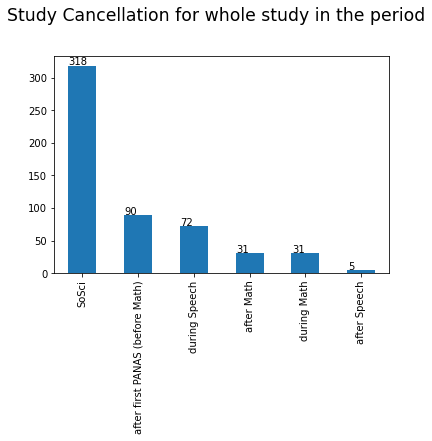

Total number of studies in the given period without duplicates: 547
Percentages of cancellation:
SoSci                              0.581353
after first PANAS (before Math)    0.164534
during Speech                      0.131627
after Math                         0.056673
during Math                        0.056673
after Speech                       0.009141
Name: study_cancellation, dtype: float64
Drop-outs in DST
SoSci                              112
after first PANAS (before Math)     89
during Speech                       51
during Math                         24
after Math                          21
after Speech                         3
Name: study_cancellation, dtype: int64
Percentages of cancellation in DST
SoSci                              0.373333
after first PANAS (before Math)    0.296667
during Speech                      0.170000
during Math                        0.080000
after Math                         0.070000
after Speech                       0.010000
Name: stu

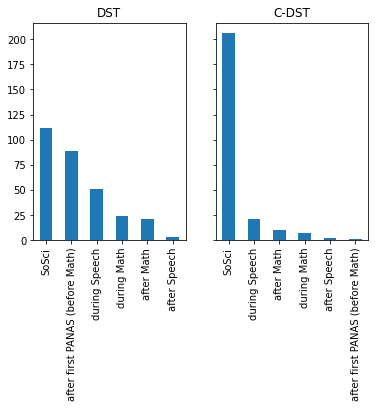

In [216]:
# for whole study in the chosen period, without prior participation

ax = meta_df_joined_filtered["study_cancellation"].value_counts().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.suptitle("Study Cancellation for whole study in the period", x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()


meta_not_before_math = meta_df_joined_filtered[meta_df_joined_filtered["study_cancellation"] != "before Math"]

print("Total number of studies in the given period without duplicates:", len(meta_df_joined_filtered))
print("Percentages of cancellation:")
print(meta_df_joined_filtered["study_cancellation"].value_counts(normalize=True))

print("Drop-outs in DST")
print(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "DST"]["study_cancellation"].value_counts()) 


print("Percentages of cancellation in DST")
print(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "DST"]["study_cancellation"].value_counts(normalize=True)) 

print("Drop-outs in C-DST")
print(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "C-DST"]["study_cancellation"].value_counts()) 
      
print("Percentages of cancellation in C-DST")
print(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "C-DST"]["study_cancellation"].value_counts(normalize=True)) 
      
# for DST and C-DST respectiveley

print("Total number of DST studies in the given period without duplicates:", len(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "DST"]))
print("Total number of C-DST studies in the given period without duplicates:", len(meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "C-DST"]))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "DST"]["study_cancellation"].value_counts().plot(kind = "bar", ax = axes[0], title = "DST")
meta_df_joined_filtered[meta_df_joined_filtered["Condition"] == "C-DST"]["study_cancellation"].value_counts().plot(kind = "bar", ax = axes[1], title = "C-DST") 

for p in axes[0].patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Math Task and Speech Task for all studies (before filtering)

In [217]:
# here we load and inspect the math-files

questions_total = []
percentage_end = []
subject_ids = []
user_inputs_total = []
math_df_list_updated = []
math_logging_end_time = []
math_df_list_new = [math_df for math_df in math_df_list if not math_df.empty]
math_df_list = math_df_list_new.copy()
for math_df in math_df_list :
    math_df = math_df.replace('', np.NaN)
    try: 
        math_df["task_input"] = math_df["task_input"].astype(float)
    except: 
        display(math_df)
    math_df['corrects_binary'] = np.where(math_df['task_answer'] == (math_df["task_input"]), 1 , 0)
    math_df['user_input_binary'] = np.where(math_df["task_input"].isna(),0, 1) 
    math_df['question_progress'] = 100* (math_df['question_number'] + 1) / (math_df.iloc[len(math_df)-1]["question_number"]+1)
    
    # calculating number of correct_answers after each question and add as new column
    counter = 0
    total_corrects= []
    for elem in math_df["corrects_binary"]:
        if elem == 1:
            counter += 1
        total_corrects.append(counter)
    
    math_df["total_corrects"] = total_corrects

    # calculating correct percentage after each question and add as new column
    correct_percentage = []
    for counter, elem in enumerate(math_df["total_corrects"]):
        correct_percentage.append(100*elem/(counter+1))

    math_df["correct_percentage"] = correct_percentage

    #calculate total number of questions, correct_percentage at the end for every participant and add to lists
    
    
    questions_total.append(math_df.iloc[len(math_df)-1]["question_number"]+1)
    percentage_end.append(math_df.iloc[len(math_df)-1]["correct_percentage"])
    subject_ids.append(math_df.iloc[0]["subject_id"])
    user_inputs_total.append(math_df["user_input_binary"].sum())
    math_logging_end_time.append(math_df.iloc[len(math_df)-1]["end_total_time"])
    
    math_df_list_updated.append(math_df)
    
# dataframe for individual results of the participants
data = {'Subject ID': subject_ids, 'questions_total': questions_total, 'percentage_end': percentage_end, 'user_inputs_total': user_inputs_total, 'math_logging_end_time': math_logging_end_time} 
individual_results_df = pd.DataFrame(data)

individual_results_df["Math Participation"] = 100 * individual_results_df["user_inputs_total"] / individual_results_df["questions_total"]




print("This is for all Math-Files, i.e. not filtered for chosen start date!")
individual_results_df.describe()
#individual_results_df.to_csv(r"final_math")




This is for all Math-Files, i.e. not filtered for chosen start date!


Subject ID  questions_total  percentage_end  user_inputs_total  \
count   495.000000       495.000000     2155.000000        2155.000000   
mean   6167.779798        27.727273       14.892624           5.406961   
std    1384.413422         5.097070       28.995291          10.357583   
min    1385.000000         1.000000        0.000000           0.000000   
25%    5424.500000        24.000000        0.000000           0.000000   
50%    6233.000000        28.000000        0.000000           0.000000   
75%    7148.500000        31.000000        0.000000           0.000000   
max    8696.000000        44.000000      100.000000          42.000000   

       Math Participation  
count          495.000000  
mean            84.613657  
std             15.933072  
min              5.555556  
25%             73.879142  
50%             90.909091  
75%             96.720430  
max            100.000000

In [218]:
# duplicate uploads of math files, only keep first
individual_results_df.drop_duplicates(subset = "Subject ID", inplace = True)


### MAT Performance of all MATs in the given period (before filtering usability, prior knowledge etc.)

The average performance of the C-DST: 81.24829925602415 +- 8.311253610836545


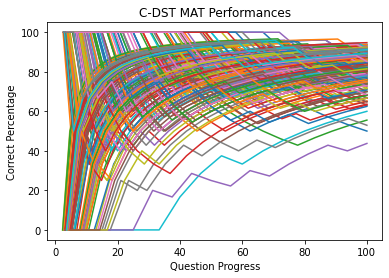

In [219]:
# plotting performance plots for all C-DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)

end_percentages = []

for math_df in math_df_list_updated:
    subject_id = math_df["subject_id"][0]
    if subject_id in meta_df_joined_filtered["Subject ID"].tolist():
        if meta_df_joined_filtered[meta_df_joined_filtered["Subject ID"] == subject_id]["Condition"].item() == "C-DST":
            plt.plot("question_progress", "correct_percentage", data=math_df)
            plt.legend()
            plt.xlabel('Question Progress')
            plt.ylabel('Correct Percentage')
            plt.title('C-DST MAT Performances')
            plt.legend().set_visible(False)
            end_percentages.append(individual_results_df[individual_results_df["Subject ID"] == subject_id]["percentage_end"].item())

print("The average performance of the C-DST:", np.mean(end_percentages), "+-", np.std(end_percentages))


The average performance of the DST: 44.39174535096699 +- 10.170078329117834


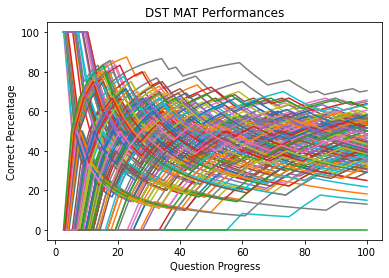

In [220]:
# plotting all performance plots for all DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)

end_percentages = []

for math_df in math_df_list_updated:
    subject_id = math_df["subject_id"][0]
    if subject_id in meta_df_joined_filtered["Subject ID"].tolist():
        if meta_df_joined_filtered[meta_df_joined_filtered["Subject ID"] == subject_id]["Condition"].item() == "DST":
            plt.plot("question_progress", "correct_percentage", data=math_df)
            plt.legend()
            plt.xlabel('Question Progress')
            plt.ylabel('Correct Percentage')
            plt.title('DST MAT Performances')
            plt.legend().set_visible(False)
            
            end_percentages.append(individual_results_df[individual_results_df["Subject ID"] == subject_id]["percentage_end"].item())

print("The average performance of the DST:", np.mean(end_percentages), "+-", np.std(end_percentages))

In [221]:
# join math data to meta data (with date-filtering)
meta_df_joined_math = pd.merge(meta_df_joined_filtered, individual_results_df, on='Subject ID', how='left')

In [222]:
# load freeSpeechData to inspect and filter
speaking_parts_total = []
speaking_parts_task1 = []
speaking_parts_task2 = []
speaking_parts_task3 = []
total_parts = []
subject_ids = []

empty_counter = 0
speech_df_list = []    
for path in file_paths:
    if path.count("speechTask.json")>0:
        file = open(path, 'r')
        speech_df = pd.read_json(file)
        
# try, except because of some empty dataframes
        try:
# for later comparison: total speaking parts, total parts, percentage in individual dataframe

            speaking_parts_total.append((speech_df["feedback"] == 1).sum())
            total_parts.append(len(speech_df))
            
            speaking_parts_task1.append((speech_df[speech_df["stage"] == "runTask1"]["feedback"] == 1).sum())
            speaking_parts_task2.append((speech_df[speech_df["stage"] == "runTask2"]["feedback"] == 1).sum())
            speaking_parts_task3.append((speech_df[speech_df["stage"] == "runTask3"]["feedback"] == 1).sum())
            speech_df["subjectId"] = pd.to_numeric(speech_df['subjectId'], errors = 'coerce')
            subject_ids.append(speech_df.iloc[0]["subjectId"])
            
            # calculate time progress and percentage_spoken for plotting over time
            speech_df['time_progress'] = 100* (speech_df.index + 1) / len(speech_df)
            
            speaking_percentage = []
            for counter, elem in enumerate(speech_df["feedback"]):
                speaking_percentage.append(100*elem/(counter+1))
            
            speech_df['speaking_percentage'] = speaking_percentage

            speech_df_list.append(speech_df)
            
        except:
            empty_counter += 1
        
    
    data = {'Subject ID': subject_ids, 'Total Parts': total_parts, 
            'Total Speaking Parts': speaking_parts_total, 'Speaking Parts Task 1': speaking_parts_task1, 
            'Speaking Parts Task 2': speaking_parts_task2, 'Speaking Parts Task 3': speaking_parts_task3} 
    speech_individual_df = pd.DataFrame(data)
    speech_individual_df["Speaking Percentage Total"] = 100 * speech_individual_df["Total Speaking Parts"] / speech_individual_df["Total Parts"] 
    speech_individual_df["Speaking Percentage Task 1"] = 100 * speech_individual_df["Speaking Parts Task 1"] / speech_individual_df["Total Parts"] / 3 
    speech_individual_df["Speaking Percentage Task 2"] = 100 * speech_individual_df["Speaking Parts Task 2"] / speech_individual_df["Total Parts"] / 3
    speech_individual_df["Speaking Percentage Task 3"] = 100 * speech_individual_df["Speaking Parts Task 3"] / speech_individual_df["Total Parts"] / 3


print("Anzahl empty Dataframes:", empty_counter)
#speech_individual_df.to_csv(r"final_speech")

Anzahl empty Dataframes: 34


In [223]:
# join speech data to meta and math data (with date-filtering)
meta_df_joined_all = pd.merge(meta_df_joined_math, speech_individual_df, on='Subject ID', how='left')


176 C-DST results for speech


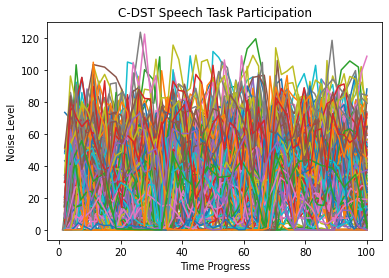

In [224]:
# plotting speech participation plots for all C-DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)

counter = 0

for speech_df in speech_df_list:
    subject_id = speech_df["subjectId"][0]
    if subject_id in meta_df_joined_all["Subject ID"].tolist():
        if meta_df_joined_all[meta_df_joined_all["Subject ID"] == subject_id]["Condition"].item() == "C-DST":
            
            # counter for number of C-DSTs
            counter += 1
            plt.plot('time_progress', 'noiseLevel', data=speech_df)
            plt.legend()
            plt.xlabel('Time Progress')
            plt.ylabel('Noise Level')
            plt.title('C-DST Speech Task Participation')
            plt.legend().set_visible(False)

print(counter, "C-DST results for speech")
            


113 DST results for speech


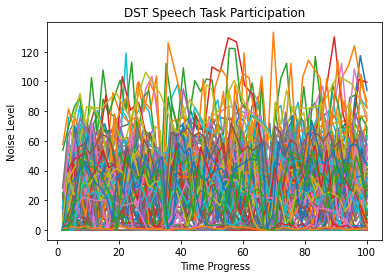

In [225]:
# plotting speech participation plots for all DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)
counter = 0

for speech_df in speech_df_list:
    subject_id = speech_df["subjectId"][0]

    if subject_id in meta_df_joined_all["Subject ID"].tolist():

        if meta_df_joined_all[meta_df_joined_all["Subject ID"] == subject_id]["Condition"].item() == "DST":
            # counter for number of C-DSTs
            counter += 1
            
            plt.plot('time_progress', 'noiseLevel', data=speech_df)
            plt.legend()
            plt.xlabel('Time Progress')
            plt.ylabel('Noise Level')
            plt.title('DST Speech Task Participation')
            plt.legend().set_visible(False)
        
print(counter, "DST results for speech")

# Completed Studies without Questionnaires

In [226]:
# only completed studies, i.e. entering SoSci-Survey, sorting for increasing date
meta_completed = meta_df_joined_all[meta_df_joined_all["study_cancellation"] == "SoSci"].sort_values(by = "Start Time").reset_index(drop = True)
meta_completed_dst = meta_completed[meta_completed["Condition"] == "DST"]
meta_completed_cdst = meta_completed[meta_completed["Condition"] == "C-DST"]

#meta_completed.to_csv(r'data/SoSci-Survey/meta_completed.csv')
meta_completed[["Condition", "Start Time"]]

Condition           Start Time
0       C-DST  2021/02/10 18:11:24
1       C-DST  2021/02/11 13:37:50
2         DST  2021/02/11 14:24:36
3         DST  2021/02/11 15:18:24
4       C-DST  2021/02/12 00:42:16
5       C-DST  2021/02/12 00:55:07
6       C-DST  2021/02/12 07:09:58
7       C-DST  2021/02/12 09:54:38
8       C-DST  2021/02/12 10:06:10
9       C-DST  2021/02/12 11:31:33
10      C-DST  2021/02/12 11:50:45
11        DST  2021/02/12 12:26:43
12      C-DST  2021/02/12 12:27:15
13        DST  2021/02/12 12:32:20
14      C-DST  2021/02/12 12:35:45
15      C-DST  2021/02/12 12:38:31
16      C-DST  2021/02/12 12:46:46
17        DST  2021/02/12 12:51:57
18      C-DST  2021/02/12 12:52:43
19      C-DST  2021/02/12 13:01:13
20      C-DST  2021/02/12 13:02:34
21      C-DST  2021/02/12 13:03:20
22      C-DST  2021/02/12 13:05:33
23        DST  2021/02/12 13:06:03
24      C-DST  2021/02/12 13:12:54
25      C-DST  2021/02/12 13:17:25
26      C-DST  2021/02/12 13:18:55
27      C-DST  2021/02/12 13:20:27
28        DST  2021/02/12 13:22:21
29      C-DST  2021/02/12 13:27:27
30      C-DST  2021/02/12 13:43:22
31        DST  2021/02/12 13:46:47
32        DST  2021/02/12 14:01:40
33      C-DST  2021/02/12 14:06:34
34      C-DST  2021/02/12 14:07:54
35      C-DST  2021/02/12 14:09:24
36      C-DST  2021/02/12 14:13:30
37      C-DST  2021/02/12 14:16:57
38      C-DST  2021/02/12 14:20:21
39      C-DST  2021/02/12 14:26:19
40        DST  2021/02/12 14:26:43
41      C-DST  2021/02/12 14:28:55
42      C-DST  2021/02/12 14:54:08
43      C-DST  2021/02/12 14:59:01
44      C-DST  2021/02/12 15:07:44
45      C-DST  2021/02/12 15:08:32
46      C-DST  2021/02/12 15:09:16
47      C-DST  2021/02/12 15:09:44
48      C-DST  2021/02/12 15:20:42
49      C-DST  2021/02/12 15:36:39
50        DST  2021/02/12 15:42:33
51        DST  2021/02/12 15:52:42
52        DST  2021/02/12 16:06:57
53      C-DST  2021/02/12 16:21:04
54      C-DST  2021/02/12 16:28:43
55      C-DST  2021/02/12 16:34:57
56        DST  2021/02/12 16:44:56
57      C-DST  2021/02/12 16:48:40
58      C-DST  2021/02/12 16:59:25
59      C-DST  2021/02/12 17:00:14
60      C-DST  2021/02/12 17:03:16
61      C-DST  2021/02/12 17:05:33
62      C-DST  2021/02/12 17:37:22
63      C-DST  2021/02/12 17:49:30
64      C-DST  2021/02/12 17:51:15
65        DST  2021/02/12 17:54:44
66      C-DST  2021/02/12 18:09:54
67      C-DST  2021/02/12 18:22:46
68      C-DST  2021/02/12 18:31:10
69      C-DST  2021/02/12 18:43:35
70      C-DST  2021/02/12 18:56:35
71      C-DST  2021/02/12 19:04:20
72      C-DST  2021/02/12 19:18:27
73      C-DST  2021/02/12 19:44:13
74      C-DST  2021/02/12 19:50:57
75      C-DST  2021/02/12 19:57:26
76        DST  2021/02/12 20:14:31
77        DST  2021/02/12 20:15:28
78        DST  2021/02/12 20:19:33
79        DST  2021/02/12 20:22:51
80        DST  2021/02/12 20:41:01
81        DST  2021/02/12 20:44:52
82      C-DST  2021/02/12 20:48:10
83      C-DST  2021/02/12 21:07:46
84      C-DST  2021/02/12 21:24:39
85      C-DST  2021/02/12 22:10:15
86      C-DST  2021/02/12 23:36:02
87        DST  2021/02/13 01:35:17
88      C-DST  2021/02/13 05:12:46
89      C-DST  2021/02/13 08:13:49
90      C-DST  2021/02/13 08:41:12
91        DST  2021/02/13 08:52:31
92      C-DST  2021/02/13 09:10:12
93      C-DST  2021/02/13 09:10:46
94      C-DST  2021/02/13 09:12:41
95      C-DST  2021/02/13 09:39:24
96        DST  2021/02/13 09:47:43
97      C-DST  2021/02/13 10:16:56
98      C-DST  2021/02/13 10:29:33
99      C-DST  2021/02/13 10:37:35
100     C-DST  2021/02/13 10:45:43
101     C-DST  2021/02/13 10:46:38
102       DST  2021/02/13 11:08:47
103       DST  2021/02/13 11:15:31
104     C-DST  2021/02/13 11:17:36
105       DST  2021/02/13 11:28:00
106     C-DST  2021/02/13 11:54:39
107       DST  2021/02/13 11:59:55
108       DST  2021/02/13 12:11:25
109     C-DST  2021/02/13 12:27:36
110     C-DST  2021/02/13 12:47:07
111       DST  2021/02/13 12:58:21
112     C-DST  2021/02/13 13:06:12
113     C-DST 

# Questionnaires
## Now we also load the SoSci-Data for more filtering (Usability, Framing, prior knowledge) before analysing stress levels.


In [227]:
print("We have", len(sosci_prepped), "sosci-data (for same period but).")
print("We have", len(meta_completed), "meta-files completed.")

We have 323 sosci-data (for same period but).
We have 318 meta-files completed.


In [228]:
meta_completed["REF"] = meta_completed["REF"].astype(int)
sosci_prepped["REF"] = sosci_prepped["REF"].astype(int)

In [229]:
meta_sosci_joined = pd.merge(meta_completed, sosci_prepped, on = 'REF', how = 'left')
print("After joining meta files that are filtered for data and completeness with SoSci-Files from other Notebook, we have", len(meta_sosci_joined), "joined Files")

After joining meta files that are filtered for data and completeness with SoSci-Files from other Notebook, we have 318 joined Files


# Descriptives for all completed studies (before filtering usability)

In [230]:
display(meta_sosci_joined.groupby("Condition")["SD10"].value_counts(normalize = True))
display(meta_sosci_joined.groupby("Condition")["SD14"].value_counts(normalize = True))
display(meta_sosci_joined.groupby("Condition")["language"].value_counts())

Condition  SD10                                                                     
C-DST      Hochschulabschluss                                                           0.560000
           Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.300000
           Promotion                                                                    0.070000
           Realschule (Mittlere Reife)                                                  0.045000
           Anderer Schulabschluss:                                                      0.025000
DST        Hochschulabschluss                                                           0.567568
           Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.315315
           Promotion                                                                    0.081081
           Anderer Schulabschluss:                                                      0.018018
           Realschule (Mittlere Reife)    

Condition  SD14                     
C-DST      Angestellte/r                0.405941
           Student/in                   0.341584
           Selbstständig                0.084158
           Beamte/r                     0.054455
           Sonstiges:                   0.049505
           Schüler/in                   0.039604
           Arbeitslos/Arbeit suchend    0.014851
           In Ausbildung                0.009901
DST        Angestellte/r                0.432432
           Student/in                   0.351351
           Beamte/r                     0.081081
           Selbstständig                0.072072
           Sonstiges:                   0.036036
           Arbeitslos/Arbeit suchend    0.018018
           In Ausbildung                0.009009
Name: SD14, dtype: float64

Condition  language
C-DST      de          206
DST        de          112
Name: language, dtype: int64

# Context-Analysis of all completed studies (before filtering usability)

In [231]:
interesting_sosci_cols = ["Fragebogen, der im Interview verwendet wurde", "Sprache", 
                          "Formale Bildung", "Formale Bildung: Anderer Schulabschluss",
                          "Beschäftigung", "Land (weltweit, in de+en)", "Personen", "Geräusche",
                          "Ort","Zeit", "sitzen/liegen", "Vorwissen"]

sosci_df = meta_sosci_joined[sosci_analysis_cols]
sosci_df.columns = sosci_labels

for col in interesting_sosci_cols:
    print(sosci_df[col].value_counts(normalize = True))
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

    



C-DST                       0.646497
DST_komplett_neu15102020    0.353503
Name: Fragebogen, der im Interview verwendet wurde, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
ger    0.996815
eng    0.003185
Name: Sprache, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Hochschulabschluss                                                           0.562701
Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.305466
Promotion                                                                    0.073955
Realschule (Mittlere Reife)                                                  0.035370
Anderer Schulabschluss:                                                      0.022508
Name: Formale Bildung, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Berufsschulabschluss           0.166667
2. Staatse

In [232]:
# Check for prior knowledge according to SoSci-Question
display(meta_sosci_joined.groupby("Condition")["C107"].value_counts())

# filter out prior knowledge:

meta_sosci_joined = meta_sosci_joined[meta_sosci_joined["C107"] != "ja"]

print("After deleting prior knowlegde:")
display(len(meta_sosci_joined))

Condition  C107
C-DST      nein    189
           ja       13
DST        nein    111
Name: C107, dtype: int64

After deleting prior knowlegde:


305

In [233]:
# Now we filter verbal usability feedback if noticable
display(meta_sosci_joined[["Subject ID","U205_05", "Condition"]][meta_sosci_joined["U205_05"].notna()])

# filter out, because texts not readable:
display(meta_sosci_joined.groupby("Condition")["U205_05"].value_counts())
meta_sosci_joined = meta_sosci_joined[meta_sosci_joined["U205_05"].isna()]

print("After filtering out problems with Text based on likert scale:")
display(len(meta_sosci_joined))

# filter out major usability issues in one of the likert scales, i.e. if participants totally disagree:
display(meta_sosci_joined.groupby("Condition")["U204"].value_counts())
meta_sosci_joined = meta_sosci_joined[meta_sosci_joined["U204"] != -2]
print("After filtering out problems with VAS based on likert-scale:")
display(len(meta_sosci_joined))

Subject ID                                            U205_05 Condition
28       5230.0  Es müsste gescrollt werden um die Aufgabe voll...       DST
50       5416.0  Die Platzierung der Bewerbungsfrage geht in de...       DST
79       5691.0  die zahl 0 im mathe test war von meiner Browse...       DST
87       5779.0  Insbesondere beim Mathetest habe ich die Null ...       DST
132      6160.0  Aufgaben für den sprachlichen Teil sind nach u...       DST
288      7901.0  Der zahlenblock war nicht vollständig zu sehen...     C-DST
292      7972.0                                 Scrollen war nötig       DST
309      8310.0  Das Layout der mathematischen Aufgaben wurde n...     C-DST

Condition  U205_05                                                                                                                                                 
C-DST      Das Layout der mathematischen Aufgaben wurde nicht vorgestellt, das war irritierend.                                                                        1
           Der zahlenblock war nicht vollständig zu sehen, och habe überlegt wie ich ohne dien0 auskommen soll.. stresstest?                                           1
DST        Aufgaben für den sprachlichen Teil sind nach unten aus dem Bild gerutscht                                                                                   1
           Die Platzierung der Bewerbungsfrage geht in der kurzen zeit zu sehr unter. und dieses feld ist winzig                                                       1
           Es müsste gescrollt werden um die Aufgabe vollständig unten lesen zu können.                                                                         

After filtering out problems with Text based on likert scale:


297

Condition  U204
C-DST       2.0    177
           -2.0      9
DST         2.0    102
           -2.0      2
Name: U204, dtype: int64

After filtering out problems with VAS based on likert-scale:


286

In [234]:
# here we inspect  verbal usability issues but don't filter

display(meta_sosci_joined[["Subject ID","U214_01"]][meta_sosci_joined["U214_01"].notna()])
verbal_filtering_ids = meta_sosci_joined["Subject ID"].tolist()
ids = [5990.0, 6030.0, 6349.0, 6522.0, 6545.0, 6576.0, 6750.0, 6763.0, 6851.0, 7208.0, 7239.0,7425.0, 7493.0, 7574.0, 7666.0, 7915.0, 8554.0]
verbal_filtering_ids = [np.nan if x in ids else x for x in verbal_filtering_ids]
#meta_sosci_joined = meta_sosci_joined[meta_sosci_joined["Subject ID"] == verbal_filtering_ids]

display(len(meta_sosci_joined))

display(meta_sosci_joined.groupby("Condition")["U210"].value_counts())
display(meta_sosci_joined.groupby("Condition")["U211"].value_counts())

Subject ID                                            U214_01
2        4974.0  Ich habe mich bei dem Sprech-Test nicht selbst...
11       5109.0  Die Tastatur auf dem Smartphone war äußerst un...
78       5688.0  Die Schrift/Darstellung war etwas zu groß, tei...
81       5707.0  Dadurch das einem gezeigt worden ist wie viele...
108      5990.0  Ich musste im Mathe test den Bildschirm nach o...
111      6030.0  Schieberegler sprach sehr leicht an, dadurch k...
123      6111.0  Ich habe sehr schnell an der "Vergleichsgruppe...
142      6191.0  Bei der Angabe der Emotionen wäre es gut, dass...
162      6349.0  Beim Mathe-Test auf dem iPhone 8 mit iOS 14.4 ...
164      6420.0           Die Intention war schnell durchschaubar.
173      6508.0  Es war viel zu offensichtlich, dass die Vergle...
174      6522.0  Teilweise wurde bei mir nicht das ganze Tasten...
175      6545.0  Ich hatte während der Sprachanalyse popupmitte...
180      6576.0  Ich hatte in meinem Browser eingestellt, dass ...
195      6707.0  Bei den Matheaufgaben wurde mir klar, dass die...
201      6750.0  Die Bedienung auf dem Smartphone war mangelhaf...
204      6763.0  Im Mathetest war der Bildschirm so skaliert, d...
214      6851.0  Tasten bei Matheaufgabe waren teilweise außerh...
237      7208.0  Beim Mat-Test hat mein Handy das Eintippen der...
239      7219.0  Die Mathe Fragen waren so schwer,dass schnell ...
242      7239.0                    Tastenfeld im Mathetest zu groß
251      7425.0  Die Aufgaben unter dem Video waren nicht auf e...
254      7458.0  Der Smartphone Bildschirm ist zu klein, ich mu...
255      7493.0  Bei den Mathe Aufgaben hat mein Touch Screen t...
262      7574.0  Bein Mathetest konnte ich nicht immer Zahlen e...
270      7666.0  Im mathetest war es nicht möglich, eine Zahl z...
289      7915.0  Habe den Test über die Ecosia App nicht starte...
298      8015.0  Die Aufforderung, mich mehr anzustrengen, fand...
316      8554.0  Mein Browser wollte immer wieder die Erlaubnis...

286

Condition  U210
C-DST       2.0    136
           -2.0     35
DST         2.0     93
           -2.0      8
Name: U210, dtype: int64

Condition  U211
C-DST      -2.0    155
            2.0     19
DST        -2.0     84
            2.0     15
Name: U211, dtype: int64

In [235]:
# here we filter the participants that took more than 2 STD longer for performing the tasks in the app.

pd.set_option("display.max_columns", None)



meta_sosci_joined["Total App Time"] = ((meta_sosci_joined["entered_sosci_survey"] - meta_sosci_joined["panasBaseline_begin"])/1000)/60
display(meta_sosci_joined["Total App Time"].describe())
#display(meta_completed["Total App Time"].hist())
#display(meta_completed.loc[:, interesting_columns].groupby("Condition").describe())
#display(meta_completed.loc[:, interesting_columns].describe())

display(meta_sosci_joined[meta_sosci_joined["Total App Time"] >= 15])

meta_sosci_joined = meta_sosci_joined[meta_sosci_joined["Total App Time"] < 15]
      
print("After filtering out duration outliers:")
display(len(meta_sosci_joined))
display(display(meta_sosci_joined.groupby("Condition")["Total App Time"].describe()))

count    286.000000
mean       7.147826
std        2.985465
min        4.593600
25%        6.149342
50%        6.806433
75%        7.570604
max       50.955300
Name: Total App Time, dtype: float64

reference  enter_app  panasBaseline_begin  panasBaseline_end  \
58         NaN        9.0             456358.0           526680.0   
294        NaN        5.0             214357.0           301143.0   

     start_time_dst  end_time_dst  entered_sosci_survey  start_mathTask  \
58             19.0     3416129.0             3513676.0        561720.0   
294             6.0     1223779.0             1344276.0        579464.0   

     end_mathTask  start_speechTask  end_speechTask  panasEnd_begin  \
58       652987.0         3302044.0       3416118.0       3437852.0   
294      671862.0         1091575.0       1223765.0       1257408.0   

     panasEnd_end test_version Condition  Subject ID workerId  device  \
58      3489473.0           11     C-DST      5499.0     3691  mobile   
294     1309052.0           11       DST      7996.0     6155  mobile   

    operatingSystem       REF                                        browser  \
58       Android OS  11005499  BrowserName = Chrome\nVersion = 88.0.4324.152   
294             iOS  11007996         BrowserName = Safari\nVersion = 14.0.3   

    language   age  gender  baseline.stress  baseline.frustrated  \
58        de  26.0    male             25.0                 25.0   
294       de  30.0  female             22.0                  0.0   

     baseline.overstrained  baseline.ashamed  intermediate.stress  \
58                    25.0               0.0                 80.0   
294                    0.0               0.0                 18.0   

     intermediate.frustrated  intermediate.overstrained  intermediate.ashamed  \
58                       0.0                        0.0                  30.0   
294                      5.0                        0.0                   6.0   

     freeSpeech.stress  freeSpeech.frustrated  freeSpeech.overstrained  \
58                25.0                    0.0                      0.0   
294               10.0                   11.0                      0.0   

     freeSpeech.ashamed  begin_panas.active  begin_panas.upset  \
58                  0.0                 3.0                1.0   
294                 0.0                 4.0                1.0   

     begin_panas.hostile  begin_panas.inspired  begin_panas.ashamed  \
58                   1.0                   3.0                  1.0   
294                  1.0                   1.0                  1.0   

     begin_panas.alert  begin_panas.nervous  begin_panas.determined  \
58                 3.0                  1.0                     2.0   
294                4.0                  3.0                     3.0   

     begin_panas.attentive  begin_panas.afraid  end_panas.active  \
58                     3.0                 1.0               3.0   
294                    4.0                 1.0               4.0   

     end_panas.upset  end_panas.hostile  end_panas.inspired  \
58               1.0                1.0                 3.0   
294              1.0                1.0                 1.0   

     end_panas.ashamed  end_panas.alert  end_panas.nervous  \
58                 1.0              3.0                1.0   
294                1.0              5.0                2.0   

     end_panas.determined  end_panas.attentive  end_panas.afraid participated  \
58                    3.0                  3.0               1.0        false   
294                   2.0                  4.0               1.0        False   

     MathTask_time  SpeechTask_time  VAS_pre_mean  VAS_intermediate_mean  \
58         91267.0         114074.0         18.75                  27.50   
294        92398.0         132190.0          5.50                   7.25   

     VAS_post_mean  VAS_mean_post_pre  VAS_mean_post_intermediate  \
58            6.25             -12.50                      -21.25   
294           5.25              -0.25                       -2.00   

     VAS_mean_intermediate_pre  VAS_frustrated_post_pre  VAS_ashamed_post_pre  \
58                        8.75               

After filtering out duration outliers:


284

count      mean       std       min      25%       50%       75%  \
Condition                                                                     
C-DST      181.0  6.531490  1.054997  4.593600  5.76075  6.365100  7.158217   
DST        103.0  7.692147  1.346649  5.423667  6.76500  7.392833  8.468133   

                 max  
Condition             
C-DST      11.448383  
DST        12.727783

None

# Final Dataset
## From here on we have the final dataset including SoSci and after filtering for prior knowledge, usability issues and too long time.

In [236]:
## The file to be analysed in the following is the meta_file. We worked and filtered with the meta_sosci_joined - file so far.
## Here we set the meta_completed file to the newly filtered file:

meta_completed = meta_sosci_joined
meta_completed_dst = meta_completed[meta_completed["Condition"] == "DST"].reset_index(drop = True)
meta_completed_cdst = meta_completed[meta_completed["Condition"] == "C-DST"].reset_index(drop = True)

In [237]:
## People who did not believe at all in framing (likert-scale -2)

display(meta_completed["SS02"].value_counts(normalize = True))
display(meta_completed_dst["SS02"].value_counts(normalize = True))
display(meta_completed_cdst["SS02"].value_counts(normalize = True))


 0.0    0.267148
 1.0    0.238267
 2.0    0.169675
-2.0    0.169675
-1.0    0.155235
Name: SS02, dtype: float64

 0.0    0.287129
 1.0    0.267327
 2.0    0.188119
-1.0    0.148515
-2.0    0.108911
Name: SS02, dtype: float64

 0.0    0.255682
 1.0    0.221591
-2.0    0.204545
 2.0    0.159091
-1.0    0.159091
Name: SS02, dtype: float64

In [238]:
## inspect usability issues of final participants

display(meta_completed[["Subject ID","U214_01"]][meta_completed["U214_01"].notna()])

len(meta_completed[meta_completed["U204"] <= -1])

for col in meta_completed.columns:
    if col.startswith("U") or col.startswith("SS25"):
        print(col)
        display(meta_completed[col].value_counts(normalize = False))

print("Not speaking in ST:")
display(meta_completed.groupby("Condition")["SS25"].value_counts())
print("Not giving input to MAT at some time:")
display(meta_completed.groupby("Condition")["SS23"].value_counts())
len(meta_completed["SS23"])

Subject ID                                            U214_01
2        4974.0  Ich habe mich bei dem Sprech-Test nicht selbst...
11       5109.0  Die Tastatur auf dem Smartphone war äußerst un...
78       5688.0  Die Schrift/Darstellung war etwas zu groß, tei...
81       5707.0  Dadurch das einem gezeigt worden ist wie viele...
108      5990.0  Ich musste im Mathe test den Bildschirm nach o...
111      6030.0  Schieberegler sprach sehr leicht an, dadurch k...
123      6111.0  Ich habe sehr schnell an der "Vergleichsgruppe...
142      6191.0  Bei der Angabe der Emotionen wäre es gut, dass...
162      6349.0  Beim Mathe-Test auf dem iPhone 8 mit iOS 14.4 ...
164      6420.0           Die Intention war schnell durchschaubar.
173      6508.0  Es war viel zu offensichtlich, dass die Vergle...
174      6522.0  Teilweise wurde bei mir nicht das ganze Tasten...
175      6545.0  Ich hatte während der Sprachanalyse popupmitte...
180      6576.0  Ich hatte in meinem Browser eingestellt, dass ...
195      6707.0  Bei den Matheaufgaben wurde mir klar, dass die...
201      6750.0  Die Bedienung auf dem Smartphone war mangelhaf...
204      6763.0  Im Mathetest war der Bildschirm so skaliert, d...
214      6851.0  Tasten bei Matheaufgabe waren teilweise außerh...
237      7208.0  Beim Mat-Test hat mein Handy das Eintippen der...
239      7219.0  Die Mathe Fragen waren so schwer,dass schnell ...
242      7239.0                    Tastenfeld im Mathetest zu groß
251      7425.0  Die Aufgaben unter dem Video waren nicht auf e...
254      7458.0  Der Smartphone Bildschirm ist zu klein, ich mu...
255      7493.0  Bei den Mathe Aufgaben hat mein Touch Screen t...
262      7574.0  Bein Mathetest konnte ich nicht immer Zahlen e...
270      7666.0  Im mathetest war es nicht möglich, eine Zahl z...
289      7915.0  Habe den Test über die Ecosia App nicht starte...
298      8015.0  Die Aufforderung, mich mehr anzustrengen, fand...
316      8554.0  Mein Browser wollte immer wieder die Erlaubnis...

U202


 2.0    100
-2.0      1
Name: U202, dtype: int64

U203


 2.0    77
 1.0    15
 0.0     5
-1.0     3
-2.0     1
Name: U203, dtype: int64

U204


2.0    277
Name: U204, dtype: int64

U205


 2.0    181
 1.0     65
 0.0     22
-2.0      6
-1.0      3
Name: U205, dtype: int64

U205_05


Series([], Name: U205_05, dtype: int64)

U207


-2.0    196
-1.0     65
 0.0     11
 2.0      3
 1.0      2
Name: U207, dtype: int64

U212


-1.0    58
 0.0    58
-2.0    34
 1.0    21
 2.0     5
Name: U212, dtype: int64

U213


 1.0    36
 0.0    35
 2.0    18
-1.0     7
-2.0     5
Name: U213, dtype: int64

U208


 2.0    110
 1.0     87
 0.0     50
-1.0     21
-2.0      9
Name: U208, dtype: int64

U210


 2.0    227
-2.0     43
Name: U210, dtype: int64

U211


-2.0    237
 2.0     34
Name: U211, dtype: int64

U214_01


Ich habe mich bei dem Sprech-Test nicht selbst angeschaut.                                                                                                                                                                                                                                                                                                                                                                              1
Die Bedienung auf dem Smartphone war mangelhaft; teilweise wurde der Inhalt des Tests vom Interface des Browsers (Safari) überdeckt. Bei einem Display wie das eines iPhone 12 Pro sollte eigentlich genug Raum vorhanden sein, um alle Inhalte sicher anzeigen zu können. Das Problem trat sowohl bei den Matheaufgaben als auch beim vorzulesenden Text auf. Diese Tatsache hat zusätzlichen Stress erzeugt.                          1
Die Aufforderung, mich mehr anzustrengen, fand ich Misstrauen erregend                                                                              

SS25


-2.0    227
-1.0     24
 0.0     17
 2.0      5
 1.0      4
Name: SS25, dtype: int64

Not speaking in ST:


Condition  SS25
C-DST      -2.0    153
           -1.0     10
            0.0      9
            2.0      4
DST        -2.0     74
           -1.0     14
            0.0      8
            1.0      4
            2.0      1
Name: SS25, dtype: int64

Not giving input to MAT at some time:


Condition  SS23
C-DST      -2.0    173
            2.0      3
DST        -2.0     90
            2.0     11
Name: SS23, dtype: int64

284

In [239]:
display(meta_completed_dst["gender"].value_counts())
display(meta_completed_cdst["gender"].value_counts())


female    52
male      50
other      1
Name: gender, dtype: int64

female    96
male      83
other      2
Name: gender, dtype: int64

# Context-Analysis of all completed studies (after filtering)

In [240]:


interesting_sosci_cols = ["Fragebogen, der im Interview verwendet wurde", "Sprache", 
                          "Formale Bildung", "Formale Bildung: Anderer Schulabschluss",
                          "Beschäftigung", "Land (weltweit, in de+en)", "Personen", "Geräusche",
                          "Ort","Zeit", "sitzen/liegen", "Vorwissen"]

sosci_df = meta_completed[sosci_analysis_cols]
sosci_df.columns = sosci_labels

for col in interesting_sosci_cols:
    print(sosci_df[col].value_counts(normalize = True))
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

    



C-DST                       0.635714
DST_komplett_neu15102020    0.364286
Name: Fragebogen, der im Interview verwendet wurde, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
ger    0.996429
eng    0.003571
Name: Sprache, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Hochschulabschluss                                                           0.566787
Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.306859
Promotion                                                                    0.072202
Realschule (Mittlere Reife)                                                  0.028881
Anderer Schulabschluss:                                                      0.025271
Name: Formale Bildung, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Berufsschulabschluss           0.166667
2. Staatse

# Descriptives of all completed studies (after filtering)

In [241]:
display(meta_sosci_joined.groupby("Condition")["SD10"].value_counts(normalize = True))
display(meta_sosci_joined.groupby("Condition")["SD14"].value_counts(normalize = True))
display(meta_sosci_joined.groupby("Condition")["language"].value_counts())

Condition  SD10                                                                     
C-DST      Hochschulabschluss                                                           0.577143
           Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.297143
           Promotion                                                                    0.062857
           Realschule (Mittlere Reife)                                                  0.034286
           Anderer Schulabschluss:                                                      0.028571
DST        Hochschulabschluss                                                           0.549020
           Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)    0.323529
           Promotion                                                                    0.088235
           Anderer Schulabschluss:                                                      0.019608
           Realschule (Mittlere Reife)    

Condition  SD14                     
C-DST      Angestellte/r                0.395480
           Student/in                   0.338983
           Selbstständig                0.073446
           Beamte/r                     0.062147
           Sonstiges:                   0.056497
           Schüler/in                   0.045198
           Arbeitslos/Arbeit suchend    0.016949
           In Ausbildung                0.011299
DST        Angestellte/r                0.421569
           Student/in                   0.352941
           Beamte/r                     0.088235
           Selbstständig                0.078431
           Sonstiges:                   0.029412
           Arbeitslos/Arbeit suchend    0.019608
           In Ausbildung                0.009804
Name: SD14, dtype: float64

Condition  language
C-DST      de          181
DST        de          103
Name: language, dtype: int64

# Math Task and Speech Task of Completed Studies

The average performance of the DST: 45.70913742383742 +- 9.720277992900455
Number of Math-Files: 103
Number of missing Math-Files: 0


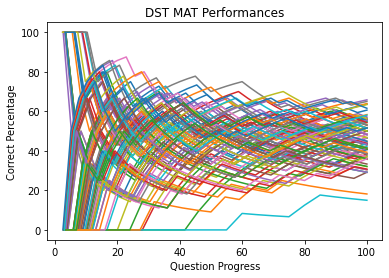

In [242]:
# plotting all performance plots for COMPLETED DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)

end_percentages = []

for math_df in math_df_list_updated:
    subject_id = math_df["subject_id"][0]
    if subject_id in meta_completed["Subject ID"].tolist():
        if meta_completed[meta_completed["Subject ID"] == subject_id]["Condition"].item() == "DST":
            plt.plot("question_progress", "correct_percentage", data=math_df)
            plt.legend()
            plt.xlabel('Question Progress')
            plt.ylabel('Correct Percentage')
            plt.title('DST MAT Performances')
            plt.legend().set_visible(False)
            
            end_percentages.append(individual_results_df[individual_results_df["Subject ID"] == subject_id]["percentage_end"].item())

print("The average performance of the DST:", np.mean(end_percentages), "+-", np.std(end_percentages))
print("Number of Math-Files:", len(end_percentages))
print("Number of missing Math-Files:", len(meta_completed[meta_completed["Condition"] == "DST"]) - len(end_percentages))

The average performance of the C-DST: 81.00530722021034 +- 8.02000831600665
Number of Studies: 181
Number of missing Math-Files: 0


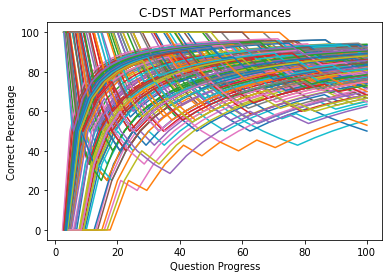

In [243]:
# plotting performance plots for all C-DST studies in the given period (based on existing Subject ID 
# in JATOS meta data in the chosen perios)

end_percentages = []

for math_df in math_df_list_updated:
    subject_id = math_df["subject_id"][0]
    if subject_id in meta_completed["Subject ID"].tolist():
        if meta_df_joined_filtered[meta_df_joined_filtered["Subject ID"] == subject_id]["Condition"].item() == "C-DST":
            plt.plot("question_progress", "correct_percentage", data=math_df)
            plt.legend()
            plt.xlabel('Question Progress')
            plt.ylabel('Correct Percentage')
            plt.title('C-DST MAT Performances')
            plt.legend().set_visible(False)
            end_percentages.append(individual_results_df[individual_results_df["Subject ID"] == subject_id]["percentage_end"].item())

print("The average performance of the C-DST:", np.mean(end_percentages), "+-", np.std(end_percentages))
print("Number of Studies:", len(end_percentages))
print("Number of missing Math-Files:", len(meta_completed[meta_completed["Condition"] == "C-DST"]) - len(end_percentages))

# Data Exploration

In the following cells we will explore the data between the two groups, i.e. DST and C-DST, respectively. Before we can compare the induced stress levels and other parameters, we need to check for normal distribution (i.e. shapiro-wilk test) and equal variance (levene). Additionally, several visualizations are displayed for exploring the data.

In [244]:
for column in meta_completed.columns:
    if column.startswith("baseline"):
        queries.append(column)
    elif column.startswith("intermediate"):
        queries.append(column)
    elif column.startswith("freeSpeech"):
        queries.append(column)
queries
        
        

['age',
 'VAS_mean_post_pre',
 'VAS_mean_post_intermediate',
 'VAS_mean_intermediate_pre',
 'VAS_pre_mean',
 'VAS_intermediate_mean',
 'VAS_post_mean',
 'PANAS_POS_pre',
 'PANAS_POS_post',
 'PANAS_NEG_pre',
 'PANAS_NEG_post',
 'PANAS_POS_post_pre',
 'PANAS_NEG_post_pre',
 'percentage_end',
 'user_inputs_total',
 'Speaking Percentage Total',
 'Math Participation',
 'PSS4 Sum',
 'RS_sum_german',
 'PANAS_VAS_post_pre',
 'VAS_stress_post_pre',
 'VAS_frustrated_post_pre',
 'VAS_ashamed_post_pre',
 'VAS_overstrained_post_pre',
 'baseline.stress',
 'baseline.frustrated',
 'baseline.overstrained',
 'baseline.ashamed',
 'intermediate.stress',
 'intermediate.frustrated',
 'intermediate.overstrained',
 'intermediate.ashamed',
 'freeSpeech.stress',
 'freeSpeech.frustrated',
 'freeSpeech.overstrained',
 'freeSpeech.ashamed']

/tmp/ipykernel_20712/831250540.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)


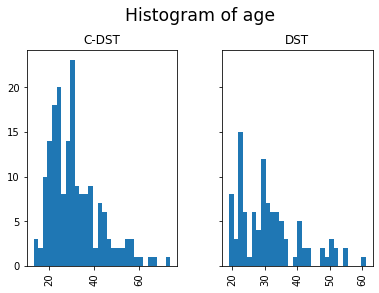

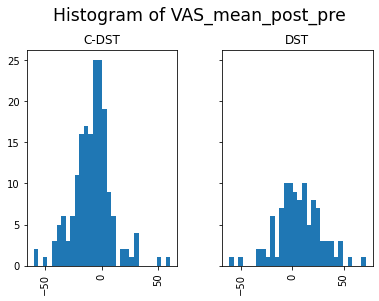

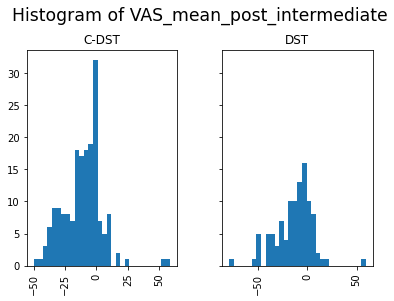

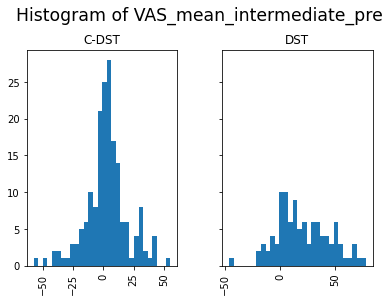

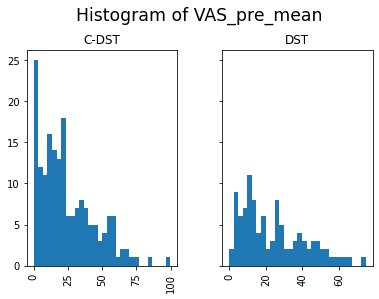

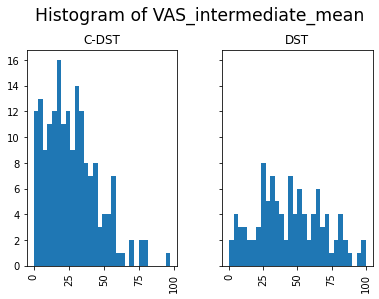

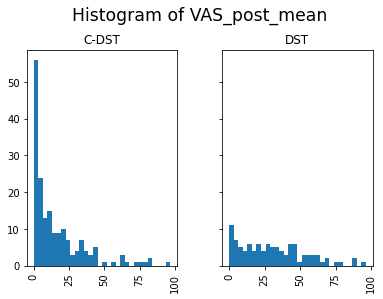

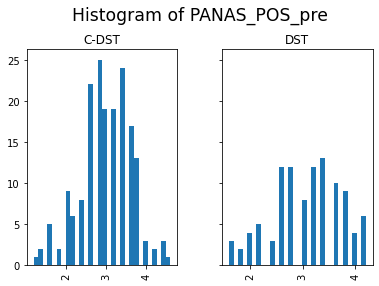

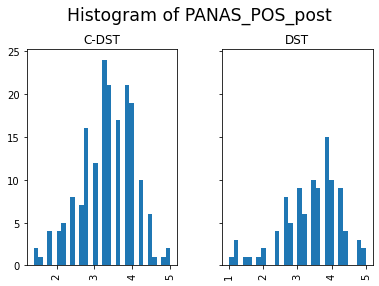

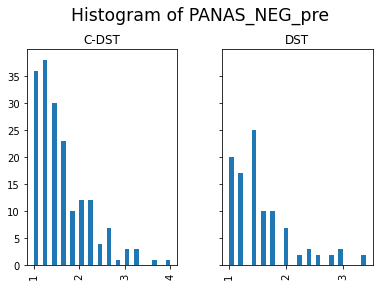

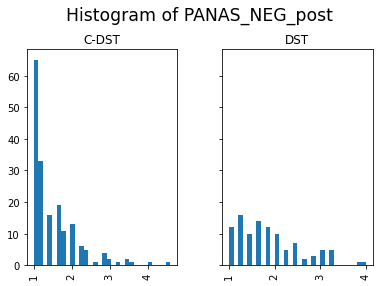

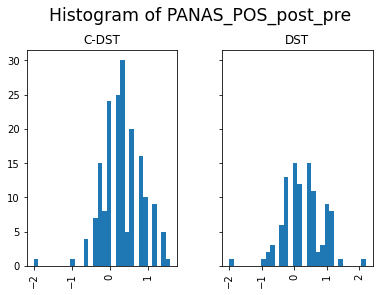

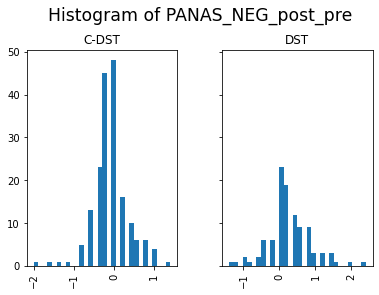

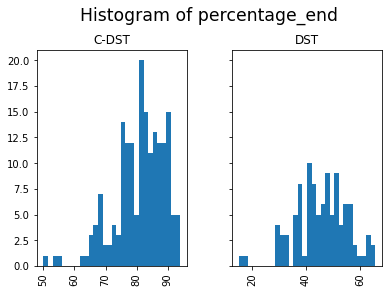

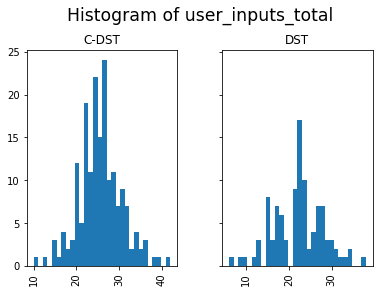

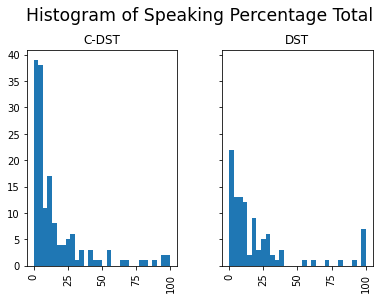

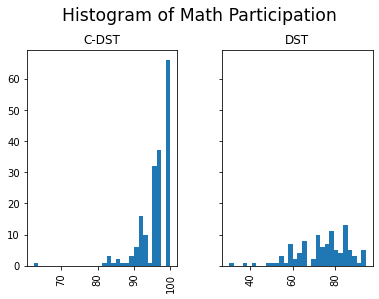

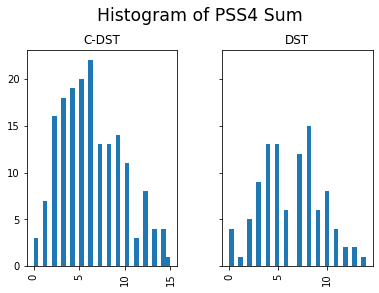

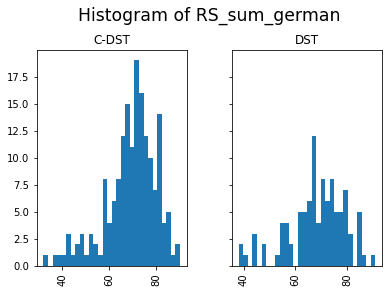

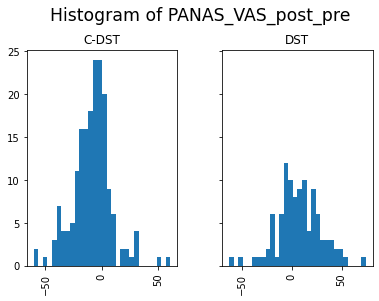

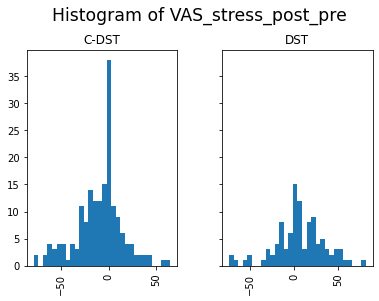

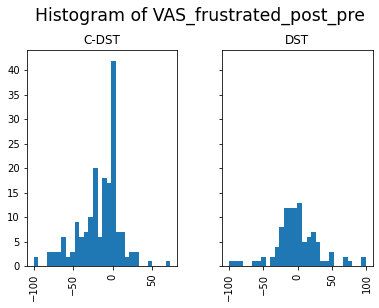

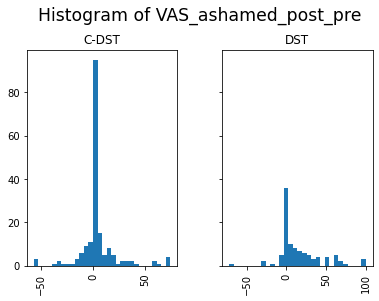

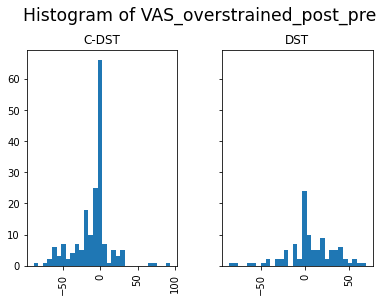

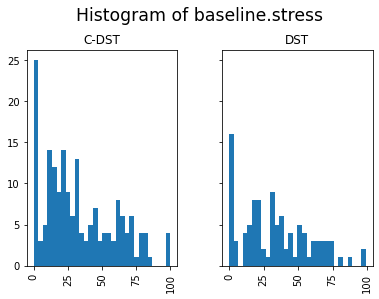

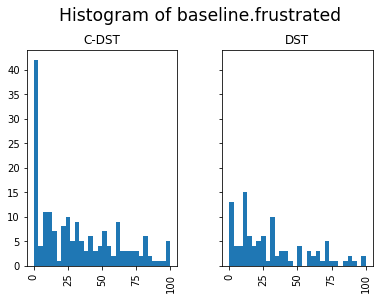

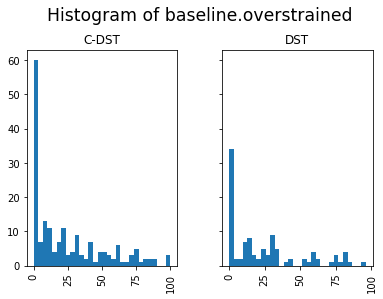

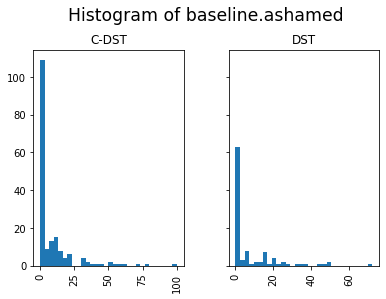

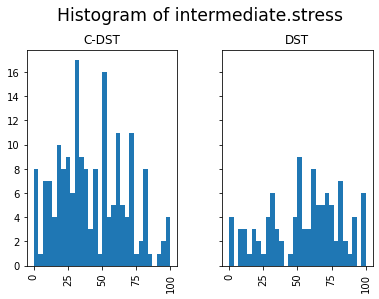

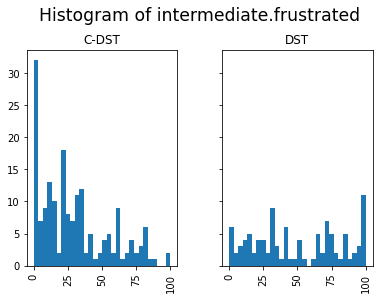

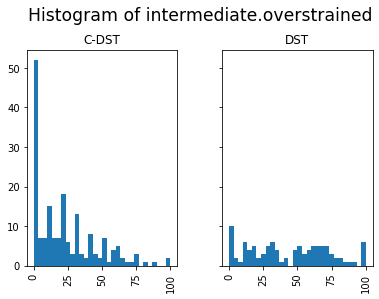

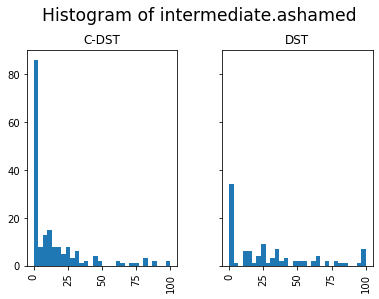

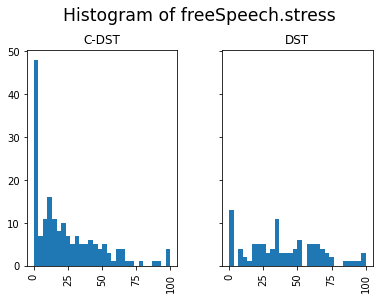

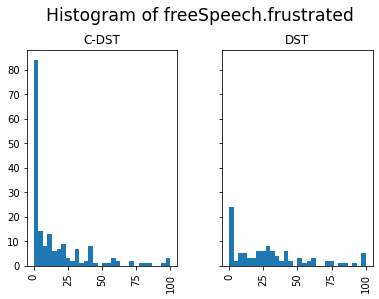

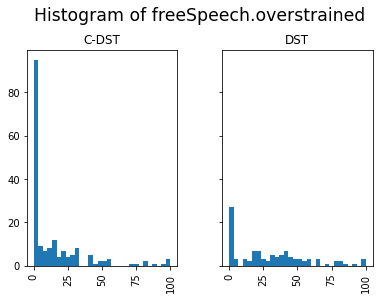

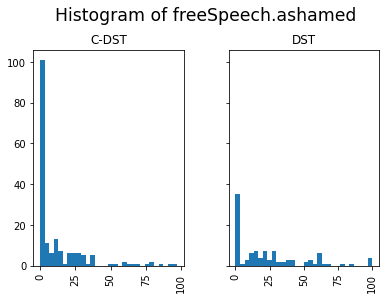

In [245]:
# view histograms to visually explore distribution between two tests
for query in queries:
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
    meta_completed.hist(by = "Condition", column = query, ax = axes, bins = 30)
    plt.suptitle("Histogram of " + query, x=0.5, y=1.05, ha='center', fontsize='xx-large')


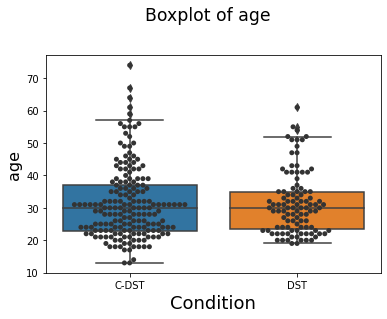

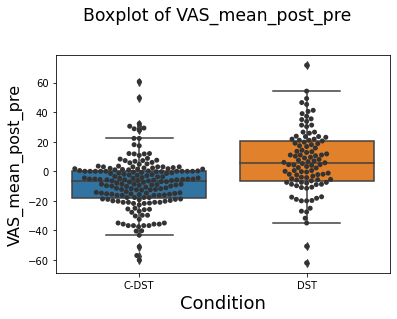

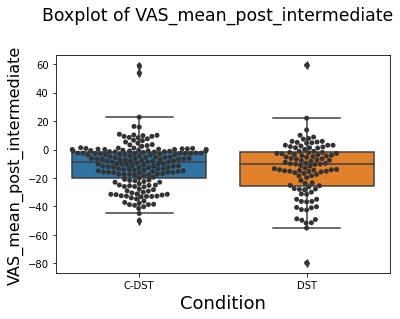

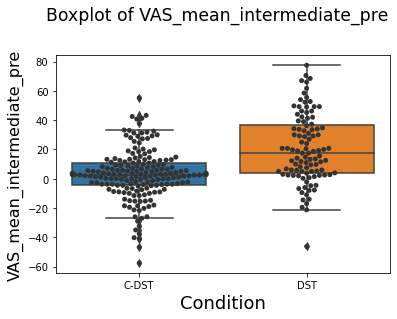

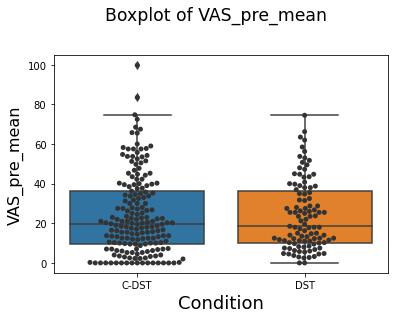

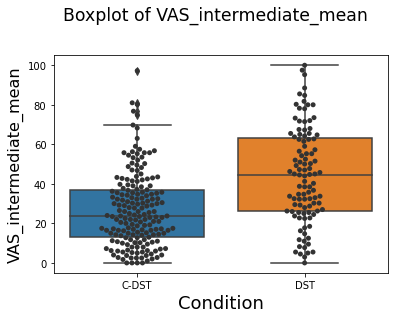

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


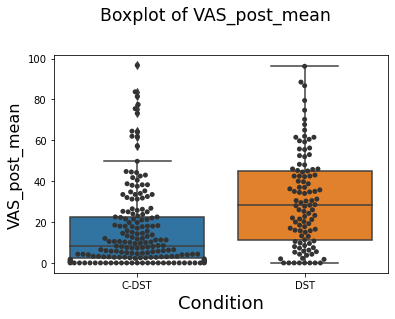

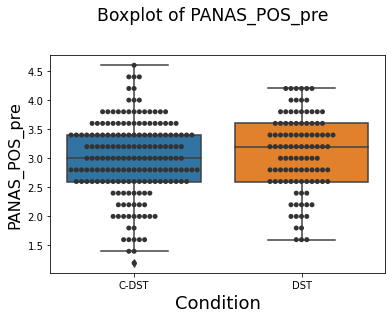

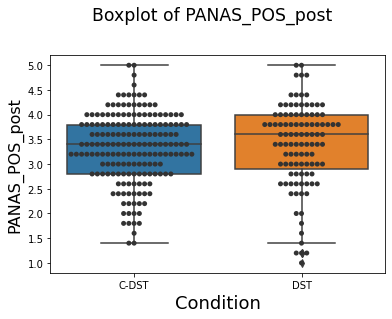

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


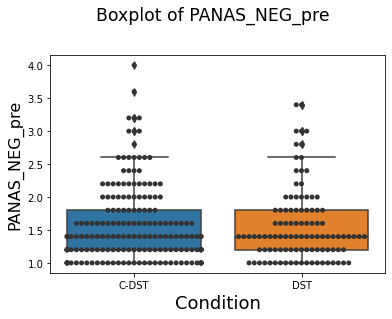

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


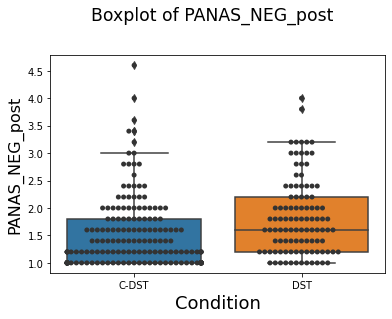

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


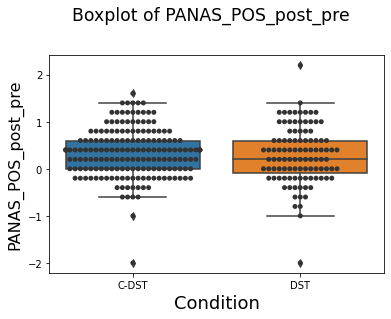

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


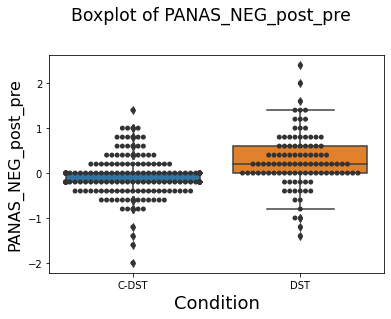

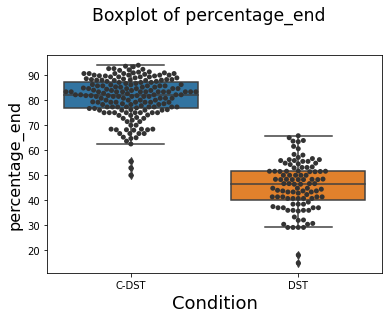

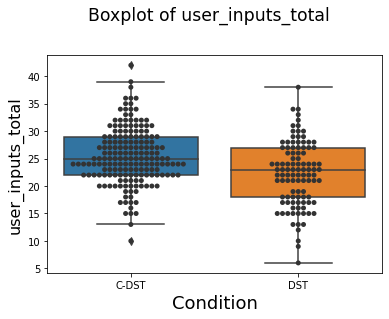

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


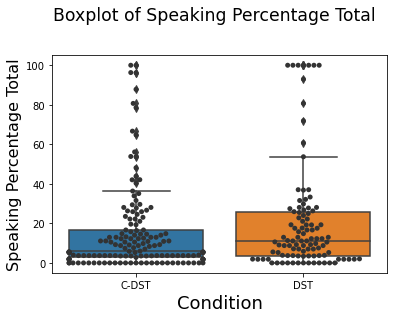

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


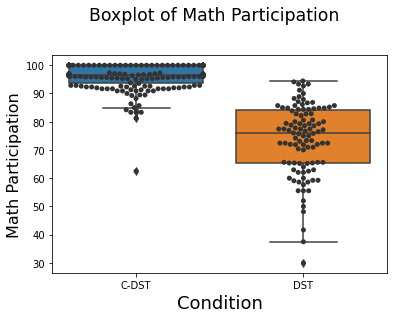

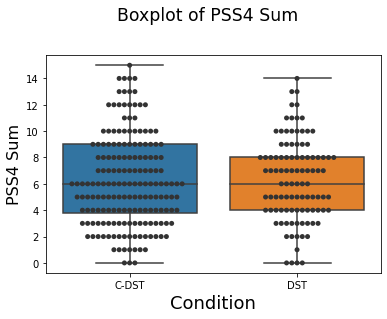

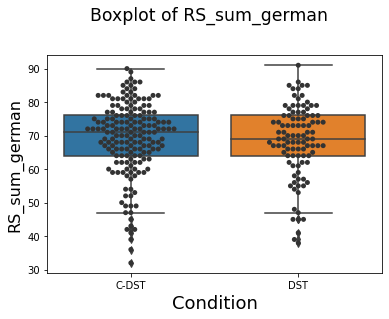

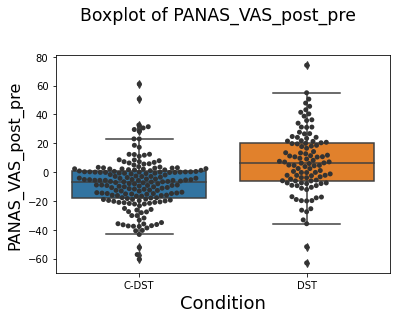

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


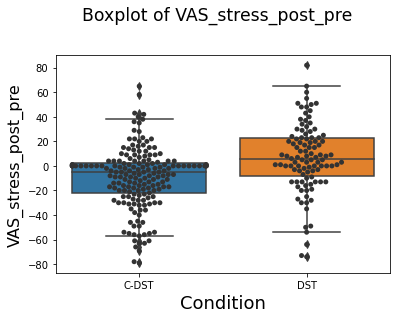

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


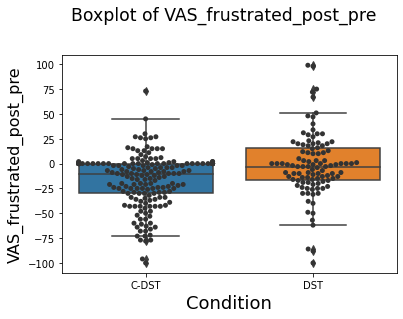

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


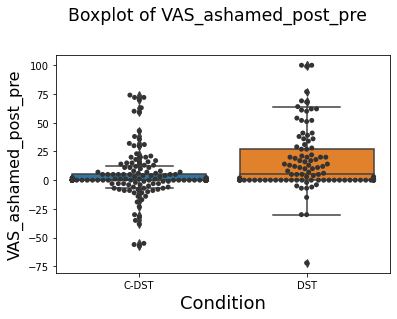

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


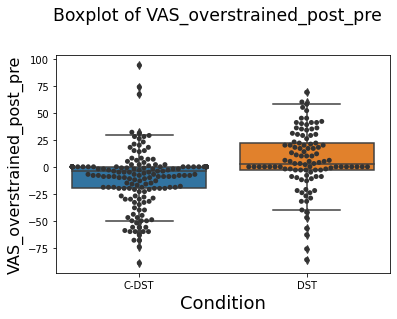

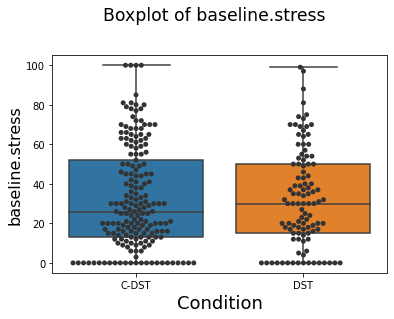

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


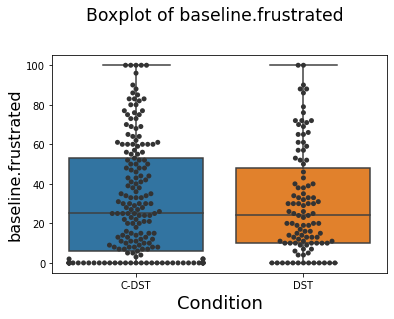

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


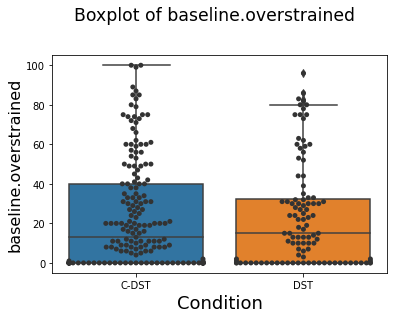

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 43.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


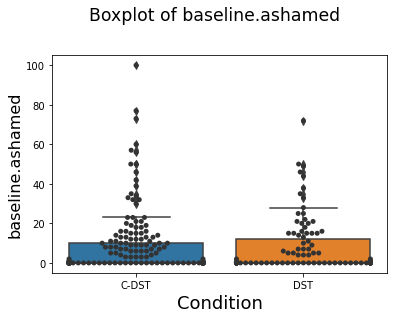

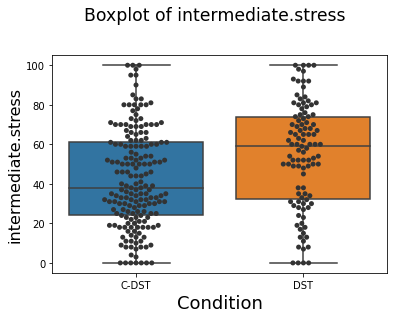

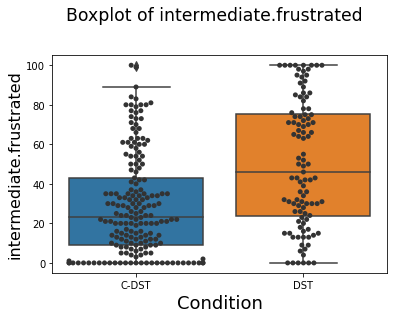

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


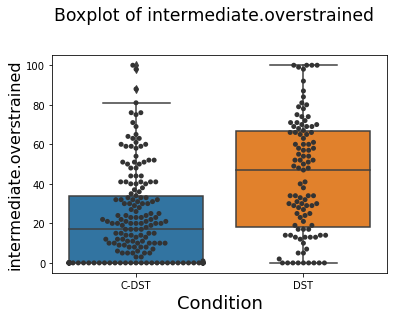

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 33.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


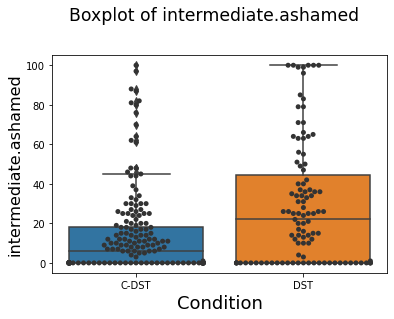

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


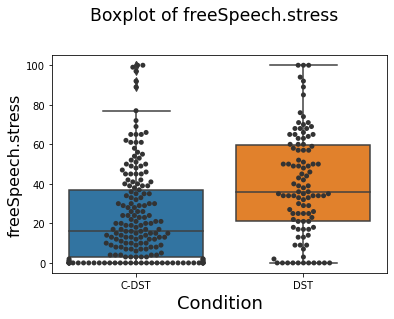

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


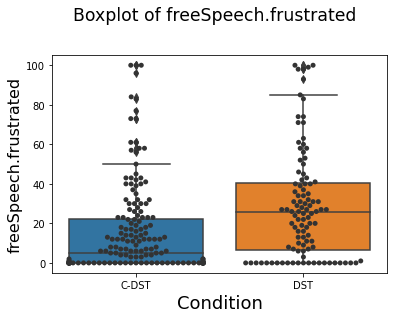

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


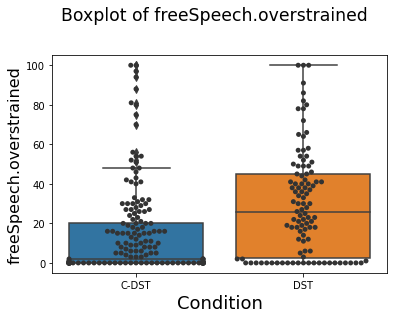

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


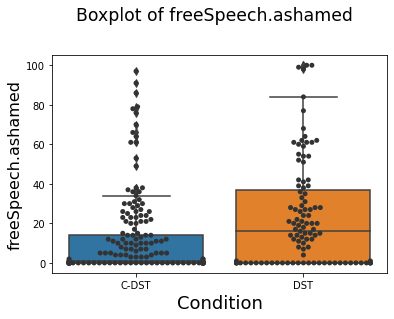

In [246]:
# visualize using boxplots
for query in queries:
    sns.boxplot(x='Condition', y= query, data = meta_completed)
    sns.swarmplot(x='Condition', y= query, data = meta_completed, color=".2")
    plt.suptitle("Boxplot of " + query, x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel("Condition", fontsize=18)
    plt.ylabel(query, fontsize=16)
    plt.show()

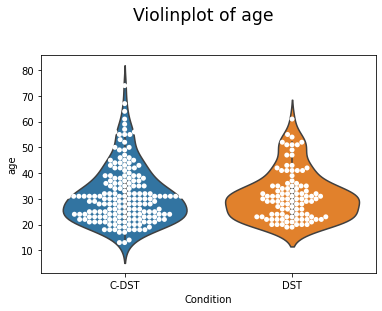

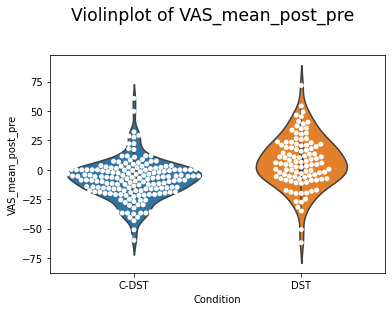

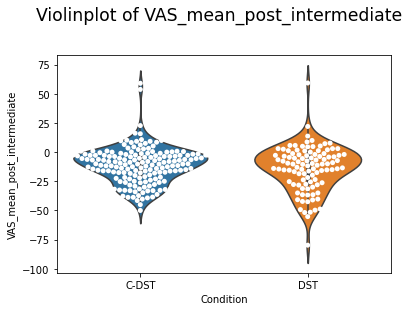

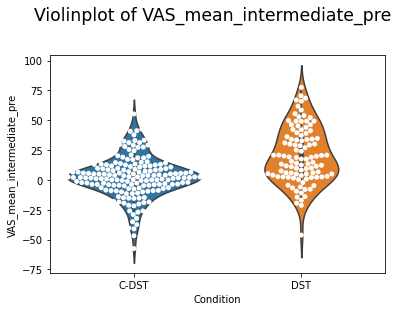

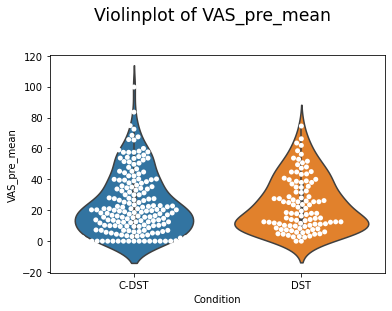

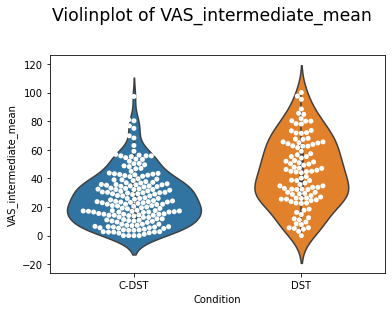

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


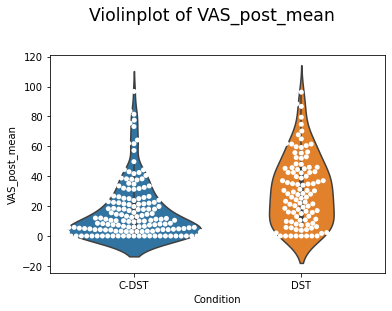

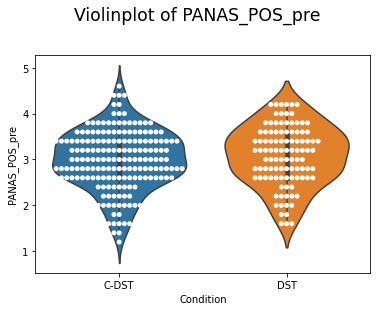

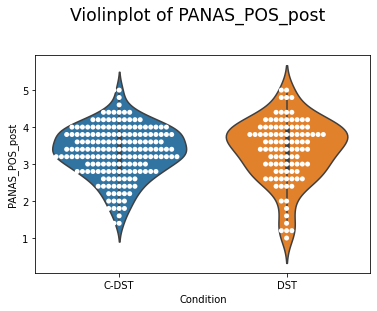

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


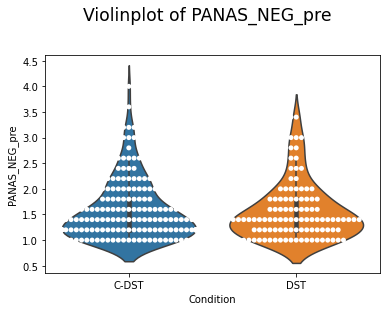

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


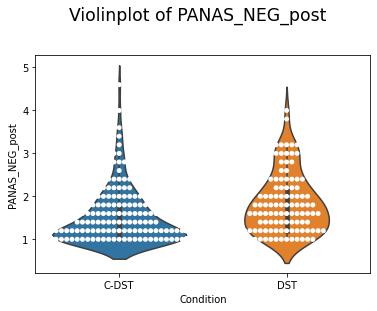

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


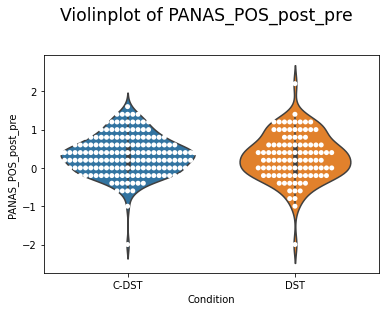

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


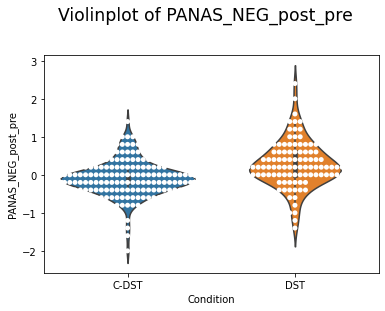

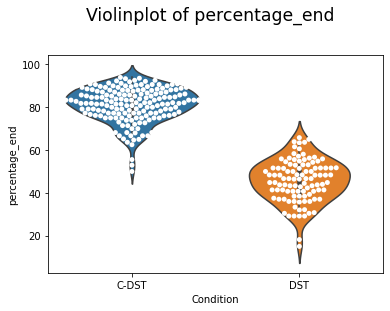

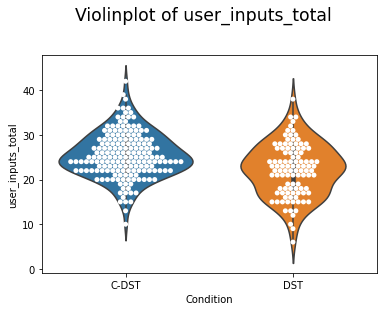

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


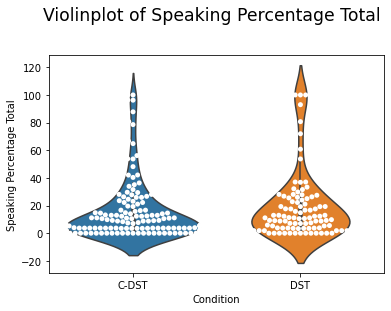

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 44.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


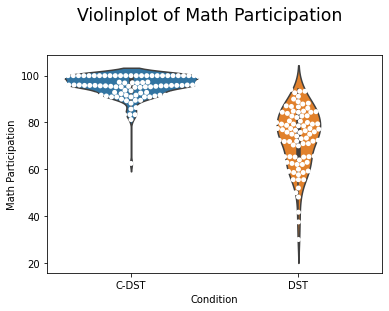

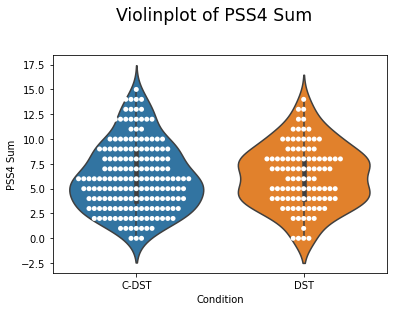

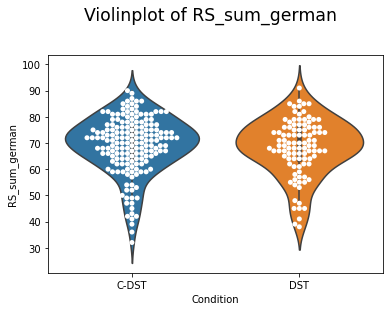

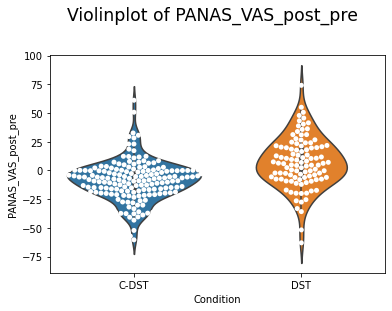

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


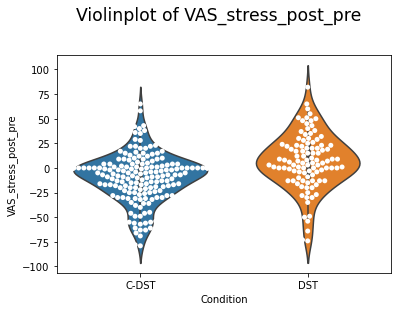

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


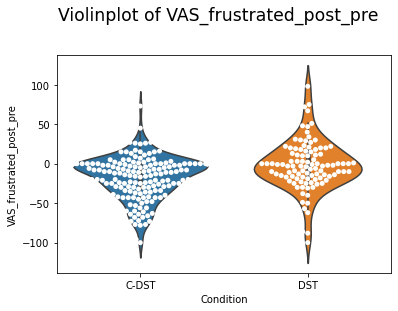

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


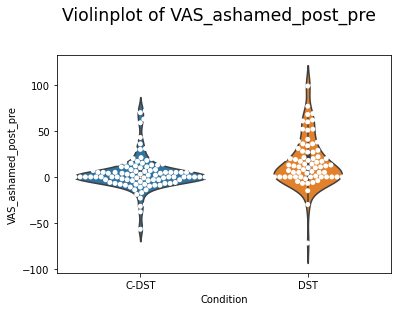

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


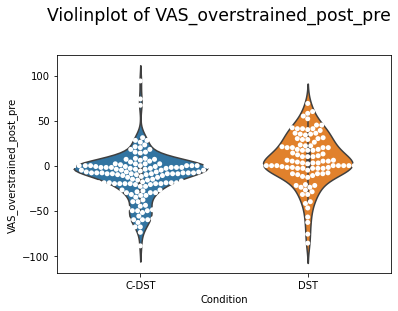

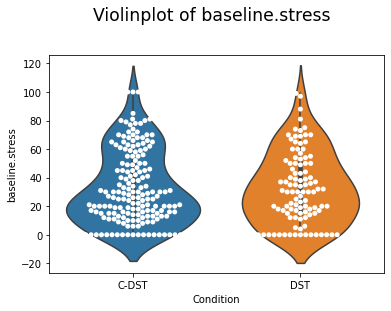

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


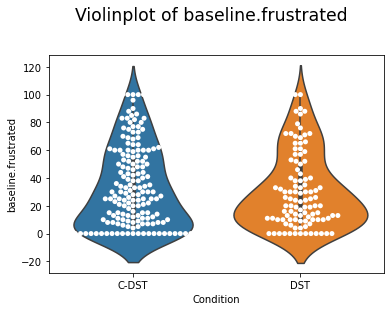

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


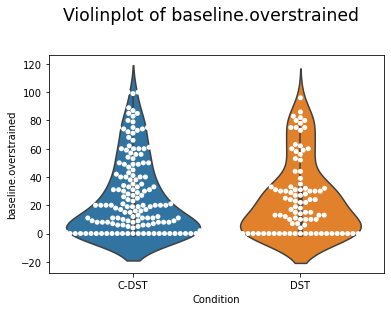

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 43.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


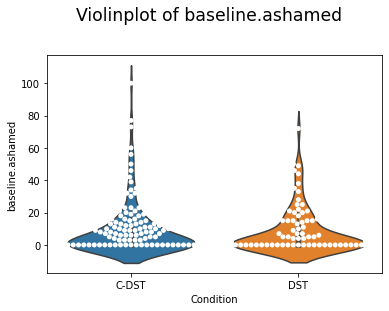

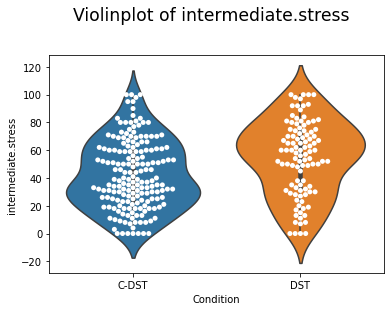

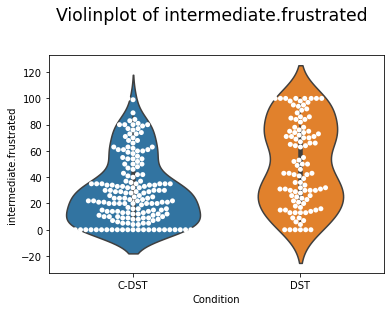

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


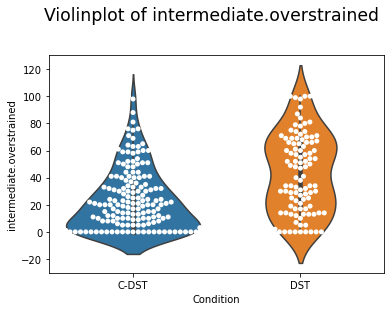

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


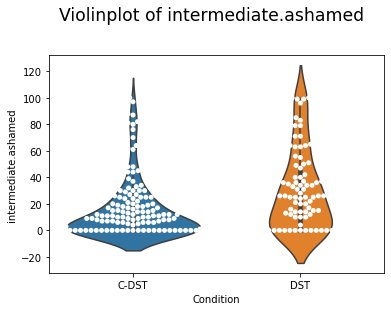

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


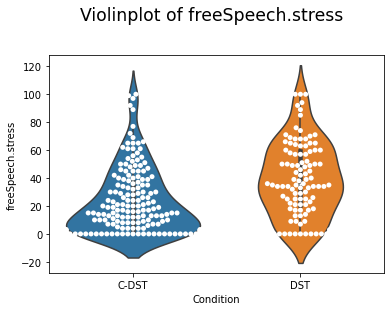

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


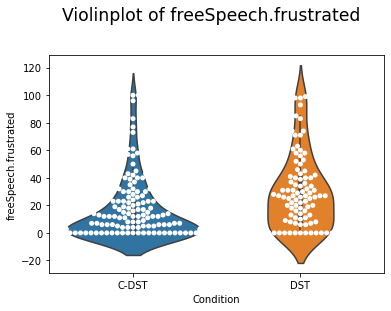

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 38.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


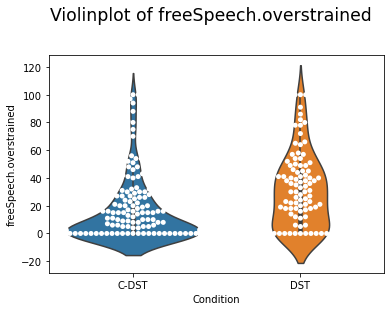

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


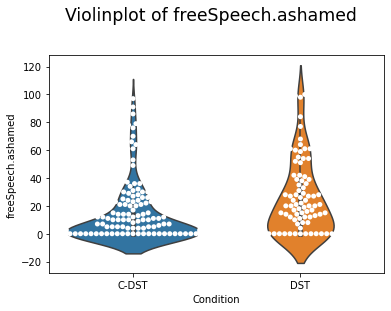

In [247]:
# visualize using swarmplots

for query in queries:
    sns.violinplot(x='Condition', y = query, data = meta_completed)
    sns.swarmplot(x='Condition', y = query, data = meta_completed,color="white", edgecolor="gray")
    plt.suptitle("Violinplot of " + query, x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.show()



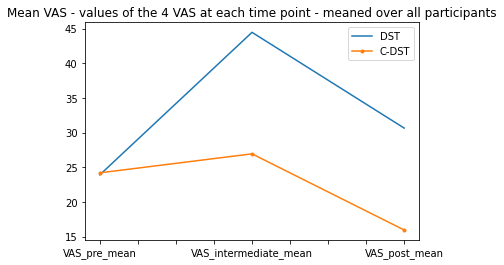

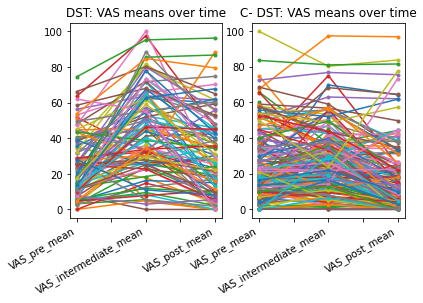

In [248]:
# mean VAS - visualization over all completed studies 
ax = meta_completed_dst.loc[:,"VAS_pre_mean":"VAS_post_mean"].mean().T.plot(legend = True)
meta_completed_cdst.loc[:,"VAS_pre_mean":"VAS_post_mean"].mean().T.plot(ax = ax, title = "Mean VAS - values of the 4 VAS at each time point - meaned over all participants", style='.-', legend = True)
ax.legend(["DST", "C-DST"])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, "VAS_pre_mean":"VAS_post_mean"].T.plot(ax = axes[0], title = "DST: VAS means over time", style='.-', legend = False)
meta_completed_cdst.loc[:, "VAS_pre_mean":"VAS_post_mean"].T.plot(ax = axes[1], title = "C- DST: VAS means over time", style='.-', legend = False)
fig.autofmt_xdate()
plt.show()

(-0.5, 2.8)

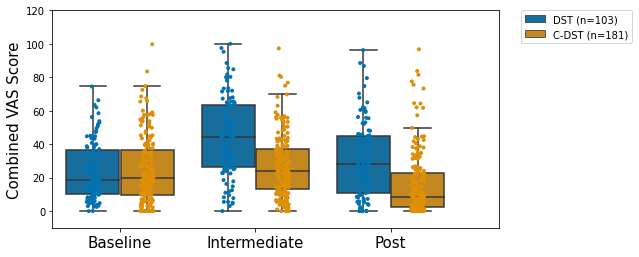

In [249]:
data = meta_completed[["Subject ID", "Condition", "VAS_pre_mean", "VAS_post_mean", "VAS_intermediate_mean"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"Combined VAS Score", "variable": "Time"}, inplace = True)
data.replace(["VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"], [0,1,2], inplace = True)

f = plt.figure(figsize=[8,4])
ax = f.add_subplot(111)

g = sns.boxplot(y = "Combined VAS Score", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "Combined VAS Score", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Intermediate','Post'], fontsize = 15)

g.set(xlabel=None)
ax.yaxis.label.set_size(15)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 120, ymin = -10)
plt.xlim(xmax=2.8)

#ax.legend_.remove()

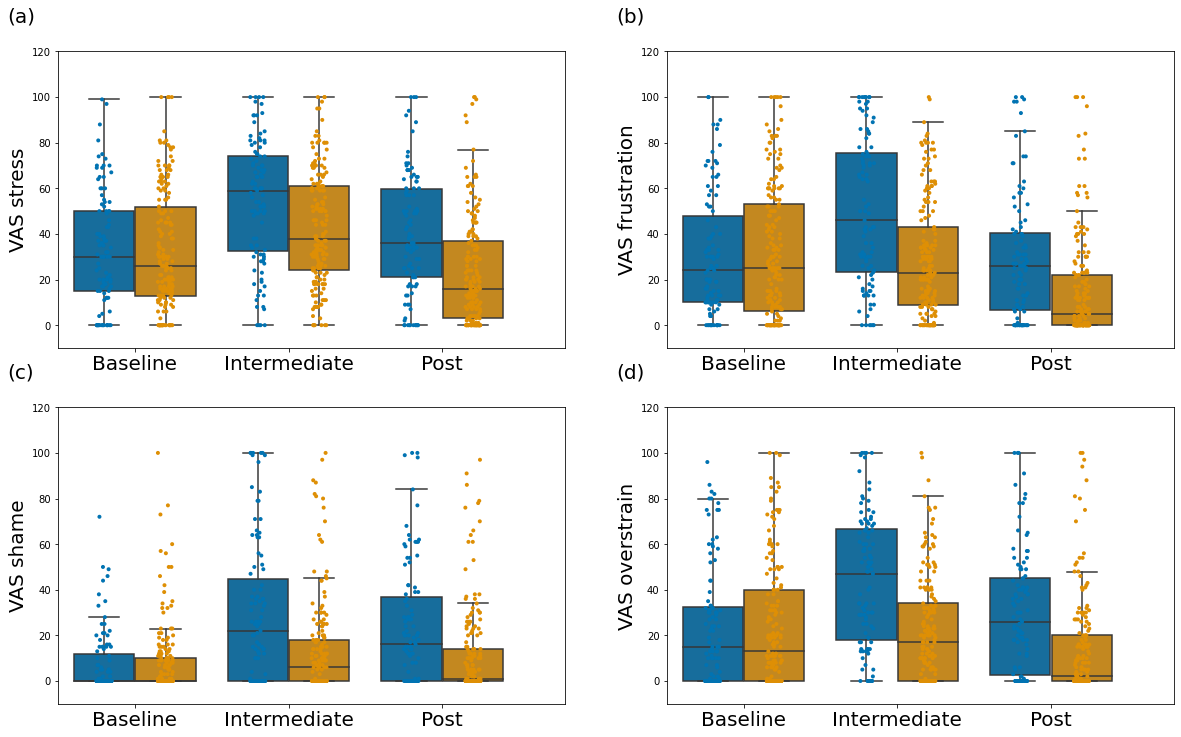

In [250]:
data = meta_completed[["Subject ID", "Condition", "baseline.stress", "intermediate.stress", "freeSpeech.stress"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS stress", "variable": "Time"}, inplace = True)
data.replace(["baseline.stress", "intermediate.stress", "freeSpeech.stress"], [0,1,2], inplace = True)

f = plt.figure(figsize=[20,12])
ax = f.add_subplot(221)

g = sns.boxplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Intermediate','Post'], fontsize = 20)

g.set(xlabel=None)
ax.yaxis.label.set_size(20)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 120, ymin = -10)
plt.xlim(xmax=2.8)
ax.legend_.remove()

ax.text(-0.1, 1.1, "(a)", transform=ax.transAxes, size=20)

##################

data = meta_completed[["Subject ID", "Condition", "baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS frustration", "variable": "Time"}, inplace = True)
data.replace(["baseline.frustration", "intermediate.frustration", "freeSpeech.frustration"], [0,1,2], inplace = True)

ax = f.add_subplot(222)

g = sns.boxplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Intermediate','Post'], fontsize = 20)

g.set(xlabel=None)
ax.yaxis.label.set_size(20)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 120, ymin = -10)
plt.xlim(xmax=2.8)
ax.text(-0.1, 1.1, "(b)", transform=ax.transAxes, size=20)
ax.legend_.remove()


###############

data = meta_completed[["Subject ID", "Condition", "baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS shame", "variable": "Time"}, inplace = True)
data.replace(["baseline.shame", "intermediate.shame", "freeSpeech.shame"], [0,1,2], inplace = True)

ax = f.add_subplot(223)

g = sns.boxplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Intermediate','Post'], fontsize = 20)

g.set(xlabel=None)
ax.yaxis.label.set_size(20)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 120, ymin = -10)
plt.xlim(xmax=2.8)
ax.text(-0.1, 1.1, "(c)", transform=ax.transAxes, size=20)
ax.legend_.remove()


###############

data = meta_completed[["Subject ID", "Condition", "baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS overstrain", "variable": "Time"}, inplace = True)
data.replace(["baseline.overstrain", "intermediate.overstrain", "freeSpeech.overstrain"], [0,1,2], inplace = True)

ax = f.add_subplot(224)

g = sns.boxplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Intermediate','Post'], fontsize = 20)

g.set(xlabel=None)
ax.yaxis.label.set_size(20)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 120, ymin = -10)
plt.xlim(xmax=2.8)
ax.text(-0.1, 1.1, "(d)", transform=ax.transAxes, size=20)
ax.legend_.remove()

Text(-0.1, 1.1, 'b)')

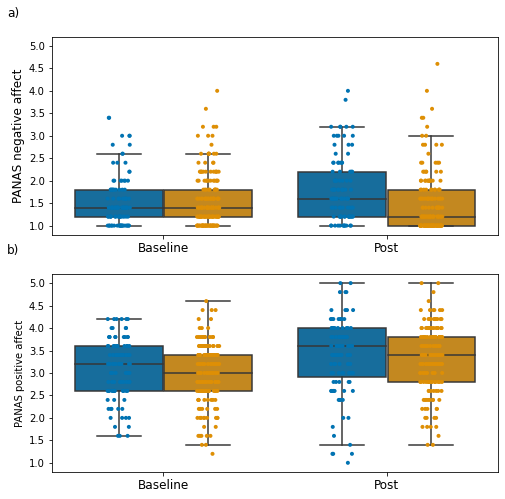

In [251]:


#####################################################################################

data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_pre", "PANAS_NEG_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS negative affect", "variable": "Time"}, inplace = True)
data.replace(["PANAS_NEG_pre", "PANAS_NEG_post"], [0,1], inplace = True)

f = plt.figure(figsize=[8,8])
ax = f.add_subplot(211)

g = sns.boxplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Post'], fontsize = 12)

g.set(xlabel=None)
ax.yaxis.label.set_size(12)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
#plt.ylim(ymax = 120, ymin = -10)
#plt.xlim(xmax=2.8)
ax.legend_.remove()

ax.text(-0.1, 1.1, "a)", transform=ax.transAxes, size=12)

##################


data = meta_completed[["Subject ID", "Condition", "PANAS_POS_pre", "PANAS_POS_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS positive affect", "variable": "Time"}, inplace = True)
data.replace(["PANAS_POS_pre", "PANAS_POS_post"], [0,1], inplace = True)

ax2 = f.add_subplot(212, sharey = ax)

g = sns.boxplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Post'], fontsize = 12)

g.set(xlabel=None)
ax.yaxis.label.set_size(12)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
#plt.ylim(ymax = 120, ymin = -10)
#plt.xlim(xmax=2.8)
ax2.legend_.remove()

ax2.text(-0.1, 1.1, "b)", transform=ax2.transAxes, size=12)



Text(-0.1, 1.1, '(b)')

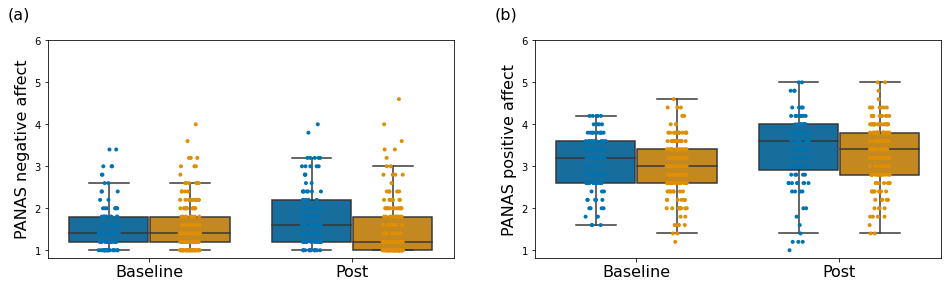

In [252]:


#####################################################################################

data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_pre", "PANAS_NEG_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS negative affect", "variable": "Time"}, inplace = True)
data.replace(["PANAS_NEG_pre", "PANAS_NEG_post"], [0,1], inplace = True)

f = plt.figure(figsize=[16,4])
ax = f.add_subplot(121)

g = sns.boxplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Post'], fontsize = 16)

g.set(xlabel=None)
ax.yaxis.label.set_size(16)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 6)
#plt.xlim(xmax=2.8)
ax.legend_.remove()

ax.text(-0.1, 1.1, "(a)", transform=ax.transAxes, size=16)

##################


data = meta_completed[["Subject ID", "Condition", "PANAS_POS_pre", "PANAS_POS_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS positive affect", "variable": "Time"}, inplace = True)
data.replace(["PANAS_POS_pre", "PANAS_POS_post"], [0,1], inplace = True)

ax2 = f.add_subplot(122, sharey = ax)

g = sns.boxplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, showfliers=False, hue_order = ["DST", "C-DST"])

g = sns.stripplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, dodge = True, size = 4, hue_order = ["DST", "C-DST"])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set_xticklabels(['Baseline','Post'], fontsize = 16)

g.set(xlabel=None)
ax2.yaxis.label.set_size(16)
l.get_texts()[0].set_text('DST (n=103)')
l.get_texts()[1].set_text('C-DST (n=181)')
plt.ylim(ymax = 6)
#plt.xlim(xmax=2.8)
ax2.legend_.remove()

ax2.text(-0.1, 1.1, "(b)", transform=ax2.transAxes, size=16)


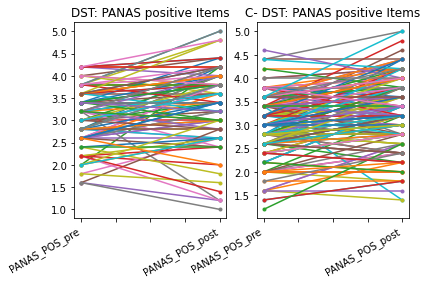

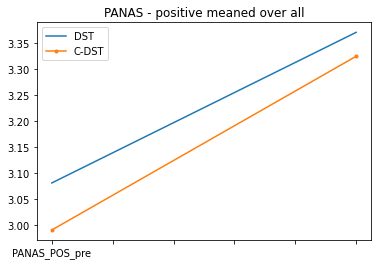

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


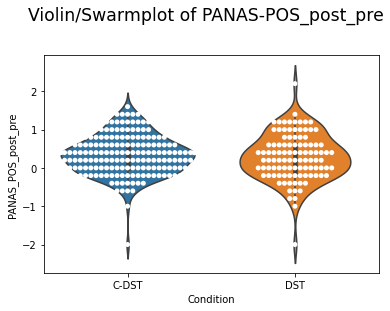

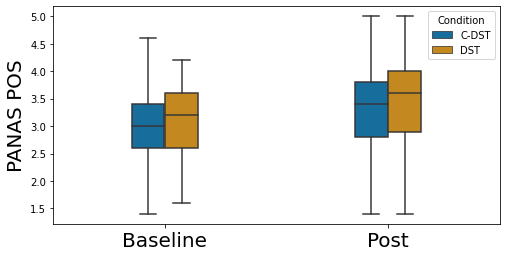

In [253]:

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["PANAS_POS_pre", "PANAS_POS_post"]].T.plot(ax = axes[0], title = "DST: PANAS positive Items", style='.-', legend = False)
meta_completed_cdst.loc[:,["PANAS_POS_pre", "PANAS_POS_post"]].T.plot(ax = axes[1], title = "C- DST: PANAS positive Items", style='.-',  legend = False)
fig.autofmt_xdate()
plt.show()

ax = meta_completed_dst.loc[:, ["PANAS_POS_pre", "PANAS_POS_post"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:, ["PANAS_POS_pre", "PANAS_POS_post"]].mean().T.plot(ax = ax, title = "PANAS - positive meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

sns.violinplot(x='Condition', y = "PANAS_POS_post_pre", data = meta_completed)
sns.swarmplot(x='Condition', y = "PANAS_POS_post_pre", data = meta_completed,color="white", edgecolor="gray")
plt.suptitle("Violin/Swarmplot of " + "PANAS-POS_post_pre", x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()


data = meta_completed[["Subject ID", "Condition", "PANAS_POS_pre", "PANAS_POS_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS POS", "variable": "Time"}, inplace = True)
data.replace(["PANAS_POS_pre", "PANAS_POS_post"], [0,1], inplace = True)

f = plt.figure(figsize=[8,4])
ax = f.add_subplot(111)


g = sns.boxplot(y = "PANAS POS", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, width=0.3, showfliers=False)
g.set_xticklabels(['Baseline','Post'], fontsize = 20)
g.set(xlabel=None)
ax.yaxis.label.set_size(20)

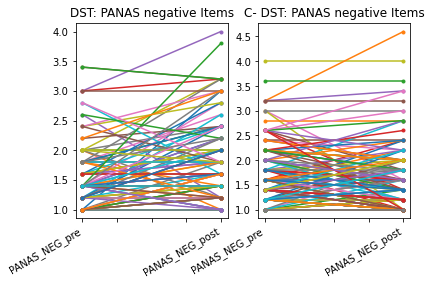

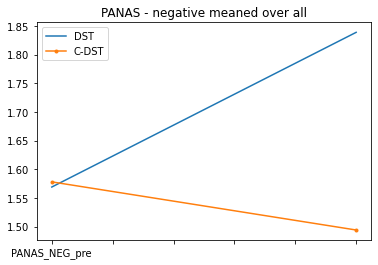

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


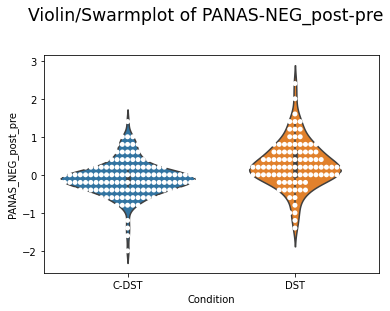

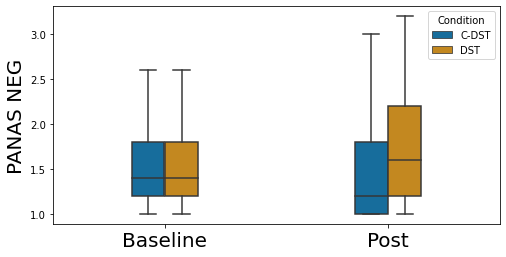

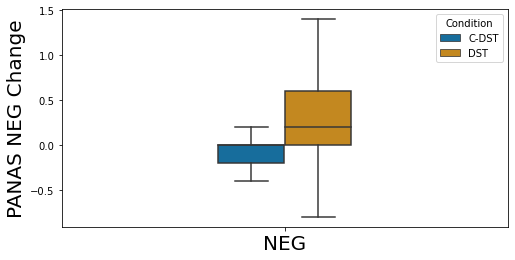

In [254]:
# PANAS - negative items visualization and comparison

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["PANAS_NEG_pre", "PANAS_NEG_post"]].T.plot(ax = axes[0], title = "DST: PANAS negative Items", style='.-', legend = False)
meta_completed_cdst.loc[:,["PANAS_NEG_pre", "PANAS_NEG_post"]].T.plot(ax = axes[1], title = "C- DST: PANAS negative Items", style='.-',  legend = False)
fig.autofmt_xdate()
plt.show()

############################
ax = meta_completed_dst.loc[:, ["PANAS_NEG_pre", "PANAS_NEG_post"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:, ["PANAS_NEG_pre", "PANAS_NEG_post"]].mean().T.plot(ax = ax, title = "PANAS - negative meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

############################
sns.violinplot(x='Condition', y = "PANAS_NEG_post_pre", data = meta_completed)
sns.swarmplot(x='Condition', y = "PANAS_NEG_post_pre", data = meta_completed,color="white", edgecolor="gray")
plt.suptitle("Violin/Swarmplot of " + "PANAS-NEG_post-pre", x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

############################
data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_pre", "PANAS_NEG_post"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS NEG", "variable": "Time"}, inplace = True)

f = plt.figure(figsize=[8,4])
ax = f.add_subplot(111)

#############################
g = sns.boxplot(y = "PANAS NEG", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, width=0.3, showfliers=False)
g.set_xticklabels(['Baseline','Post'], fontsize = 20)
g.set(xlabel=None)
ax.yaxis.label.set_size(20)

#############################
data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS NEG Change", "variable": "Time"}, inplace = True)
data.replace(["PANAS_NEG_pre", "PANAS_NEG_post"], [0,1], inplace = True)
f = plt.figure(figsize=[8,4])
ax = f.add_subplot(111)


g = sns.boxplot(y = "PANAS NEG Change", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax, width=0.3, showfliers=False)
g.set_xticklabels(['NEG'], fontsize = 20)
g.set(xlabel=None)
ax.yaxis.label.set_size(20)



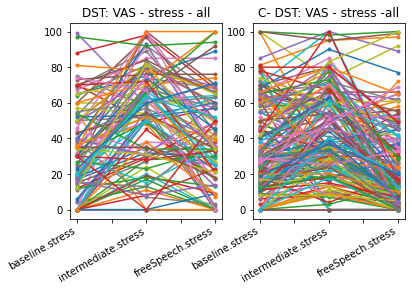

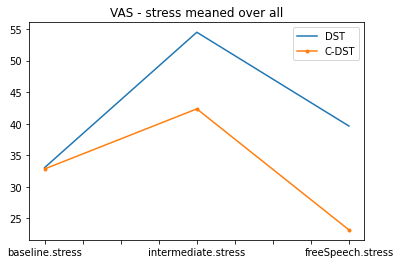

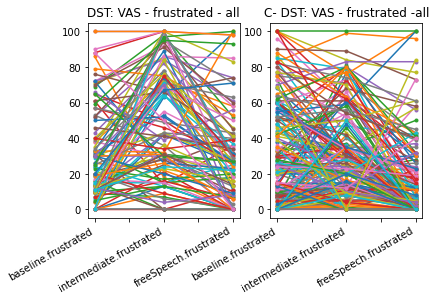

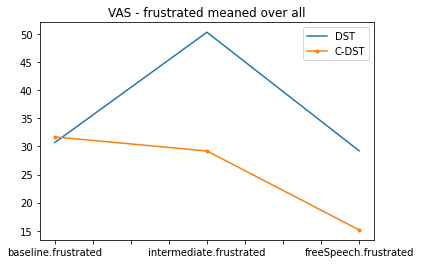

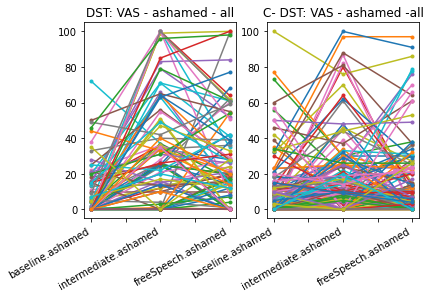

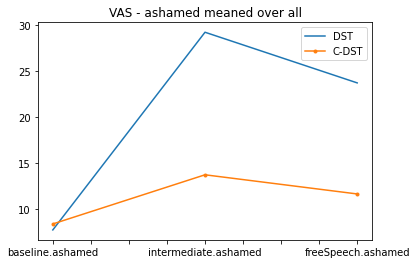

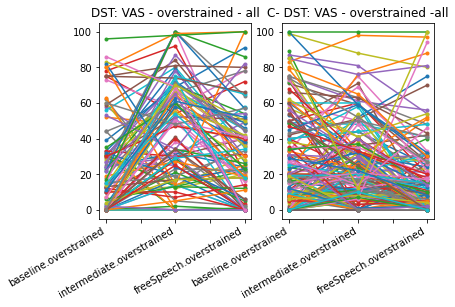

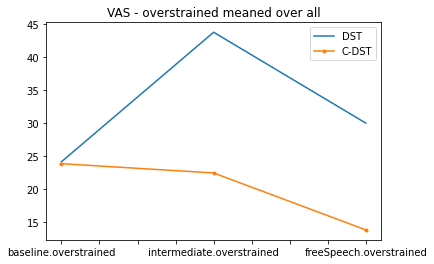

In [255]:
# VAS-visualizations and comparison for every VAS, i.e. "stress", "frustrated", "ashamed", "overstrained"

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["baseline.stress", "intermediate.stress", "freeSpeech.stress"]].T.plot(ax = axes[0], title = "DST: VAS - stress - all", style='.-', legend = False)
meta_completed_cdst.loc[:, ["baseline.stress", "intermediate.stress", "freeSpeech.stress"]].T.plot(ax = axes[1], title = "C- DST: VAS - stress -all", style='.-', legend = False)
fig.autofmt_xdate()
plt.show()

ax = meta_completed_dst.loc[:, ["baseline.stress", "intermediate.stress", "freeSpeech.stress"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:, ["baseline.stress", "intermediate.stress", "freeSpeech.stress"]].mean().T.plot(ax = ax, title = "VAS - stress meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]].T.plot(ax = axes[0], title = "DST: VAS - frustrated - all", style='.-', legend = False)
meta_completed_cdst.loc[:, ["baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]].T.plot(ax = axes[1], title = "C- DST: VAS - frustrated -all", style='.-', legend = False)
fig.autofmt_xdate()
plt.show()

ax = meta_completed_dst.loc[:, ["baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:,["baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]].mean().T.plot(ax = ax, title = "VAS - frustrated meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]].T.plot(ax = axes[0], title = "DST: VAS - ashamed - all", style='.-', legend = False)
meta_completed_cdst.loc[:, ["baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]].T.plot(ax = axes[1], title = "C- DST: VAS - ashamed -all", style='.-', legend = False)
fig.autofmt_xdate()
plt.show()

ax = meta_completed_dst.loc[:, ["baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:, ["baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]].mean().T.plot(ax = ax, title = "VAS - ashamed meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
meta_completed_dst.loc[:, ["baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]].T.plot(ax = axes[0], title = "DST: VAS - overstrained - all", style='.-', legend = False)
meta_completed_cdst.loc[:, ["baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]].T.plot(ax = axes[1], title = "C- DST: VAS - overstrained -all", style='.-', legend = False)
fig.autofmt_xdate()
plt.show()

ax = meta_completed_dst.loc[:, ["baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]].mean().T.plot(legend = True)
ax = meta_completed_cdst.loc[:, ["baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]].mean().T.plot(ax = ax, title = "VAS - overstrained meaned over all", style='.-')
ax.legend(["DST", "C-DST"])
plt.show()

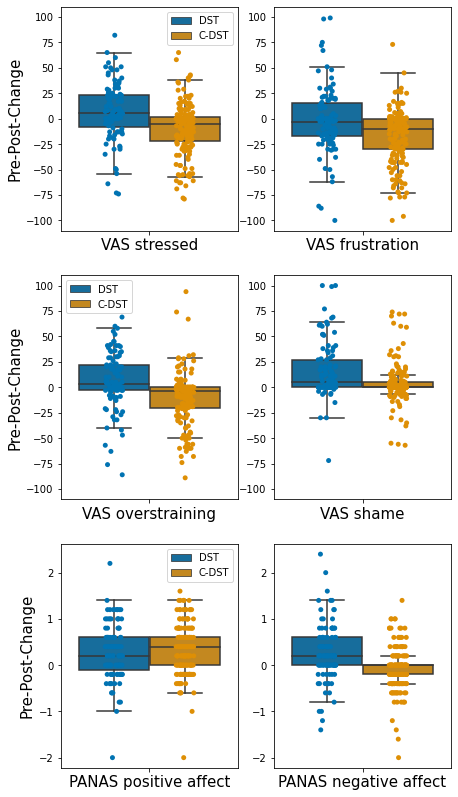

In [256]:
# compare the changes of DST and C-DST

data = meta_completed[["Subject ID", "Condition", "VAS_stress_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS stress", "variable": "Time"}, inplace = True)
f = plt.figure(figsize=[7,14])


ax1 = f.add_subplot(321)

g = sns.boxplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax1, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax1, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS stressed'], fontsize = 15)
g.set(xlabel=None)
ax1.set_ylabel("Pre-Post-Change", fontsize = 15)

handles, labels = ax1.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

#######################
data = meta_completed[["Subject ID", "Condition", "VAS_frustrated_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS frustration", "variable": "Time"}, inplace = True)
ax2 = f.add_subplot(322, sharey = ax1)


g = sns.boxplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS frustration'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

handles, labels = ax2.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()
######################
data = meta_completed[["Subject ID", "Condition", "VAS_overstrained_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS overstrain", "variable": "Time"}, inplace = True)
ax3 = f.add_subplot(323, sharey = ax1)

ax3.set_ylabel("Pre-Post-Change", fontsize = 15)

g = sns.boxplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax3, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax3, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS overstraining'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel="Pre-Post-Change")

handles, labels = ax3.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
######################
data = meta_completed[["Subject ID", "Condition", "VAS_ashamed_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS shame", "variable": "Time"}, inplace = True)
ax4 = f.add_subplot(324, sharey = ax1)


g = sns.boxplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax4, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax4, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS shame'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()
######################
data = meta_completed[["Subject ID", "Condition", "PANAS_POS_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS positive affect", "variable": "Time"}, inplace = True)
ax5 = f.add_subplot(325)


g = sns.boxplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax5, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax5, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['PANAS positive affect'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

ax5.set_ylabel("Pre-Post-Change", fontsize = 15)

handles, labels = ax5.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
####################
data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS negative affect", "variable": "Time"}, inplace = True)
ax6 = f.add_subplot(326, sharey = ax5)


g = sns.boxplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax6, hue_order = ["DST", "C-DST"], showfliers=False)

g = sns.stripplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax6, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['PANAS negative affect'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

handles, labels = ax6.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()



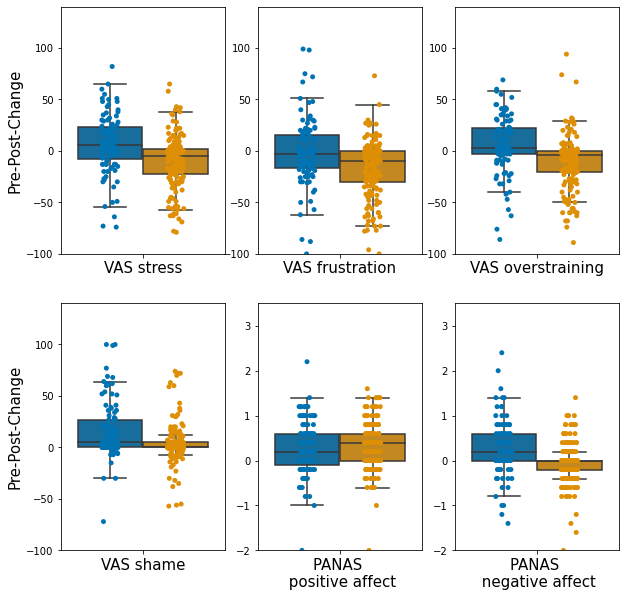

In [257]:
# visualize the change of VAS-subscales using boxplots
# compare the changes of DST and C-DST

data = meta_completed[["Subject ID", "Condition", "VAS_stress_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS stress", "variable": "Time"}, inplace = True)
f = plt.figure(figsize=[10,10])


ax1 = f.add_subplot(231)
ax1.set_ylim([-100, 140])
g = sns.boxplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax1, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "VAS stress", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax1, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS stress'], fontsize = 15)
g.set(xlabel=None)
ax1.set_ylabel("Pre-Post-Change", fontsize = 15)
handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()

#######################
data = meta_completed[["Subject ID", "Condition", "VAS_frustrated_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS frustration", "variable": "Time"}, inplace = True)
ax2 = f.add_subplot(232, sharey = ax1)


g = sns.boxplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "VAS frustration", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax2, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS frustration'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)
handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()
######################
data = meta_completed[["Subject ID", "Condition", "VAS_overstrained_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS overstrain", "variable": "Time"}, inplace = True)
ax3 = f.add_subplot(233, sharey = ax1)

ax3.set_ylabel("Pre-Post-Change", fontsize = 15)

g = sns.boxplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax3, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "VAS overstrain", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax3, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS overstraining'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)
handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()
######################
data = meta_completed[["Subject ID", "Condition", "VAS_ashamed_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS shame", "variable": "Time"}, inplace = True)
ax4 = f.add_subplot(234, sharey = ax1)


g = sns.boxplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax4, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "VAS shame", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax4, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['VAS shame'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel="Pre-Post-Change")
ax4.set_ylabel("Pre-Post-Change", fontsize = 15)
handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()
######################
data = meta_completed[["Subject ID", "Condition", "PANAS_POS_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS positive affect", "variable": "Time"}, inplace = True)
ax5 = f.add_subplot(235)
ax5.set_ylim([-2,+3.5])

g = sns.boxplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax5, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "PANAS positive affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax5, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['PANAS \n positive affect'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()

#######################
data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_post_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"PANAS negative affect", "variable": "Time"}, inplace = True)
ax6 = f.add_subplot(236, sharey = ax5)


g = sns.boxplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax6, hue_order = ["DST", "C-DST"], showfliers=False)
g = sns.stripplot(y = "PANAS negative affect", x = "Time", data = data, 
                palette = "colorblind", hue = "Condition", 
                ax = ax6, hue_order = ["DST", "C-DST"], dodge = True)
g.set_xticklabels(['PANAS \n negative affect'], fontsize = 15)
g.set(xlabel=None)
g.set(ylabel=None)

handles, labels = ax4.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])
g.legend_.remove()



In [258]:
DST_queries = []
C_DST_queries = []

for query in queries:
    DST_queries.append(meta_completed.query('Condition == "DST"')[query])
    C_DST_queries.append(meta_completed.query('Condition == "C-DST"')[query])



In [ ]:
# shapiro-wilk test for normal distribution of data

for counter, query in enumerate(DST_queries):
    shapiro_values = scipy.stats.shapiro(query)
    
    if shapiro_values[1] < 0.05:
        print("DST: Shapiro-Wilk for ", queries[counter],":", shapiro_values)
        print(queries[counter] + " does not fulfill the normality assumption")

for counter, query in enumerate(C_DST_queries):
    shapiro_values = scipy.stats.shapiro(query)
    
    if shapiro_values[1] < 0.05:
        print("C-DST: Shapiro-Wilk for ", queries[counter],":", shapiro_values)
        print(queries[counter] + " does not fulfill the normality assumption")


In [ ]:
# levene-wilk test for homogeneity of variances of data
for counter in range(len(DST_queries)):
    levene_values = scipy.stats.levene(DST_queries[counter], C_DST_queries[counter])
    print("Levene - Result for ", queries[counter],":", levene_values)
    if levene_values[1] < 0.05:
        print(queries[counter] + " does not fulfill Homogeneity of Variances assumption")

# Statistical Testing

## Welch's T-Tests for the Comparison of VAS / PANAS between groups at different time points
We used Welch's because of differing sample sizes and robustness against normality assumption for larger sample sizes.

In [ ]:
from math import sqrt
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    t, p = stats.ttest_ind(x, y, equal_var = False)
    d = (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)
    t = abs(t)
    data = {'t': t, 'p-val': p, 'dof': dof, 'cohen_d' : d}

    t_test_table = pd.DataFrame(data, index = [0])
    return t_test_table

In [ ]:
# Welchs t-tests 

for counter in range(len(DST_queries)):
    pg.ttest(DST_queries[counter], C_DST_queries[counter], correction = True)
    #t_test = welch_ttest(DST_queries[counter], C_DST_queries[counter])
    t_test_table = t_test.style.set_caption("T-Test for " + queries[counter])
    display(meta_completed[[queries[counter], "Condition"]].groupby("Condition").describe())
    display(t_test_table)
    
    if t_test["p-val"][0] < 0.05:
        print(queries[counter] + " shows significant differences in the means between DST and C-DST according to t-test.") 
    print("-----------------------------")

## Mann-Whitney-U-tests for comparison due to normality-violation

In [ ]:
# Mann-Whitney-U-tests with pingouin for more information

for counter in range(len(DST_queries)):
    u_test = pg.mwu(DST_queries[counter], C_DST_queries[counter], alternative = "two-sided")
    u_test_table = u_test.style.set_caption("U-Test for " + queries[counter])
    display(meta_completed[[queries[counter], "Condition"]].groupby("Condition").describe())
    display("Medians:", meta_completed[[queries[counter], "Condition"]].groupby("Condition").median())
    display(u_test_table)
    
    if u_test["p-val"][0] < 0.05:
        print(queries[counter] + " shows significant differences in the means between DST and C-DST according to U-test.") 
    print("-----------------------------")

## Repeated Measures ANOVA for affective responses comparison between groups

### General Considerations:

We have to decide which way we want to go in the ongoing debate between the use of ANCOVA, change scores or repeated measures ANOVA for pre-post designs (as in our case for PANAS and also VAS pre-post). 
Generally we are randomizing the subjects to one of the conditions, i.e. the baseline should be normally distributed for both groups. 
We could use ANCOVA on the post test values, adjusting for the baseline as covariate. ANCOVA is kind of a regression model (follow up score=constant+a×baseline score+b×group) adjusted for the baseline.
So the results of implemented ANCOVA (using pingouin or statsmodels ols regression or statsmodels linear mixed models) lead to the same results.

The repeated measures ANOVA is more focusing on changes between the groups. In this case, the interaction effect for CONDITIONxTIME is what we're interested in. Main Group Effects for CONDITION and TIME "should" not differ between the groups. 
Using the repeated measures ANOVA for a simple pre-post design would lead to the same p-value for the interaction as the classical t-test for the change scores. 

The ANCOVA approach is testing post-value differences adjusted for the baseline. For a randomized study this should yield the same results as the repeated measures ANOVA while here the Group effect for CONDITION is what we're interested in.  
The posthoc t-test would show differences in the post-values only (same as plain post-value t-test comparison) and therefore not be used.

However, we're interested in changes over time between the two groups and as the groups are randomized to the conditions, a repeated measures ANOVA is reasonable. We will use the F-value and the degrees of freedom as well as the uncorr. p-value for the paper: F(DG1/DG2) = XY (p=XY) and np2 (epsilon effect size).
The ANOVA post-hoc tests are not useful for a two groups pre-post design.


HANNA to the use of ANOVA (which is not accouting for the baseline "height"): 
Eigentlich ist es voll die interessante konzeptionelle Frage: einerseits kann man sagen, dass ein Change von 3 auf 4 nicht vergleichbar ist mit einem change von 6 auf 7. Anderseits kann man auch sagen, doch, dass ist genau das, was uns hier interessiert, ob wir, ausgehend von ihrem Grundstressgefühl schaffen einen bestimmten Anstieg zu induzieren 🙂

### For more than one follow-up measure (VAS):

To evaluate the overall effect, we can do the same mixed ANOVA as for PANAS or also the t-test on pre-post change scores which is equivalent.

However, for the VAS we also have an intermediate value, therefore we could use the repeated measures ANOVA with 3 time points, interpreting the TIME x CONDITION interaction and post-hoc compare different time points. 

To compare the two tasks we could also do mixed ANOVAs (or t-test changes) for pre-intermediate and intermediate-post values and look at the interaction effects.

Hanna on the "regression to the mean problem":

Bei Intermediate-Post haben wir natürlich nicht gleiche Baselines...aber wir sind konservativ, also wir unterschätzen voraussichtlich den Effekt...und wollen ja wissen, bringt es uns dann noch einen weiteren Zugewinn an Stress. 


## PANAS ANOVA 
=> Bonferroni-corrected PostHocs, Auto-Correction for Sphericity using Greenhouse-Geissler 


In [ ]:
# repeated measures ANOVA for groups (DST vs. C-DST) and PANAS - means at different time points (pre vs. post)

# prepare dataframe to have a grouping column for the panas score

anova_df = meta_completed[["Subject ID", "PANAS_NEG_post", "Condition", "PANAS_NEG_pre"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
anova_df.replace(["PANAS_NEG_pre", "PANAS_NEG_post"],[0.0, 1.0], inplace = True)
anova_df.rename(columns = {"value": "PANAS Score", "variable": "PANAS time"}, inplace = True)

# Compute the two-way mixed-design ANOVA with pingouin (mixed ANOVAs not fully implemented in statsmodels, i.e.
## if there is more than one measuremeant)
aov = pg.mixed_anova(dv='PANAS Score', within='PANAS time', between='Condition', 
                     subject='Subject ID', data=anova_df, correction = "auto")

posthocs = pg.pairwise_ttests(dv='PANAS Score', within='PANAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=anova_df,padjust = "bonf",
                              return_desc = True)

effect_size_dst_neg = aov.np2[2]

print("This is repeated measures (mixed) ANOVA for PANAS NEGATIVE affect:")
display(aov)
print("POSTHOCS:")
display(posthocs)
print("------------------------------------------")

anova_df = meta_completed[["Subject ID", "PANAS_POS_post", "Condition", "PANAS_POS_pre"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
anova_df.replace(["PANAS_POS_pre", "PANAS_POS_post"],[0.0, 1.0], inplace = True)
anova_df.rename(columns = {"value": "PANAS Score", "variable": "PANAS time"}, inplace = True)

aov = pg.mixed_anova(dv='PANAS Score', within='PANAS time', between='Condition', 
                     subject='Subject ID', data=anova_df, correction = "auto")

posthocs = pg.pairwise_ttests(dv='PANAS Score', within='PANAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=anova_df, padjust = "bonf", return_desc = True)

effect_size_dst_pos = aov.np2[2]
print("This is repeated measures (mixed) ANOVA for POSITIVE affect:")
display(aov)
print("POSTHOCS:")

display(posthocs)
print("------------------------------------------")





## Repeated mesaures mixed ANOVA for different VAS

In [265]:
# repeated measures ANOVA for groups (DST vs. C-DST) and VAS - means at different time points (pre vs. intermediate vs. post)

# prepare dataframe to have a grouping column for the panas score

data = meta_completed[["Subject ID", "Condition", "baseline.stress", "intermediate.stress", "freeSpeech.stress"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
data.replace(["baseline.stress", "intermediate.stress", "freeSpeech.stress"], [0,1,2], inplace = True)


aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=data, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=data, padjust = "bonf",
                              return_desc = True)

print("VAS STRESS")
display(aov)
display(posthocs)
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

data = meta_completed[["Subject ID", "Condition", "baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
data.replace(["baseline.frustrated", "intermediate.frustrated", "freeSpeech.frustrated"], [0,1,2], inplace = True)


aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition',
                     subject='Subject ID', data=data, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=data, padjust = "bonf",
                              return_desc = True)

print("VAS frustration")
display(aov)
display(posthocs)
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

data = meta_completed[["Subject ID", "Condition", "baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
data.replace(["baseline.ashamed", "intermediate.ashamed", "freeSpeech.ashamed"], [0,1,2], inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=data, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=data, padjust = "bonf",
                              return_desc = True)

print("VAS shame")
display(aov)
display(posthocs)
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")


data = meta_completed[["Subject ID", "Condition", "baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"]]  \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)
data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
data.replace(["baseline.overstrained", "intermediate.overstrained", "freeSpeech.overstrained"], [0,1,2], inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=data, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time', correction = "auto",
                              between='Condition', subject='Subject ID', data=data, padjust = "bonf", 
                              return_desc = True)
print("VAS overstrain")
display(aov)
display(posthocs)
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

VAS shame


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Source            SS  DF1  DF2            MS          F         p-unc  \
0    Condition  15853.871917    1  282  15853.871917  18.957175  1.872419e-05   
1     VAS time  18783.136150    2  564   9391.568075  35.208489  3.899549e-15   
2  Interaction   9499.279913    2  564   4749.639956  17.806148  3.171158e-08   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.062990       NaN        NaN       NaN       NaN  
1  5.149605e-14  0.110995  0.969865      False  0.968929  0.011673  
2           NaN  0.059392       NaN        NaN       NaN       NaN

Contrast VAS time      A    B    mean(A)     std(A)    mean(B)  \
0              VAS time        -      0    1   8.151408  14.975420  19.348592   
1              VAS time        -      0    2   8.151408  14.975420  16.024648   
2              VAS time        -      1    2  19.348592  26.286172  16.024648   
3             Condition        -  C-DST  DST  11.254144  15.266537  20.226537   
4  VAS time * Condition        0  C-DST  DST   8.386740  15.730531   7.737864   
5  VAS time * Condition        1  C-DST  DST  13.729282  21.306980  29.223301   
6  VAS time * Condition        2  C-DST  DST  11.646409  19.938429  23.718447   

      std(B) Paired  Parametric         T         dof alternative  \
0  26.286172   True        True -7.319390  283.000000   two-sided   
1  23.222904   True        True -5.817957  283.000000   two-sided   
2  23.222904   True        True  2.478596  283.000000   two-sided   
3  18.958171  False        True -4.105121  177.474439   two-sided   
4  13.611530  False        True  0.364681  238.045992   two-sided   
5  31.006935  False        True -4.502384  157.728239   two-sided   
6  26.475819  False        True -4.023592  168.515137   two-sided   

          p-unc        p-corr p-adjust       BF10    hedges  
0  2.588189e-12  7.764566e-12     bonf   2.39e+09 -0.522737  
1  1.609321e-08  4.827963e-08     bonf  5.006e+05 -0.402410  
2  1.377310e-02  4.131931e-02     bonf      1.347  0.133842  
3  6.155237e-05           NaN      NaN     341.21 -0.535958  
4  7.156732e-01  1.000000e+00     bonf      0.144  0.043147  
5  1.299731e-05  3.899192e-05     bonf   1601.425 -0.612006  
6  8.640736e-05  2.592221e-04     bonf    252.432 -0.534557

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
VAS overstrain


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Source            SS  DF1  DF2            MS          F         p-unc  \
0    Condition  31280.238311    1  282  31280.238311  24.284418  1.419393e-06   
1     VAS time  15835.615023    2  564   7917.807512  24.951585  4.135634e-11   
2  Interaction  15811.386353    2  564   7905.693177  24.913409  4.283266e-11   

      p-GG-corr       np2       eps sphericity  W-spher   p-spher  
0           NaN  0.079287       NaN        NaN      NaN       NaN  
1  9.861607e-10  0.081288  0.925061      False  0.91899  0.000007  
2           NaN  0.081174       NaN        NaN      NaN       NaN

Contrast VAS time      A    B    mean(A)     std(A)    mean(B)  \
0              VAS time        -      0    1  23.964789  26.654420  30.190141   
1              VAS time        -      0    2  23.964789  26.654420  19.690141   
2              VAS time        -      1    2  30.190141  27.252629  19.690141   
3             Condition        -  C-DST  DST  20.044199  20.183003  32.647249   
4  VAS time * Condition        0  C-DST  DST  23.861878  26.943310  24.145631   
5  VAS time * Condition        1  C-DST  DST  22.453039  22.984880  43.786408   
6  VAS time * Condition        2  C-DST  DST  13.817680  22.040239  30.009709   

      std(B) Paired  Parametric         T         dof alternative  \
0  27.252629   True        True -3.620769  283.000000   two-sided   
1  25.083376   True        True  2.683838  283.000000   two-sided   
2  25.083376   True        True  7.875346  283.000000   two-sided   
3  21.637780  False        True -4.834421  200.197502   two-sided   
4  26.268750  False        True -0.086704  216.678065   two-sided   
5  28.904050  False        True -6.423523  175.723896   two-sided   
6  26.826785  False        True -5.206744  180.330516   two-sided   

          p-unc        p-corr p-adjust       BF10    hedges  
0  3.479496e-04  1.043849e-03     bonf     37.861 -0.230646  
1  7.707033e-03  2.312110e-02     bonf      2.249  0.164948  
2  7.315510e-14  2.194653e-13     bonf  7.746e+10  0.400378  
3  2.655796e-06           NaN      NaN   6424.127 -0.606607  
4  9.309866e-01  1.000000e+00     bonf      0.136 -0.010599  
5  1.205989e-09  3.617966e-09     bonf  1.545e+07 -0.841427  
6  5.203392e-07  1.561018e-06     bonf  3.376e+04 -0.676181

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


## Analysis of external TSST studies

In [266]:
# Preparation of TSST dataframes ONLY STRESS
pd.set_option("display.max_columns", None)
tsst_df1 = pd.read_spss(TSST_path1)
tsst_df2 = pd.read_spss(TSST_path2)
tsst_df3 = pd.read_spss(TSST_path3)
tsst_df4 = pd.read_spss(TSST_path4)

# separate PANAS_df for analysis
tsst_df1["PAdelta"] = tsst_df1["PA_post"] - tsst_df1["PA_pre"]
tsst_panas1 = tsst_df1[tsst_df1["condition"] == "stress"][["PA_pre", "NA_pre", "PA_post",
                                                          "NA_post", "PAdelta" , "NAdelta"]]
tsst_panas1.columns = ["PANAS_POS_pre", "PANAS_NEG_pre", "PANAS_POS_post", "PANAS_NEG_post",
                      "PANAS_POS_post_pre", "PANAS_NEG_post_pre"]
for col in tsst_panas1.columns:
    tsst_panas1[col] = 1/10 * tsst_panas1[col]
tsst_panas1["Condition"] = "TSST"
tsst_panas1["Subject ID"] = np.arange(len(tsst_panas1)) + 10000
print("Studie 1")
display(tsst_panas1.head())
print("Participants:", len(tsst_panas1))

############

tsst_df2["PAdelta"] = tsst_df2["PANAS_2PA"] - tsst_df2["PANAS_1PA"]
tsst_df2["NAdelta"] = tsst_df2["PANAS_2NA"] - tsst_df2["PANAS_1NA"]
tsst_panas2 = tsst_df2[tsst_df2["condition"] == "stress"][["PANAS_1PA", "PANAS_1NA", "PANAS_2PA",
                                                         "PANAS_2NA", "PAdelta" , "NAdelta"]]
for col in tsst_panas2.columns:
    tsst_panas2[col] = 1/10 * tsst_panas2[col]
tsst_panas2.columns = ["PANAS_POS_pre", "PANAS_NEG_pre", "PANAS_POS_post", "PANAS_NEG_post",
                      "PANAS_POS_post_pre", "PANAS_NEG_post_pre"]
tsst_panas2["Condition"] = "TSST"
tsst_panas2["Subject ID"] = np.arange(len(tsst_panas2)) + 20000

print("Studie 2")
display(tsst_panas2.head())
print("Participants:", len(tsst_panas2))
print("XXXXXXXXXXX")
#######################
tsst_df3["PAdelta"] = tsst_df3["PANAS_post_PA"] - tsst_df3["PANAS_prä_PA"]
tsst_df3["NAdelta"] = tsst_df3["PANAS_post_NA"] - tsst_df3["PANAS_prä_NA"]

tsst_panas3 = tsst_df3[tsst_df3["Bedingung"] == "TSST"][["PANAS_prä_PA", "PANAS_prä_NA", "PANAS_post_PA", 
                                                         "PANAS_post_NA", "PAdelta", "NAdelta"]]
for col in tsst_panas3.columns:
    tsst_panas3[col] = 1/10 * tsst_panas3[col]
tsst_panas3.columns = ["PANAS_POS_pre", "PANAS_NEG_pre", "PANAS_POS_post", "PANAS_NEG_post",
                      "PANAS_POS_post_pre", "PANAS_NEG_post_pre"]
tsst_panas3["Condition"] = "TSST"
tsst_panas3["Subject ID"] = np.arange(len(tsst_panas3)) + 30000

print("Studie 3")
display(tsst_panas3.head())
print("Participants:", len(tsst_panas3))
print("XXXXXXXXXXX")
##########################
tsst_panas4 = tsst_df4[tsst_df4["TSST"] == "TSST"][["MW_PANAS_1_positiv", "MW_PANAS_1_negativ", "MW_PANAS_1b_positiv", "MW_PANAS_1b_negativ","Prae_Post_positiv", "Prae_Post_negativ"]]
tsst_panas4.columns = ["PANAS_POS_pre", "PANAS_NEG_pre", "PANAS_POS_post", "PANAS_NEG_post",
                      "PANAS_POS_post_pre", "PANAS_NEG_post_pre"]
tsst_panas4["Condition"] = "TSST"
tsst_panas4["Subject ID"] = np.arange(len(tsst_panas4)) + 40000

print("Studie 4")
display(tsst_panas4.head())
print("Participants:", len(tsst_panas4))
print("XXXXXXXXXXX")

Studie 1


PANAS_POS_pre  PANAS_NEG_pre  PANAS_POS_post  PANAS_NEG_post  \
28            2.2            1.1             1.7             1.4   
29            3.6            1.4             2.8             2.2   
30            2.9            1.2             2.9             2.8   
31            3.2            1.1             2.6             2.2   
32            3.2            1.3             3.1             1.8   

    PANAS_POS_post_pre  PANAS_NEG_post_pre Condition  Subject ID  
28                -0.5                 0.3      TSST       10000  
29                -0.8                 0.8      TSST       10001  
30                 0.0                 1.6      TSST       10002  
31                -0.6                 1.1      TSST       10003  
32                -0.1                 0.5      TSST       10004

Participants: 26
Studie 2


PANAS_POS_pre  PANAS_NEG_pre  PANAS_POS_post  PANAS_NEG_post  \
1            3.1            1.2             3.0             1.0   
3            2.9            1.1             3.4             1.3   
4            2.8            1.5             2.5             1.9   
6            4.6            1.0             4.9             1.0   
8            2.7            1.5             2.9             2.0   

   PANAS_POS_post_pre  PANAS_NEG_post_pre Condition  Subject ID  
1                -0.1                -0.2      TSST       20000  
3                 0.5                 0.2      TSST       20001  
4                -0.3                 0.4      TSST       20002  
6                 0.3                 0.0      TSST       20003  
8                 0.2                 0.5      TSST       20004

Participants: 26
XXXXXXXXXXX
Studie 3


PANAS_POS_pre  PANAS_NEG_pre  PANAS_POS_post  PANAS_NEG_post  \
5             2.8            1.1             3.2             1.1   
6             3.0            1.6             3.9             1.1   
9             2.4            0.9             3.1             1.3   
12            3.2            1.3             3.5             1.6   
14            2.7            1.6             3.8             1.7   

    PANAS_POS_post_pre  PANAS_NEG_post_pre Condition  Subject ID  
5                  0.4                 0.0      TSST       30000  
6                  0.9                -0.5      TSST       30001  
9                  0.7                 0.4      TSST       30002  
12                 0.3                 0.3      TSST       30003  
14                 1.1                 0.1      TSST       30004

Participants: 20
XXXXXXXXXXX
Studie 4


PANAS_POS_pre  PANAS_NEG_pre  PANAS_POS_post  PANAS_NEG_post  \
4             3.7            1.0             2.8             1.8   
5             2.9            1.1             2.4             1.9   
8             2.2            1.9             1.8             1.4   
12            3.1            1.2             2.9             1.0   
13            3.5            1.5             4.0             2.3   

    PANAS_POS_post_pre  PANAS_NEG_post_pre Condition  Subject ID  
4                 -0.9                 0.8      TSST       40000  
5                 -0.5                 0.8      TSST       40001  
8                 -0.4                -0.5      TSST       40002  
12                -0.2                -0.2      TSST       40003  
13                 0.5                 0.8      TSST       40004

Participants: 50
XXXXXXXXXXX


This is for: Herten1
Not normal:  PANAS_NEG_pre
p = 1.0773829716627066e-08
Not normal:  PANAS_NEG_post
p = 0.04896328587664492
This is for: Herten2
Not normal:  PANAS_POS_pre
p = 0.014449014658097292
Not normal:  PANAS_NEG_pre
p = 0.00033741990856664335
Not normal:  PANAS_POS_post
p = 0.0009065953014193363
Not normal:  PANAS_NEG_post_pre
p = 0.041486008412113404
This is for: Herten3
Not normal:  PANAS_POS_post
p = 0.0009690263221135051
Not normal:  PANAS_POS_post_pre
p = 5.882633746073934e-08
This is for: OTW_HD


/tmp/ipykernel_20712/3353748283.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True)


Not normal:  PANAS_NEG_pre
p = 1.0487974383733627e-10
Not normal:  PANAS_NEG_post
p = 0.019434822766596662
This is for: Combined
Not normal:  PANAS_POS_pre
p = 0.03908878057986562
Not normal:  PANAS_NEG_pre
p = 7.740285860152716e-21
Not normal:  PANAS_POS_post
p = 0.006215036972935271
Not normal:  PANAS_NEG_post
p = 0.0007730963578802704
Not normal:  PANAS_POS_post_pre
p = 1.0899522262714324e-06
Not normal:  PANAS_NEG_post_pre
p = 0.001010906242986474


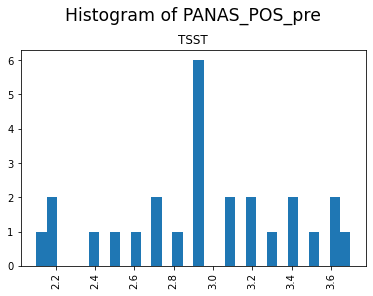

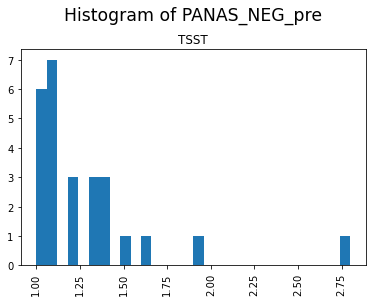

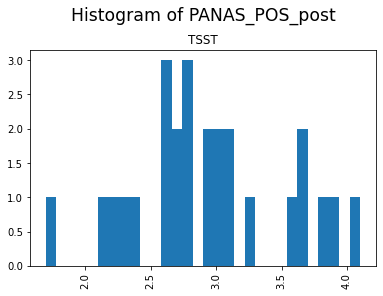

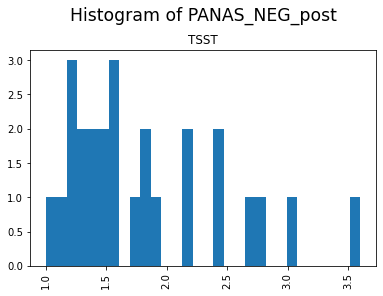

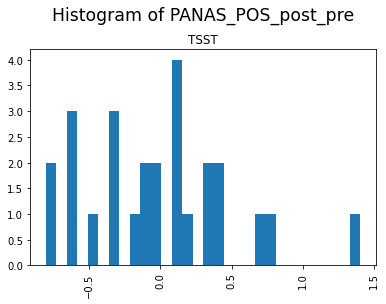

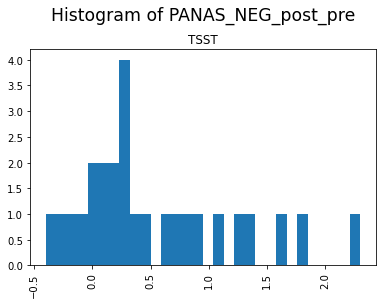

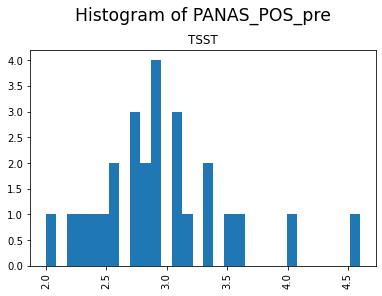

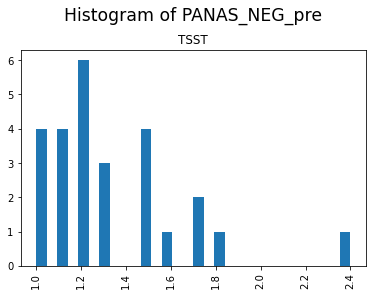

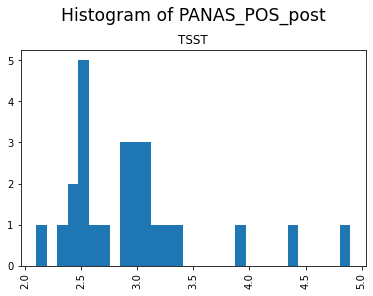

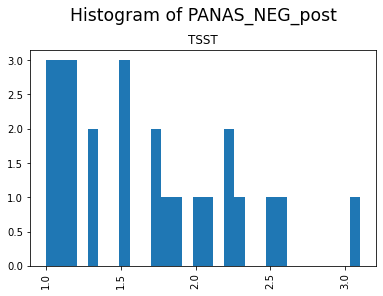

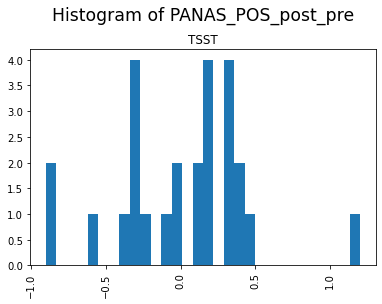

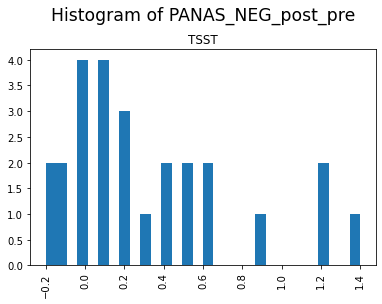

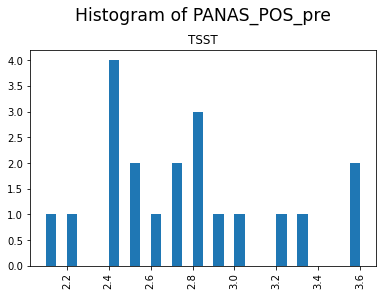

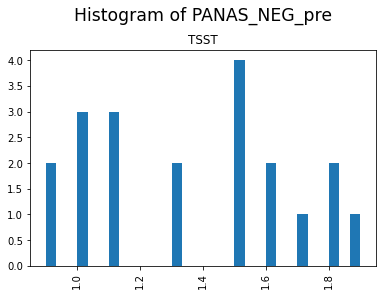

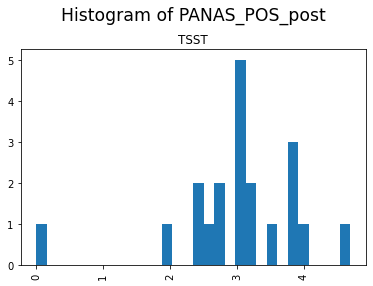

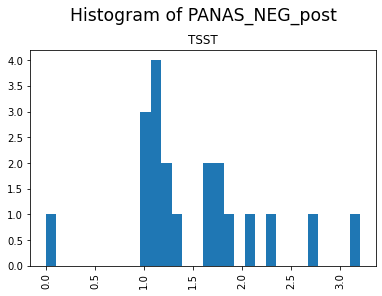

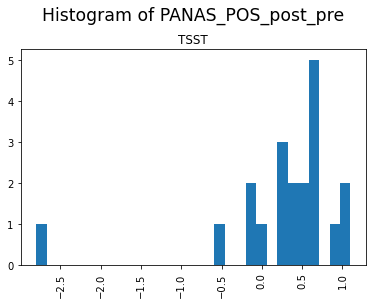

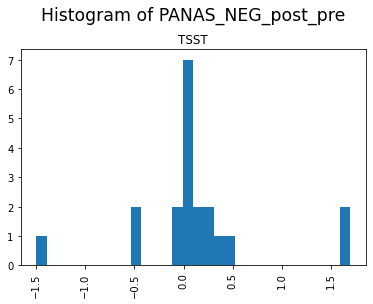

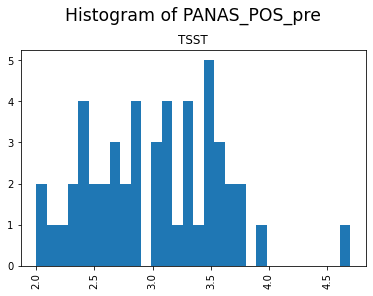

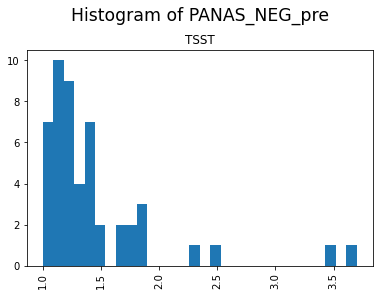

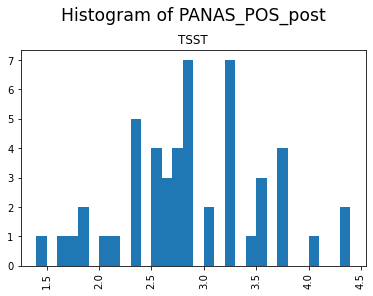

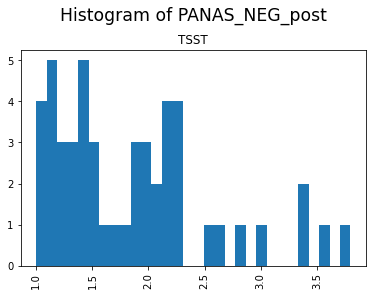

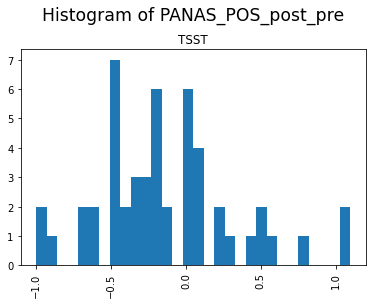

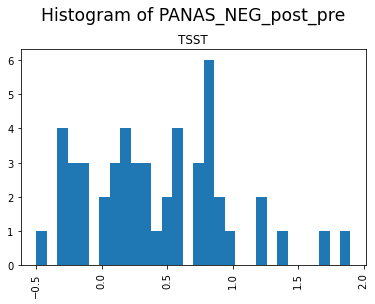

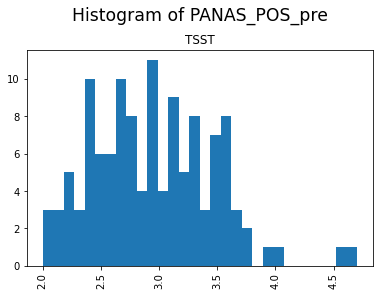

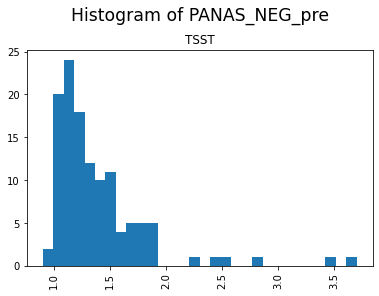

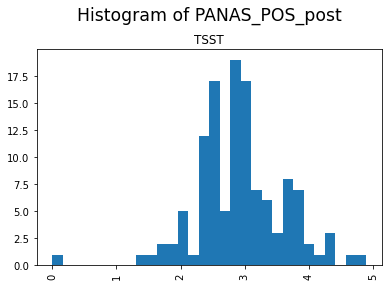

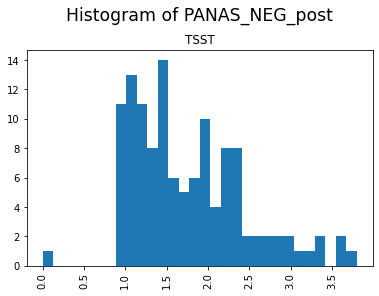

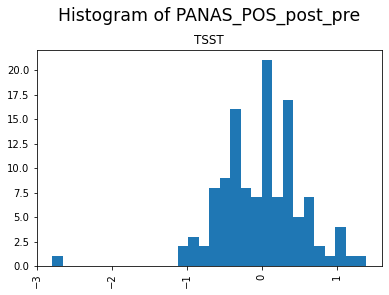

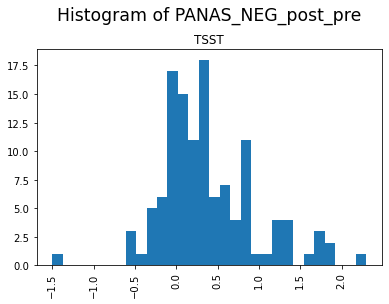

In [267]:
# preparation for normality check in TSST data

tsst_panas_combined = pd.concat([tsst_panas1, tsst_panas2, tsst_panas3, tsst_panas4])
tsst_panas_list = [tsst_panas1, tsst_panas2, tsst_panas3, tsst_panas4,
                   tsst_panas_combined]
names = ["Herten1", "Herten2", "Herten3", "OTW_HD", "Combined"]

queries = tsst_panas1.columns.tolist()
del queries[-2:]
TSST_queries_list = []
tsst_query = []
for counter, tsst_panas in enumerate(tsst_panas_list):
    print("This is for:", names[counter])
    for query in queries:
        tsst_query.append(tsst_panas.query("Condition == 'TSST'")[query])
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True)
        tsst_panas.hist(by = "Condition", column = query, ax = axes, bins = 30)
        plt.suptitle("Histogram of " + query, x=0.5, y=1.05, ha='center', fontsize='xx-large')
    
    k2, p = stats.normaltest(tsst_panas[queries])
    for counter2, elem in enumerate(p):
        if elem<0.05:
            print("Not normal: ", queries[counter2])
            print("p =", elem)
    TSST_queries_list.append(tsst_query)
    tsst_query = []

    

To set our effect size in context to previous studies using the gold standard stress induction paradigm TSST, we first do paired t-tests on data of four independent TSST studies and calculate the standardized effect sizes separately for each study.
We use Cohen's d but also Cohen's d_avg (simpler form). Afterwards we weight the four effect sizes based on the variance of the changes in each study. Formulas can be found in "Introduction to Meta-Analysis" by Borenstein.

In [268]:
# Paired t-tests for TSST-studies (combined)
tsst_panas_combined = pd.concat([tsst_panas1, tsst_panas2, tsst_panas3, tsst_panas4])
tsst_panas_list = [tsst_panas1, tsst_panas2, tsst_panas3, tsst_panas4,
                   tsst_panas_combined]
names = ["Herten1", "Herten2", "Herten3", "OTW_HD", "Combined"]
effect_sizes_na = []
effect_sizes_na_avg = []
effect_sizes_pa = []
effect_sizes_pa_avg = []
variances_na = []
variances_pa = []

for panas in ["PANAS_POS", "PANAS_NEG"]:
    for counter,tsst_panas in enumerate(tsst_panas_list):
        print("This is for:", names[counter])
        ttest = pg.ttest(tsst_panas[panas+"_pre"], tsst_panas[panas+"_post"],
                         paired = True)
        print(panas)
        data = tsst_panas[["Subject ID", panas+"_post", "Condition", panas+"_pre"]] \
            .melt(id_vars=['Subject ID', "Condition"]) \
            .sort_values(by = "Subject ID") \
            .reset_index(drop = True)
        data.replace([panas+"_pre", panas+"_post"],["0_"+panas+"_pre", "1_"+panas+"_post"], inplace = True)
        data.rename(columns = {"value": "PANAS Score", "variable": "PANAS time"}, inplace = True)
        display(data[["Condition", "PANAS Score", "PANAS time"]].groupby("PANAS time").describe())
        display(tsst_panas[["Condition","PANAS_NEG_post_pre", "PANAS_POS_post_pre", 
                            "PANAS_NEG_pre","PANAS_NEG_post", "PANAS_POS_pre", "PANAS_POS_post"]].describe())
        print("t-test for:", panas, " pre vs. post")
        display(ttest)
        if panas == "PANAS_NEG" and counter < 4:
            effect_sizes_na.append(ttest["cohen-d"].item())
            effect_sizes_na_avg.append((tsst_panas["PANAS_NEG_post_pre"].mean()/
                                       2* (tsst_panas["PANAS_NEG_pre"].std() + tsst_panas["PANAS_NEG_post"].std()))) 
            variances_na.append(tsst_panas["PANAS_NEG_post_pre"].var())
            
            # calculate t-test on baseline positive vs. negative affect
            print("This is the t-test for negative vs. positve affect baseline:")
            display(tsst_panas[["PANAS_POS_pre","PANAS_NEG_pre"]].describe())
            pg.ttest(tsst_panas["PANAS_POS_pre"], tsst_panas["PANAS_NEG_pre"], paired = False, correction = True)
            display(ttest)
        if panas == "PANAS_POS" and counter < 4:
            effect_sizes_pa.append(ttest["cohen-d"].item())
            effect_sizes_pa_avg.append(1/2 * (tsst_panas["PANAS_POS_post_pre"].mean()/
                                       (tsst_panas["PANAS_POS_pre"].std() + tsst_panas["PANAS_POS_post"].std()))) 
            variances_pa.append(tsst_panas["PANAS_POS_post_pre"].var())


print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
print("DST:")
for panas in ["PANAS_POS", "PANAS_NEG"]:
    ttest = pg.ttest(meta_completed_dst[panas+"_pre"], meta_completed_dst[panas+"_post"],
                     paired = True)
    print(panas)
    data = meta_completed_dst[["Subject ID", panas+"_post", "Condition", panas+"_pre"]] \
        .melt(id_vars=['Subject ID', "Condition"]) \
        .sort_values(by = "Subject ID") \
        .reset_index(drop = True)
    data.replace([panas+"_pre", panas+"_post"],["0_"+panas+"_pre", "1_"+panas+"_post"], inplace = True)
    data.rename(columns = {"value": "PANAS Score", "variable": "PANAS time"}, inplace = True)
    display(data[["Condition", "PANAS Score", "PANAS time"]].groupby("PANAS time").describe())
    display(meta_completed_dst[["Condition","PANAS_NEG_post_pre", "PANAS_POS_post_pre", 
                            "PANAS_NEG_pre","PANAS_NEG_post", "PANAS_POS_pre", "PANAS_POS_post"]].describe())
    print("t-test for:", panas, " pre vs. post")
    display(ttest)
    if panas == "PANAS_NEG":
        effect_size_na_avg_dst = 1/2 * (meta_completed_dst["PANAS_NEG_post_pre"].mean()/
                                       (meta_completed_dst["PANAS_NEG_pre"].std() + meta_completed_dst["PANAS_NEG_post"].std()))
        effect_size_na_dst = ttest["cohen-d"].item()
        # calculate t-test on baseline positive vs. negative affect
        print("This is the t-test for negative vs. positve affect baseline:")
        display(meta_completed_dst[["PANAS_POS_pre","PANAS_NEG_pre"]].describe())
        pg.ttest(meta_completed_dst["PANAS_POS_pre"], meta_completed_dst["PANAS_NEG_pre"], paired = False, correction = True)
        display(ttest)
    
    if panas == "PANAS_POS":
        effect_size_pa_avg_dst = 1/2 * (meta_completed_dst["PANAS_POS_post_pre"].mean()/
                                       (meta_completed_dst["PANAS_POS_pre"].std() + meta_completed_dst["PANAS_POS_post"].std()))
        effect_size_pa_dst = ttest["cohen-d"].item()    
        
        
            
print("Effect sizes for NA (d_z) in 4 TSST studies:", effect_sizes_na)
print("Effect sizes (d_avg) for NA in 4 TSST studies:", effect_sizes_na_avg)
print("Variances across studies for NA change:", variances_na)
print("Effect sizes for PA in 4 TSST studies:", effect_sizes_pa)
print("Effect sizes (d_avg) for PA in 4 TSST studies:", effect_sizes_pa_avg)
print("Variances across studies for PA change:", variances_pa)
print("Effect sizes (d_avg) for NA in DST study:", effect_size_na_avg_dst)
print("Effect sizes (d_z) for NA in DST study:", effect_size_na_dst)
print("Effect sizes (d_avg) for PA in DST study:", effect_size_pa_avg_dst)
print("Effect sizes (d_z) for PA in DST study:", effect_size_pa_dst)

This is for: Herten1
PANAS_POS


PANAS Score                                                
                       count      mean       std  min  25%   50%    75%  max
PANAS time                                                                  
0_PANAS_POS_pre         26.0  2.950000  0.449222  2.1  2.7  2.90  3.275  3.7
1_PANAS_POS_post        26.0  2.938462  0.593348  1.7  2.6  2.85  3.250  4.1

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           26.000000           26.000000      26.000000       26.000000   
mean             0.546154           -0.011538       1.276923        1.823077   
std              0.683070            0.514064       0.379798        0.659277   
min             -0.400000           -0.800000       1.000000        1.000000   
25%              0.100000           -0.300000       1.100000        1.325000   
50%              0.300000            0.000000       1.150000        1.600000   
75%              0.875000            0.275000       1.375000        2.200000   
max              2.300000            1.400000       2.800000        3.600000   

       PANAS_POS_pre  PANAS_POS_post  
count      26.000000       26.000000  
mean        2.950000        2.938462  
std         0.449222        0.593348  
min         2.100000        1.700000  
25%         2.700000        2.600000  
50%         2.900000        2.850000  
75%         3.275000        3.250000  
max         3.700000        4.100000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  0.11445   25   two-sided  0.909795  [-0.2, 0.22]  0.021926  0.208   

           power  
T-test  0.051327

This is for: Herten2
PANAS_POS


PANAS Score                                                 
                       count      mean       std  min    25%  50%    75%  max
PANAS time                                                                   
0_PANAS_POS_pre         26.0  2.950000  0.558749  2.0  2.625  2.9  3.175  4.6
1_PANAS_POS_post        26.0  2.965385  0.639339  2.1  2.500  2.9  3.100  4.9

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           26.000000           26.000000      26.000000       26.000000   
mean             0.323077            0.015385       1.334615        1.657692   
std              0.439370            0.451391       0.321176        0.574925   
min             -0.200000           -0.900000       1.000000        1.000000   
25%              0.000000           -0.300000       1.100000        1.200000   
50%              0.200000            0.100000       1.200000        1.500000   
75%              0.500000            0.300000       1.500000        2.075000   
max              1.400000            1.200000       2.400000        3.100000   

       PANAS_POS_pre  PANAS_POS_post  
count      26.000000       26.000000  
mean        2.950000        2.965385  
std         0.558749        0.639339  
min         2.000000        2.100000  
25%         2.625000        2.500000  
50%         2.900000        2.900000  
75%         3.175000        3.100000  
max         4.600000        4.900000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val         CI95%   cohen-d  BF10  \
T-test -0.173788   25   two-sided  0.863431  [-0.2, 0.17]  0.025624  0.21   

           power  
T-test  0.051812

This is for: Herten3
PANAS_POS


PANAS Score                                               
                       count   mean       std  min    25%   50%    75%  max
PANAS time                                                                 
0_PANAS_POS_pre         20.0  2.745  0.423612  2.1  2.400  2.70  2.925  3.6
1_PANAS_POS_post        20.0  3.015  0.959866  0.0  2.675  3.05  3.575  4.7

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           20.000000           20.000000      20.000000       20.000000   
mean             0.155000            0.270000       1.355000        1.510000   
std              0.680151            0.824046       0.325212        0.710004   
min             -1.500000           -2.800000       0.900000        0.000000   
25%             -0.025000            0.225000       1.075000        1.100000   
50%              0.100000            0.450000       1.400000        1.250000   
75%              0.300000            0.600000       1.600000        1.825000   
max              1.700000            1.100000       1.900000        3.200000   

       PANAS_POS_pre  PANAS_POS_post  
count      20.000000       20.000000  
mean        2.745000        3.015000  
std         0.423612        0.959866  
min         2.100000        0.000000  
25%         2.400000        2.675000  
50%         2.700000        3.050000  
75%         2.925000        3.575000  
max         3.600000        4.700000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.465302   19   two-sided  0.159192  [-0.66, 0.12]  0.363937  0.584   

           power  
T-test  0.339524

This is for: OTW_HD
PANAS_POS


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_POS_pre         50.0  3.022000  0.570460  2.0  2.6  3.0  3.5  4.7
1_PANAS_POS_post        50.0  2.883111  0.684008  1.4  2.5  2.9  3.3  4.4

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           50.000000           50.000000      50.000000       50.000000   
mean             0.423556           -0.138889       1.430000        1.853556   
std              0.531443            0.467267       0.559974        0.723655   
min             -0.500000           -1.000000       1.000000        1.000000   
25%              0.041667           -0.500000       1.100000        1.300000   
50%              0.300000           -0.200000       1.200000        1.750000   
75%              0.800000            0.088889       1.475000        2.200000   
max              1.900000            1.100000       3.700000        3.800000   

       PANAS_POS_pre  PANAS_POS_post  
count       50.00000       50.000000  
mean         3.02200        2.883111  
std          0.57046        0.684008  
min          2.00000        1.400000  
25%          2.60000        2.500000  
50%          3.00000        2.900000  
75%          3.50000        3.300000  
max          4.70000        4.400000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.101781   49   two-sided  0.040736  [0.01, 0.27]  0.220529  1.154   

           power  
T-test  0.333435

This is for: Combined
PANAS_POS


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_POS_pre        122.0  2.945902  0.524625  2.0  2.6  2.9  3.3  4.7
1_PANAS_POS_post       122.0  2.934062  0.702641  0.0  2.5  2.9  3.3  4.9

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count          122.000000          122.000000     122.000000      122.000000   
mean             0.384244           -0.011840       1.364754        1.748998   
std              0.582291            0.558303       0.445347        0.682825   
min             -1.500000           -2.800000       0.900000        0.000000   
25%              0.000000           -0.300000       1.100000        1.200000   
50%              0.300000            0.000000       1.200000        1.600000   
75%              0.700000            0.300000       1.500000        2.200000   
max              2.300000            1.400000       3.700000        3.800000   

       PANAS_POS_pre  PANAS_POS_post  
count     122.000000      122.000000  
mean        2.945902        2.934062  
std         0.524625        0.702641  
min         2.000000        0.000000  
25%         2.600000        2.500000  
50%         2.900000        2.900000  
75%         3.300000        3.300000  
max         4.700000        4.900000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.234235  121   two-sided  0.815199  [-0.09, 0.11]  0.019095  0.103   

          power  
T-test  0.05503

This is for: Herten1
PANAS_NEG


PANAS Score                                                  
                       count      mean       std  min    25%   50%    75%  max
PANAS time                                                                    
0_PANAS_NEG_pre         26.0  1.276923  0.379798  1.0  1.100  1.15  1.375  2.8
1_PANAS_NEG_post        26.0  1.823077  0.659277  1.0  1.325  1.60  2.200  3.6

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           26.000000           26.000000      26.000000       26.000000   
mean             0.546154           -0.011538       1.276923        1.823077   
std              0.683070            0.514064       0.379798        0.659277   
min             -0.400000           -0.800000       1.000000        1.000000   
25%              0.100000           -0.300000       1.100000        1.325000   
50%              0.300000            0.000000       1.150000        1.600000   
75%              0.875000            0.275000       1.375000        2.200000   
max              2.300000            1.400000       2.800000        3.600000   

       PANAS_POS_pre  PANAS_POS_post  
count      26.000000       26.000000  
mean        2.950000        2.938462  
std         0.449222        0.593348  
min         2.100000        1.700000  
25%         2.700000        2.600000  
50%         2.900000        2.850000  
75%         3.275000        3.250000  
max         3.700000        4.100000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -4.07696   25   two-sided  0.000406  [-0.82, -0.27]  1.015152  76.169   

          power  
T-test  0.99869

This is the t-test for negative vs. positve affect baseline:


PANAS_POS_pre  PANAS_NEG_pre
count      26.000000      26.000000
mean        2.950000       1.276923
std         0.449222       0.379798
min         2.100000       1.000000
25%         2.700000       1.100000
50%         2.900000       1.150000
75%         3.275000       1.375000
max         3.700000       2.800000

T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -4.07696   25   two-sided  0.000406  [-0.82, -0.27]  1.015152  76.169   

          power  
T-test  0.99869

This is for: Herten2
PANAS_NEG


PANAS Score                                               
                       count      mean       std  min  25%  50%    75%  max
PANAS time                                                                 
0_PANAS_NEG_pre         26.0  1.334615  0.321176  1.0  1.1  1.2  1.500  2.4
1_PANAS_NEG_post        26.0  1.657692  0.574925  1.0  1.2  1.5  2.075  3.1

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           26.000000           26.000000      26.000000       26.000000   
mean             0.323077            0.015385       1.334615        1.657692   
std              0.439370            0.451391       0.321176        0.574925   
min             -0.200000           -0.900000       1.000000        1.000000   
25%              0.000000           -0.300000       1.100000        1.200000   
50%              0.200000            0.100000       1.200000        1.500000   
75%              0.500000            0.300000       1.500000        2.075000   
max              1.400000            1.200000       2.400000        3.100000   

       PANAS_POS_pre  PANAS_POS_post  
count      26.000000       26.000000  
mean        2.950000        2.965385  
std         0.558749        0.639339  
min         2.000000        2.100000  
25%         2.625000        2.500000  
50%         2.900000        2.900000  
75%         3.175000        3.100000  
max         4.600000        4.900000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative    p-val          CI95%   cohen-d    BF10  \
T-test -3.749402   25   two-sided  0.00094  [-0.5, -0.15]  0.693793  36.301   

           power  
T-test  0.924902

This is the t-test for negative vs. positve affect baseline:


PANAS_POS_pre  PANAS_NEG_pre
count      26.000000      26.000000
mean        2.950000       1.334615
std         0.558749       0.321176
min         2.000000       1.000000
25%         2.625000       1.100000
50%         2.900000       1.200000
75%         3.175000       1.500000
max         4.600000       2.400000

T  dof alternative    p-val          CI95%   cohen-d    BF10  \
T-test -3.749402   25   two-sided  0.00094  [-0.5, -0.15]  0.693793  36.301   

           power  
T-test  0.924902

This is for: Herten3
PANAS_NEG


PANAS Score                                               
                       count   mean       std  min    25%   50%    75%  max
PANAS time                                                                 
0_PANAS_NEG_pre         20.0  1.355  0.325212  0.9  1.075  1.40  1.600  1.9
1_PANAS_NEG_post        20.0  1.510  0.710004  0.0  1.100  1.25  1.825  3.2

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           20.000000           20.000000      20.000000       20.000000   
mean             0.155000            0.270000       1.355000        1.510000   
std              0.680151            0.824046       0.325212        0.710004   
min             -1.500000           -2.800000       0.900000        0.000000   
25%             -0.025000            0.225000       1.075000        1.100000   
50%              0.100000            0.450000       1.400000        1.250000   
75%              0.300000            0.600000       1.600000        1.825000   
max              1.700000            1.100000       1.900000        3.200000   

       PANAS_POS_pre  PANAS_POS_post  
count      20.000000       20.000000  
mean        2.745000        3.015000  
std         0.423612        0.959866  
min         2.100000        0.000000  
25%         2.400000        2.675000  
50%         2.700000        3.050000  
75%         2.925000        3.575000  
max         3.600000        4.700000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.019158   19   two-sided  0.320931  [-0.47, 0.16]  0.280691  0.367   

           power  
T-test  0.222188

This is the t-test for negative vs. positve affect baseline:


PANAS_POS_pre  PANAS_NEG_pre
count      20.000000      20.000000
mean        2.745000       1.355000
std         0.423612       0.325212
min         2.100000       0.900000
25%         2.400000       1.075000
50%         2.700000       1.400000
75%         2.925000       1.600000
max         3.600000       1.900000

T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.019158   19   two-sided  0.320931  [-0.47, 0.16]  0.280691  0.367   

           power  
T-test  0.222188

This is for: OTW_HD
PANAS_NEG


PANAS Score                                                
                       count      mean       std  min  25%   50%    75%  max
PANAS time                                                                  
0_PANAS_NEG_pre         50.0  1.430000  0.559974  1.0  1.1  1.20  1.475  3.7
1_PANAS_NEG_post        50.0  1.853556  0.723655  1.0  1.3  1.75  2.200  3.8

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count           50.000000           50.000000      50.000000       50.000000   
mean             0.423556           -0.138889       1.430000        1.853556   
std              0.531443            0.467267       0.559974        0.723655   
min             -0.500000           -1.000000       1.000000        1.000000   
25%              0.041667           -0.500000       1.100000        1.300000   
50%              0.300000           -0.200000       1.200000        1.750000   
75%              0.800000            0.088889       1.475000        2.200000   
max              1.900000            1.100000       3.700000        3.800000   

       PANAS_POS_pre  PANAS_POS_post  
count       50.00000       50.000000  
mean         3.02200        2.883111  
std          0.57046        0.684008  
min          2.00000        1.400000  
25%          2.60000        2.500000  
50%          3.00000        2.900000  
75%          3.50000        3.300000  
max          4.70000        4.400000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative         p-val           CI95%   cohen-d  \
T-test -5.635577   49   two-sided  8.482347e-07  [-0.57, -0.27]  0.654633   

             BF10     power  
T-test  1.911e+04  0.995011

This is the t-test for negative vs. positve affect baseline:


PANAS_POS_pre  PANAS_NEG_pre
count       50.00000      50.000000
mean         3.02200       1.430000
std          0.57046       0.559974
min          2.00000       1.000000
25%          2.60000       1.100000
50%          3.00000       1.200000
75%          3.50000       1.475000
max          4.70000       3.700000

T  dof alternative         p-val           CI95%   cohen-d  \
T-test -5.635577   49   two-sided  8.482347e-07  [-0.57, -0.27]  0.654633   

             BF10     power  
T-test  1.911e+04  0.995011

This is for: Combined
PANAS_NEG


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_NEG_pre        122.0  1.364754  0.445347  0.9  1.1  1.2  1.5  3.7
1_PANAS_NEG_post       122.0  1.748998  0.682825  0.0  1.2  1.6  2.2  3.8

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count          122.000000          122.000000     122.000000      122.000000   
mean             0.384244           -0.011840       1.364754        1.748998   
std              0.582291            0.558303       0.445347        0.682825   
min             -1.500000           -2.800000       0.900000        0.000000   
25%              0.000000           -0.300000       1.100000        1.200000   
50%              0.300000            0.000000       1.200000        1.600000   
75%              0.700000            0.300000       1.500000        2.200000   
max              2.300000            1.400000       3.700000        3.800000   

       PANAS_POS_pre  PANAS_POS_post  
count     122.000000      122.000000  
mean        2.945902        2.934062  
std         0.524625        0.702641  
min         2.000000        0.000000  
25%         2.600000        2.500000  
50%         2.900000        2.900000  
75%         3.300000        3.300000  
max         4.700000        4.900000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative         p-val           CI95%   cohen-d  \
T-test -7.288646  121   two-sided  3.517545e-11  [-0.49, -0.28]  0.666572   

             BF10  power  
T-test  2.414e+08    1.0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
DST:
PANAS_POS


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_POS_pre        103.0  3.081553  0.651657  1.6  2.6  3.2  3.6  4.2
1_PANAS_POS_post       103.0  3.370874  0.849640  1.0  2.9  3.6  4.0  5.0

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count          103.000000          103.000000     103.000000      103.000000   
mean             0.269903            0.289320       1.568932        1.838835   
std              0.607605            0.606971       0.562039        0.695114   
min             -1.400000           -2.000000       1.000000        1.000000   
25%              0.000000           -0.100000       1.200000        1.200000   
50%              0.200000            0.200000       1.400000        1.600000   
75%              0.600000            0.600000       1.800000        2.200000   
max              2.400000            2.200000       3.400000        4.000000   

       PANAS_POS_pre  PANAS_POS_post  
count     103.000000      103.000000  
mean        3.081553        3.370874  
std         0.651657        0.849640  
min         1.600000        1.000000  
25%         2.600000        2.900000  
50%         3.200000        3.600000  
75%         3.600000        4.000000  
max         4.200000        5.000000

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val           CI95%   cohen-d  \
T-test -4.837594  102   two-sided  0.000005  [-0.41, -0.17]  0.382119   

            BF10     power  
T-test  3190.416  0.970038

PANAS_NEG


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_NEG_pre        103.0  1.568932  0.562039  1.0  1.2  1.4  1.8  3.4
1_PANAS_NEG_post       103.0  1.838835  0.695114  1.0  1.2  1.6  2.2  4.0

PANAS_NEG_post_pre  PANAS_POS_post_pre  PANAS_NEG_pre  PANAS_NEG_post  \
count          103.000000          103.000000     103.000000      103.000000   
mean             0.269903            0.289320       1.568932        1.838835   
std              0.607605            0.606971       0.562039        0.695114   
min             -1.400000           -2.000000       1.000000        1.000000   
25%              0.000000           -0.100000       1.200000        1.200000   
50%              0.200000            0.200000       1.400000        1.600000   
75%              0.600000            0.600000       1.800000        2.200000   
max              2.400000            2.200000       3.400000        4.000000   

       PANAS_POS_pre  PANAS_POS_post  
count     103.000000      103.000000  
mean        3.081553        3.370874  
std         0.651657        0.849640  
min         1.600000        1.000000  
25%         2.600000        2.900000  
50%         3.200000        3.600000  
75%         3.600000        4.000000  
max         4.200000        5.000000

t-test for: PANAS_NEG  pre vs. post


T  dof alternative     p-val           CI95%   cohen-d     BF10  \
T-test -4.50822  102   two-sided  0.000017  [-0.39, -0.15]  0.427002  923.708   

           power  
T-test  0.990163

This is the t-test for negative vs. positve affect baseline:


PANAS_POS_pre  PANAS_NEG_pre
count     103.000000     103.000000
mean        3.081553       1.568932
std         0.651657       0.562039
min         1.600000       1.000000
25%         2.600000       1.200000
50%         3.200000       1.400000
75%         3.600000       1.800000
max         4.200000       3.400000

T  dof alternative     p-val           CI95%   cohen-d     BF10  \
T-test -4.50822  102   two-sided  0.000017  [-0.39, -0.15]  0.427002  923.708   

           power  
T-test  0.990163

Effect sizes for NA (d_z) in 4 TSST studies: [1.015152070839649, 0.6937932597234573, 0.28069108734628906, 0.654633496608722]
Effect sizes (d_avg) for NA in 4 TSST studies: [0.2837472700840133, 0.1447546911406701, 0.0802292545380705, 0.27184425738897416]
Variances across studies for NA change: [0.46658461538461554, 0.1930461538461539, 0.46260526315789474, 0.28243204837490554]
Effect sizes for PA in 4 TSST studies: [0.021926145954986324, 0.025624058057920767, 0.3639373496272963, 0.22052917716931514]
Effect sizes (d_avg) for PA in 4 TSST studies: [-0.005533666529822378, 0.006420490659856609, 0.09758015978666694, -0.05535768245073705]
Variances across studies for PA change: [0.26426153846153855, 0.20375384615384623, 0.6790526315789475, 0.2183383723859915]
Effect sizes (d_avg) for NA in DST study: 0.1073468985903676
Effect sizes (d_z) for NA in DST study: 0.42700197365697085
Effect sizes (d_avg) for PA in DST study: 0.09635682361918593
Effect sizes (d_z) for PA in DST study: 0.3821188981182

In [269]:
# calculation of combined effect size based on weighted effect_sizes 
# using the variance of the change scores to weigh the individual effect sizes

# create dataframe
effect_df = pd.DataFrame({"Study": names[:-1], "Effect_NA": effect_sizes_na, "Effect_PA": effect_sizes_pa, 
                          "Effect_NA_avg": effect_sizes_na_avg, "Effect_PA_avg": effect_sizes_pa_avg,
                          "Variances_NA": variances_na, "Variances_PA": variances_pa})
effect_df["weights_NA"] = 1/effect_df["Variances_NA"]
effect_df["weights_PA"] = 1/effect_df["Variances_PA"]
effect_df["weighted_effect_NA"] = effect_df["weights_NA"] * effect_df["Effect_NA"]
effect_df["weighted_effect_NA_avg"] = effect_df["weights_NA"] * effect_df["Effect_NA_avg"]
effect_df["weighted_effect_PA"] = effect_df["weights_PA"] * effect_df["Effect_PA"]
effect_df["weighted_effect_PA_avg"] = effect_df["weights_PA"] * effect_df["Effect_PA"]
display(effect_df)

# combined effect = sum of weightes effect sizes divided by sum of weights:

combined_effect_size_NA_avg = effect_df["weighted_effect_NA_avg"].sum() / effect_df["weights_NA"].sum()
combined_effect_size_NA = effect_df["weighted_effect_NA"].sum() / effect_df["weights_NA"].sum()
combined_effect_size_variance_NA = 1/effect_df["weights_NA"].sum()
combined_effect_size_standard_error_NA = combined_effect_size_variance_NA ** (1/2)
combined_effect_size_lower_limit_NA_avg = combined_effect_size_NA_avg - 1.96* combined_effect_size_standard_error_NA
combined_effect_size_lower_upper_NA_avg = combined_effect_size_NA_avg + 1.96* combined_effect_size_standard_error_NA
combined_effect_size_lower_limit_NA = combined_effect_size_NA - 1.96* combined_effect_size_standard_error_NA
combined_effect_size_upper_limit_NA = combined_effect_size_NA - 1.96* combined_effect_size_standard_error_NA

print("Combined effect size for NA change using d_avg:", combined_effect_size_NA_avg)
print("Combined effect size for NA change using d_z:", combined_effect_size_NA)
print("Effect sizes (d_z) for NA in DST study:", effect_size_na_dst)
print("Effect sizes (d_z) for NA in DST study:", effect_size_pa_dst)
print("Effect sizes (d_avg) for NA in DST study:", effect_size_na_avg_dst)
print("Effect sizes (d_avg) for NA in DST study:", effect_size_pa_avg_dst)

Study  Effect_NA  Effect_PA  Effect_NA_avg  Effect_PA_avg  Variances_NA  \
0  Herten1   1.015152   0.021926       0.283747      -0.005534      0.466585   
1  Herten2   0.693793   0.025624       0.144755       0.006420      0.193046   
2  Herten3   0.280691   0.363937       0.080229       0.097580      0.462605   
3   OTW_HD   0.654633   0.220529       0.271844      -0.055358      0.282432   

   Variances_PA  weights_NA  weights_PA  weighted_effect_NA  \
0      0.264262    2.143234    3.784130            2.175708   
1      0.203754    5.180108    4.907883            3.593924   
2      0.679053    2.161670    1.472640            0.606762   
3      0.218338    3.540675    4.580047            2.317844   

   weighted_effect_NA_avg  weighted_effect_PA  weighted_effect_PA_avg  
0                0.608137            0.082971                0.082971  
1                0.749845            0.125760                0.125760  
2                0.173429            0.535949                0.535949  
3                0.962512            1.010034                1.010034

Combined effect size for NA change using d_avg: 0.19146191697065762
Combined effect size for NA change using d_z: 0.6674686981944981
Effect sizes (d_z) for NA in DST study: 0.42700197365697085
Effect sizes (d_z) for NA in DST study: 0.3821188981182789
Effect sizes (d_avg) for NA in DST study: 0.1073468985903676
Effect sizes (d_avg) for NA in DST study: 0.09635682361918593


## Correlations between different tasks and the perceived stress level increase
First we check the DST - correlations using a scatter plot and regression coefficients.

XXXXXXXXXXXXXXXXXXX
Scipy Spearman Korrelationskoeffizient und p-value:
Stress
N for correlation analysis: 103
Total: SpearmanrResult(correlation=-0.16016376453924616, pvalue=0.006836487350327286)
DST: SpearmanrResult(correlation=-0.14962345822197745, pvalue=0.1314303644889582)
C-DST: SpearmanrResult(correlation=0.036300015758186074, pvalue=0.6275747388705115)
XXXXXXXXXXXXXXXXXXX
Scipy Spearman Korrelationskoeffizient und p-value:
Frustration
N for correlation analysis: 103
Total: SpearmanrResult(correlation=-0.32207939613033093, pvalue=2.8161617070009035e-08)
DST: SpearmanrResult(correlation=-0.048952452165681455, pvalue=0.6233949944167074)
C-DST: SpearmanrResult(correlation=-0.15135781465103215, pvalue=0.04195799664956844)
XXXXXXXXXXXXXXXXXXX
Scipy Spearman Korrelationskoeffizient und p-value:
Shame
N for correlation analysis: 103
Total: SpearmanrResult(correlation=-0.3295615800948056, pvalue=1.2771245260610939e-08)
DST: SpearmanrResult(correlation=-0.10910288948063637, pvalue=0.2726

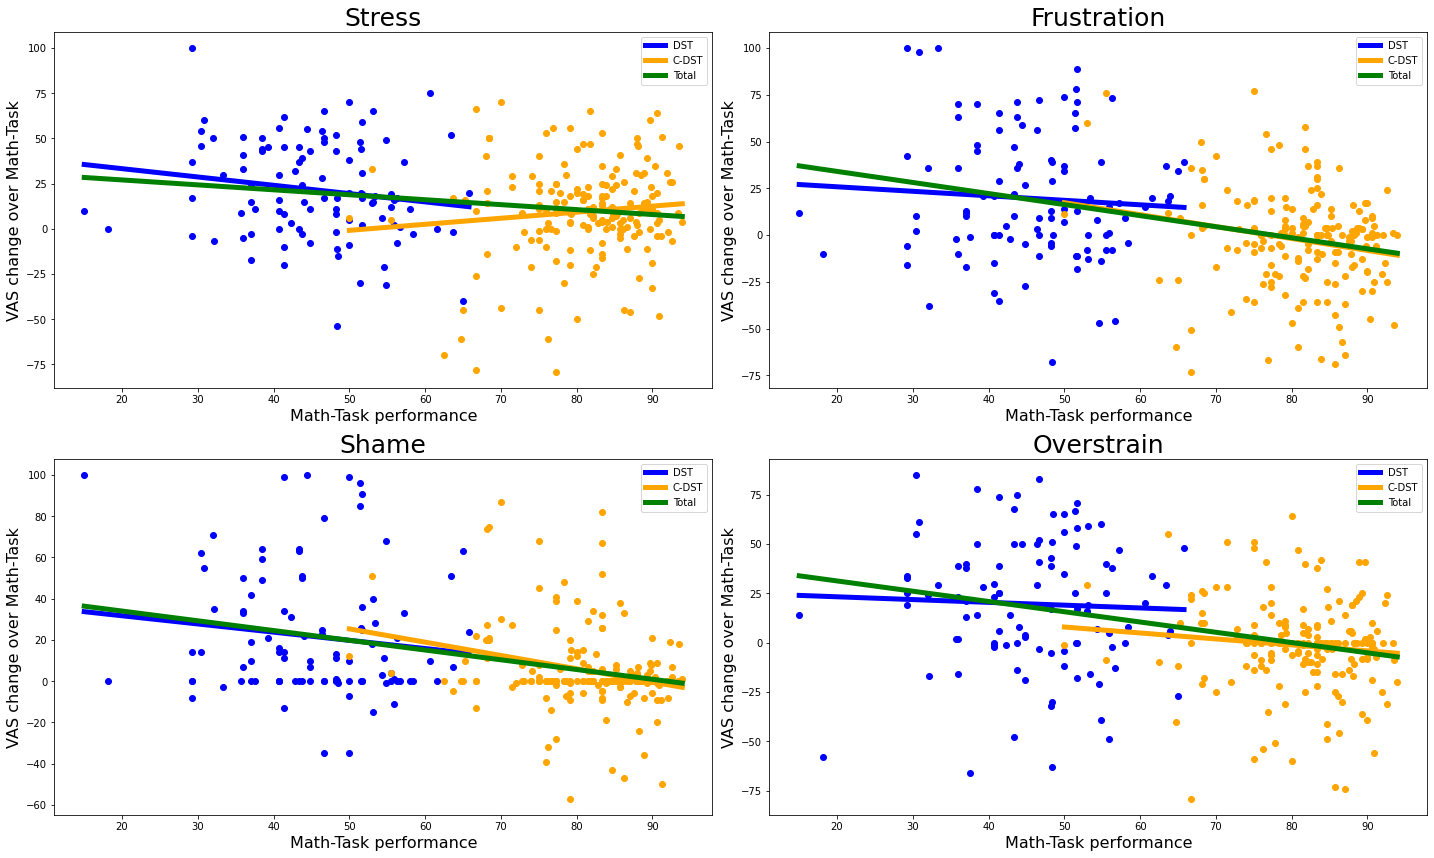

In [270]:
# TODO

scales = ["stress", "frustrated", "ashamed", "overstrained"]
titles = ["Stress", "Frustration", "Shame", "Overstrain"]
counter = 1
f = plt.figure(figsize=[20,12])
for scale in scales:
    # DST scatter
    x = meta_completed_dst["percentage_end"]
    y = (meta_completed_dst["intermediate."+scale]-meta_completed_dst["baseline."+scale])
    color = "blue"
    ax = f.add_subplot(2,2,counter)
    ax.scatter(x = x,y = y, color = color)
    # fitting DST regression line
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color, linewidth=5)
    
    # C-DST scatter
    x = meta_completed_cdst["percentage_end"]
    y = (meta_completed_cdst["intermediate."+scale]-meta_completed_cdst["baseline."+scale])
    color = "orange"
    ax.scatter(x = x,y = y,color = color)
    # fitting C-DST regression line
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color, linewidth=5)
    
    # fitting regression line for all participants
    x = meta_completed["percentage_end"]
    y = (meta_completed["intermediate."+scale]-meta_completed["baseline."+scale])
    color = "green"
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color, linewidth=5)
    
    # Labelling
    plt.xlabel("Math-Task performance", fontsize = 16)
    plt.ylabel("VAS change over Math-Task", fontsize = 16)
    plt.title(titles[counter-1], fontsize = 25)
    ax.legend(["DST", "C-DST", "Total"])
    

    print("XXXXXXXXXXXXXXXXXXX")
    print("Scipy Spearman Korrelationskoeffizient und p-value:")
    print(titles[counter-1])
    print("N for correlation analysis:", len(meta_completed_dst["percentage_end"].notna()))
    print("Total:", 
          scipy.stats.spearmanr(meta_completed["percentage_end"],(meta_completed["intermediate."+scale] - meta_completed["baseline."+scale])))
    print("DST:", 
          scipy.stats.spearmanr(meta_completed_dst["percentage_end"],(meta_completed_dst["intermediate."+scale] - meta_completed_dst["baseline."+scale])))
    print("C-DST:", 
          scipy.stats.spearmanr(meta_completed_cdst["percentage_end"],(meta_completed_cdst["intermediate."+scale] - meta_completed_cdst["baseline."+scale])))
    counter += 1

               
# print("(Pearson -) Korrelationskoeffizient mit Numpy:",np.corrcoef(meta_completed["percentage_end"], meta_completed["VAS_mean_intermediate_pre"]))
# print("Pearson - Korrelation mit Pandas:")
# display((meta_completed_dst[["percentage_end","VAS_mean_intermediate_pre"]].corr(method = "pearson")))

# print("Scipy Pearson Korrelationskoeffizient und p-value:", scipy.stats.pearsonr(x = meta_completed_dst["percentage_end"],y = meta_completed_dst["VAS_mean_intermediate_pre"]))


f.tight_layout(pad = 1)

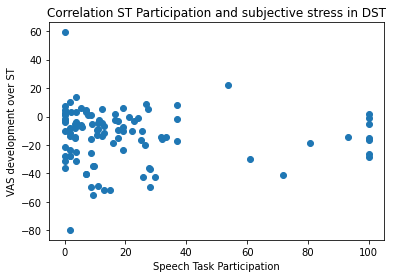

N for correlation analysis: 103
Scipy Pearson Korrelationskoeffizient und p-value: (-0.042299849743053404, 0.6713854469675796)
Scipy Spearman Korrelationskoeffizient und p-value: SpearmanrResult(correlation=-0.12072763914781626, pvalue=0.22446250875165014)


In [271]:
# only DST studies here

plt.scatter(x = meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()], y = meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()])
plt.xlabel("Speech Task Participation")
plt.ylabel("VAS development over ST")
plt.title("Correlation ST Participation and subjective stress in DST")
plt.show()

print("N for correlation analysis:",(meta_completed_dst["Speaking Percentage Total"].notna().sum()))
#print("Pearson - Korrelation mit Pandas:", (meta_completed_dst[["Speaking Percentage Total","VAS_mean_post_intermediate"]].corr(method = "pearson")))

print("Scipy Pearson Korrelationskoeffizient und p-value:", scipy.stats.pearsonr(x = meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()], y = meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()]))
np.corrcoef(meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()], meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()])
print("Scipy Spearman Korrelationskoeffizient und p-value:", scipy.stats.spearmanr(meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()], meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()]))


# Supplementary and Exploratory Analyses

## Welch's t-test for different VAS between DST and C-DST overall (Group-effect in mixed ANOVA) 


In [272]:
for scale in ["stress", "frustrated", "ashamed", "overstrained"]:

    data = meta_completed[["Subject ID", "Condition", "baseline." + scale, "intermediate." + scale, "freeSpeech." + scale]]  \
        .melt(id_vars=['Subject ID', "Condition"]) \
        .sort_values(by = "Subject ID") \
        .reset_index(drop = True)
    data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
    print(scale)
    ttest1 = pg.pairwise_ttests(dv = "VAS Score", between = "Condition", correction = True, data = data,
                               return_desc = True)
    display(ttest1)
    ttest2 = pg.pairwise_ttests(dv = "VAS Score", between = "Condition", within = "VAS time", correction = True, data = data,
                                subject = "Subject ID", return_desc = True)
    display(ttest2)
    
    display(data[["Condition", "VAS Score"]].groupby("Condition").describe())
    print("XXXXXXXXXXXXXXXXXX")



stress


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast      A    B    mean(A)     std(A)    mean(B)     std(B)  Paired  \
0  Condition  C-DST  DST  32.791897  25.964618  42.394822  27.398326   False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -5.012074  612.370282   two-sided  7.057846e-07  1.542e+04   

     hedges  
0 -0.362149

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Contrast             VAS time                  A  \
0              VAS time                    -    baseline.stress   
1              VAS time                    -    baseline.stress   
2              VAS time                    -  freeSpeech.stress   
3             Condition                    -              C-DST   
4  VAS time * Condition      baseline.stress              C-DST   
5  VAS time * Condition    freeSpeech.stress              C-DST   
6  VAS time * Condition  intermediate.stress              C-DST   

                     B    mean(A)     std(A)    mean(B)     std(B) Paired  \
0    freeSpeech.stress  32.919014  25.479649  29.147887  25.957412   True   
1  intermediate.stress  32.919014  25.479649  46.757042  26.014690   True   
2  intermediate.stress  29.147887  25.957412  46.757042  26.014690   True   
3                  DST  32.791897  20.273416  42.394822  20.865935  False   
4                  DST  32.839779  25.871945  33.058252  24.899730  False   
5                  DST  23.182320  23.892698  39.631068  26.227882  False   
6                  DST  42.353591  24.595999  54.495146  26.743837  False   

   Parametric          T         dof alternative         p-unc       BF10  \
0        True   2.352227  283.000000   two-sided  1.934649e-02      1.002   
1        True  -8.509933  283.000000   two-sided  1.031169e-15  4.998e+12   
2        True -12.531734  283.000000   two-sided  5.884743e-29  5.331e+25   
3        True  -3.767203  207.149246   two-sided  2.151538e-04    101.447   
4        True  -0.070084  218.991103   two-sided  9.441904e-01      0.136   
5        True  -5.245646  196.279626   two-sided  4.016465e-07   4.04e+04   
6        True  -3.785679  197.847607   two-sided  2.031885e-04    108.135   

     hedges  
0  0.146430  
1 -0.536717  
2 -0.676740  
3 -0.467423  
4 -0.008537  
5 -0.662485  
6 -0.476857

VAS Score                                                    
              count       mean        std  min   25%   50%   75%    max
Condition                                                              
C-DST         543.0  32.791897  25.964618  0.0  12.0  28.0  51.0  100.0
DST           309.0  42.394822  27.398326  0.0  20.0  39.0  65.0  100.0

XXXXXXXXXXXXXXXXXX
frustrated


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast      A    B    mean(A)    std(A)    mean(B)     std(B)  Paired  \
0  Condition  C-DST  DST  25.342541  26.80221  36.728155  30.268558   False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -5.498343  578.699044   two-sided  5.757879e-08  1.766e+05   

     hedges  
0 -0.404714

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Contrast                 VAS time                      A  \
0              VAS time                        -    baseline.frustrated   
1              VAS time                        -    baseline.frustrated   
2              VAS time                        -  freeSpeech.frustrated   
3             Condition                        -                  C-DST   
4  VAS time * Condition      baseline.frustrated                  C-DST   
5  VAS time * Condition    freeSpeech.frustrated                  C-DST   
6  VAS time * Condition  intermediate.frustrated                  C-DST   

                         B    mean(A)     std(A)    mean(B)     std(B) Paired  \
0    freeSpeech.frustrated  31.320423  28.177369  20.253521  25.377137   True   
1  intermediate.frustrated  31.320423  28.177369  36.841549  29.697644   True   
2  intermediate.frustrated  20.253521  25.377137  36.841549  29.697644   True   
3                      DST  25.342541  21.257952  36.728155  22.388272  False   
4                      DST  31.685083  29.057515  30.679612  26.687081  False   
5                      DST  15.154696  22.611903  29.213592  27.518853  False   
6                      DST  29.187845  25.450564  50.291262  31.895242  False   

   Parametric          T         dof alternative         p-unc       BF10  \
0        True   6.290724  283.000000   two-sided  1.196366e-09  6.167e+06   
1        True  -2.982443  283.000000   two-sided  3.108572e-03      5.078   
2        True -11.189647  283.000000   two-sided  2.611708e-24  1.394e+21   
3        True  -4.195925  203.201632   two-sided  4.059730e-05    480.381   
4        True   0.295479  227.401494   two-sided  7.678978e-01      0.141   
5        True  -4.406949  180.350189   two-sided  1.795887e-05   1091.768   
6        True  -5.753136  176.197730   two-sided  3.804388e-08  4.647e+05   

     hedges  
0  0.412184  
1 -0.190476  
2 -0.599741  
3 -0.523923  
4  0.035531  
5 -0.572294  
6 -0.752933

VAS Score                                                    
              count       mean        std  min   25%   50%   75%    max
Condition                                                              
C-DST         543.0  25.342541  26.802210  0.0   0.0  17.0  40.0  100.0
DST           309.0  36.728155  30.268558  0.0  13.0  30.0  61.0  100.0

XXXXXXXXXXXXXXXXXX
ashamed


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast      A    B    mean(A)     std(A)    mean(B)     std(B)  Paired  \
0  Condition  C-DST  DST  11.254144  19.230632  20.226537  26.366556   False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -5.240936  496.826981   two-sided  2.366109e-07  4.731e+04   

    hedges  
0 -0.40592

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Contrast              VAS time                   A  \
0              VAS time                     -    baseline.ashamed   
1              VAS time                     -    baseline.ashamed   
2              VAS time                     -  freeSpeech.ashamed   
3             Condition                     -               C-DST   
4  VAS time * Condition      baseline.ashamed               C-DST   
5  VAS time * Condition    freeSpeech.ashamed               C-DST   
6  VAS time * Condition  intermediate.ashamed               C-DST   

                      B    mean(A)     std(A)    mean(B)     std(B) Paired  \
0    freeSpeech.ashamed   8.151408  14.975420  16.024648  23.222904   True   
1  intermediate.ashamed   8.151408  14.975420  19.348592  26.286172   True   
2  intermediate.ashamed  16.024648  23.222904  19.348592  26.286172   True   
3                   DST  11.254144  15.266537  20.226537  18.958171  False   
4                   DST   8.386740  15.730531   7.737864  13.611530  False   
5                   DST  11.646409  19.938429  23.718447  26.475819  False   
6                   DST  13.729282  21.306980  29.223301  31.006935  False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -5.817957  283.000000   two-sided  1.609321e-08  5.006e+05   
1        True -7.319390  283.000000   two-sided  2.588189e-12   2.39e+09   
2        True -2.478596  283.000000   two-sided  1.377310e-02      1.347   
3        True -4.105121  177.474439   two-sided  6.155237e-05     341.21   
4        True  0.364681  238.045992   two-sided  7.156732e-01      0.144   
5        True -4.023592  168.515137   two-sided  8.640736e-05    252.432   
6        True -4.502384  157.728239   two-sided  1.299731e-05   1601.425   

     hedges  
0 -0.402410  
1 -0.522737  
2 -0.133842  
3 -0.535958  
4  0.043147  
5 -0.534557  
6 -0.612006

VAS Score                                                   
              count       mean        std  min  25%   50%   75%    max
Condition                                                             
C-DST         543.0  11.254144  19.230632  0.0  0.0   0.0  14.0  100.0
DST           309.0  20.226537  26.366556  0.0  0.0  11.0  31.0  100.0

XXXXXXXXXXXXXXXXXX
overstrained


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast      A    B    mean(A)     std(A)    mean(B)     std(B)  Paired  \
0  Condition  C-DST  DST  20.044199  24.446226  32.647249  28.487212   False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -6.528354  563.953726   two-sided  1.484159e-10  6.172e+07   

     hedges  
0 -0.484618

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Contrast                   VAS time                        A  \
0              VAS time                          -    baseline.overstrained   
1              VAS time                          -    baseline.overstrained   
2              VAS time                          -  freeSpeech.overstrained   
3             Condition                          -                    C-DST   
4  VAS time * Condition      baseline.overstrained                    C-DST   
5  VAS time * Condition    freeSpeech.overstrained                    C-DST   
6  VAS time * Condition  intermediate.overstrained                    C-DST   

                           B    mean(A)     std(A)    mean(B)     std(B)  \
0    freeSpeech.overstrained  23.964789  26.654420  19.690141  25.083376   
1  intermediate.overstrained  23.964789  26.654420  30.190141  27.252629   
2  intermediate.overstrained  19.690141  25.083376  30.190141  27.252629   
3                        DST  20.044199  20.183003  32.647249  21.637780   
4                        DST  23.861878  26.943310  24.145631  26.268750   
5                        DST  13.817680  22.040239  30.009709  26.826785   
6                        DST  22.453039  22.984880  43.786408  28.904050   

  Paired  Parametric         T         dof alternative         p-unc  \
0   True        True  2.683838  283.000000   two-sided  7.707033e-03   
1   True        True -3.620769  283.000000   two-sided  3.479496e-04   
2   True        True -7.875346  283.000000   two-sided  7.315510e-14   
3  False        True -4.834421  200.197502   two-sided  2.655796e-06   
4  False        True -0.086704  216.678065   two-sided  9.309866e-01   
5  False        True -5.206744  180.330516   two-sided  5.203392e-07   
6  False        True -6.423523  175.723896   two-sided  1.205989e-09   

        BF10    hedges  
0      2.249  0.164948  
1     37.861 -0.230646  
2  7.746e+10 -0.400378  
3   6424.127 -0.606607  
4      0.136 -0.010599  
5  3.376e+04 -0.676181  
6  1.545e+07 -0.841427

VAS Score                                                   
              count       mean        std  min  25%   50%   75%    max
Condition                                                             
C-DST         543.0  20.044199  24.446226  0.0  0.0  11.0  31.0  100.0
DST           309.0  32.647249  28.487212  0.0  6.0  28.0  54.0  100.0

XXXXXXXXXXXXXXXXXX


## Paired t-test for DST only: Baseline vs. intermediate and Baseline vs. Post

In [273]:
for scale in ["stress", "frustrated", "ashamed", "overstrained"]:
    ttest1 = pg.ttest(meta_completed_dst["baseline."+scale], meta_completed_dst["freeSpeech."+scale],
                      paired = True)
    ttest2 = pg.ttest(meta_completed_dst["baseline."+scale], meta_completed_dst["intermediate."+scale],
                      paired = True)
    print(scale)
    data = meta_completed_dst[["Subject ID", "Condition", "baseline." + scale, "intermediate." + scale, "freeSpeech." + scale]]  \
        .melt(id_vars=['Subject ID', "Condition"]) \
        .sort_values(by = "Subject ID") \
        .reset_index(drop = True)
    data.rename(columns = {"value":"VAS Score", "variable": "VAS time"}, inplace = True)
    data.replace(["baseline."+scale, "intermediate."+scale, "freeSpeech."+scale], ["01_baseline." + scale,"02_intermediate."+scale,
                  "03_freeSpeech."+scale], inplace = True)
    display(data[["Condition", "VAS Score", "VAS time"]].groupby("VAS time").describe())
    print("paired t-test for pre vs. post:")
    display(ttest1)
    print("paired t-test for pre vs. intermediate:")
    display(ttest2)

for panas in ["PANAS_POS", "PANAS_NEG"]:
    ttest = pg.ttest(meta_completed_dst[panas+"_pre"], meta_completed_dst[panas+"_post"],
                     paired = True)
    print(panas)
    data = meta_completed_dst[["Subject ID", panas+"_post", "Condition", panas+"_pre"]] \
        .melt(id_vars=['Subject ID', "Condition"]) \
        .sort_values(by = "Subject ID") \
        .reset_index(drop = True)
    data.replace([panas+"_pre", panas+"_post"],["0_"+panas+"_pre", "1_"+panas+"_post"], inplace = True)
    data.rename(columns = {"value": "PANAS Score", "variable": "PANAS time"}, inplace = True)
    display(data[["Condition", "PANAS Score", "PANAS time"]].groupby("PANAS time").describe())
    print("t-test for:", panas, " pre vs. post")
    display(ttest)
    

stress


VAS Score                                               \
                           count       mean        std  min   25%   50%   75%   
VAS time                                                                        
01_baseline.stress         103.0  33.058252  24.899730  0.0  15.0  30.0  50.0   
02_intermediate.stress     103.0  54.495146  26.743837  0.0  32.5  59.0  74.0   
03_freeSpeech.stress       103.0  39.631068  26.227882  0.0  21.0  36.0  59.5   

                               
                          max  
VAS time                       
01_baseline.stress       99.0  
02_intermediate.stress  100.0  
03_freeSpeech.stress    100.0

paired t-test for pre vs. post:


T  dof alternative     p-val            CI95%   cohen-d   BF10  \
T-test -2.371715  102   two-sided  0.019582  [-12.07, -1.08]  0.257027  1.573   

           power  
T-test  0.733672

paired t-test for pre vs. intermediate:


T  dof alternative         p-val             CI95%   cohen-d  \
T-test -8.024669  102   two-sided  1.806127e-12  [-26.74, -16.14]  0.829658   

             BF10  power  
T-test  4.409e+09    1.0

frustrated


VAS Score                                         \
                               count       mean        std  min   25%   50%   
VAS time                                                                      
01_baseline.frustrated         103.0  30.679612  26.687081  0.0  10.0  24.0   
02_intermediate.frustrated     103.0  50.291262  31.895242  0.0  23.5  46.0   
03_freeSpeech.frustrated       103.0  29.213592  27.518853  0.0   6.5  26.0   

                                         
                             75%    max  
VAS time                                 
01_baseline.frustrated      48.0  100.0  
02_intermediate.frustrated  75.5  100.0  
03_freeSpeech.frustrated    40.5  100.0

paired t-test for pre vs. post:


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.458339  102   two-sided  0.647684  [-4.88, 7.81]  0.054084  0.121   

           power  
T-test  0.084501

paired t-test for pre vs. intermediate:


T  dof alternative         p-val             CI95%   cohen-d  \
T-test -5.863559  102   two-sided  5.626994e-08  [-26.25, -12.98]  0.666911   

             BF10  power  
T-test  2.105e+05    1.0

ashamed


VAS Score                                              \
                            count       mean        std  min  25%   50%   75%   
VAS time                                                                        
01_baseline.ashamed         103.0   7.737864  13.611530  0.0  0.0   0.0  12.0   
02_intermediate.ashamed     103.0  29.223301  31.006935  0.0  0.0  22.0  44.5   
03_freeSpeech.ashamed       103.0  23.718447  26.475819  0.0  0.0  16.0  37.0   

                                
                           max  
VAS time                        
01_baseline.ashamed       72.0  
02_intermediate.ashamed  100.0  
03_freeSpeech.ashamed    100.0

paired t-test for pre vs. post:


T  dof alternative         p-val             CI95%   cohen-d  \
T-test -5.935996  102   two-sided  4.056853e-08  [-21.32, -10.64]  0.759156   

             BF10  power  
T-test  2.877e+05    1.0

paired t-test for pre vs. intermediate:


T  dof alternative         p-val             CI95%   cohen-d  \
T-test -7.166599  102   two-sided  1.240087e-10  [-27.43, -15.54]  0.897292   

             BF10  power  
T-test  7.428e+07    1.0

overstrained


VAS Score                                         \
                                 count       mean        std  min   25%   50%   
VAS time                                                                        
01_baseline.overstrained         103.0  24.145631  26.268750  0.0   0.0  15.0   
02_intermediate.overstrained     103.0  43.786408  28.904050  0.0  18.0  47.0   
03_freeSpeech.overstrained       103.0  30.009709  26.826785  0.0   2.5  26.0   

                                           
                               75%    max  
VAS time                                   
01_baseline.overstrained      32.5   96.0  
02_intermediate.overstrained  66.5  100.0  
03_freeSpeech.overstrained    45.0  100.0

paired t-test for pre vs. post:


T  dof alternative     p-val            CI95%   cohen-d  BF10  \
T-test -2.14596  102   two-sided  0.034248  [-11.28, -0.44]  0.220876  0.98   

          power  
T-test  0.60279

paired t-test for pre vs. intermediate:


T  dof alternative         p-val             CI95%   cohen-d  \
T-test -6.041681  102   two-sided  2.509144e-08  [-26.09, -13.19]  0.711162   

             BF10  power  
T-test  4.551e+05    1.0

PANAS_POS


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_POS_pre        103.0  3.081553  0.651657  1.6  2.6  3.2  3.6  4.2
1_PANAS_POS_post       103.0  3.370874  0.849640  1.0  2.9  3.6  4.0  5.0

t-test for: PANAS_POS  pre vs. post


T  dof alternative     p-val           CI95%   cohen-d  \
T-test -4.837594  102   two-sided  0.000005  [-0.41, -0.17]  0.382119   

            BF10     power  
T-test  3190.416  0.970038

PANAS_NEG


PANAS Score                                             
                       count      mean       std  min  25%  50%  75%  max
PANAS time                                                               
0_PANAS_NEG_pre        103.0  1.568932  0.562039  1.0  1.2  1.4  1.8  3.4
1_PANAS_NEG_post       103.0  1.838835  0.695114  1.0  1.2  1.6  2.2  4.0

t-test for: PANAS_NEG  pre vs. post


T  dof alternative     p-val           CI95%   cohen-d     BF10  \
T-test -4.50822  102   two-sided  0.000017  [-0.39, -0.15]  0.427002  923.708   

           power  
T-test  0.990163

## Additional ANOVAs 

### VAS pre-post ANOVA (= t-test change)

In [274]:
anova_df = meta_completed[["Subject ID", "VAS_post_mean", "Condition", "VAS_pre_mean"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

anova_df.rename(columns = {"value": "VAS Score", "variable": "VAS time"}, inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=anova_df)

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time',
                              between='Condition', subject='Subject ID', data=anova_df)

print("This is repeated measures (mixed) ANOVA for VAS pre-post")
display(aov)
print("POSTHOCS:")
display(posthocs)
print("------------------------------------------")


This is repeated measures (mixed) ANOVA for VAS pre-post


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Source           SS  DF1  DF2           MS          F         p-unc  \
0    Condition  6810.637970    1  282  6810.637970  11.170028  9.435754e-04   
1     VAS time  1121.133803    1  282  1121.133803   6.310969  1.255788e-02   
2  Interaction  7366.253098    1  282  7366.253098  41.465338  5.153105e-10   

        np2  eps  
0  0.038101  NaN  
1  0.021889  1.0  
2  0.128191  NaN

POSTHOCS:


Contrast       VAS time              A             B Paired  \
0              VAS time              -  VAS_post_mean  VAS_pre_mean   True   
1             Condition              -          C-DST           DST  False   
2  VAS time * Condition  VAS_post_mean          C-DST           DST  False   
3  VAS time * Condition   VAS_pre_mean          C-DST           DST  False   

   Parametric         T         dof alternative         p-unc       BF10  \
0        True -2.349781  283.000000   two-sided  1.947157e-02      0.996   
1        True -3.372168  217.943189   two-sided  8.823420e-04     27.769   
2        True -5.517067  184.752264   two-sided  1.151575e-07  1.458e+05   
3        True  0.127339  236.927557   two-sided  8.987803e-01      0.136   

     hedges  
0 -0.137361  
1 -0.411406  
2 -0.710760  
3  0.015092

------------------------------------------


### VAS combined with 3 time-points mixed ANOVA

In [275]:
# repeated measures ANOVA for groups (DST vs. C-DST) and VAS - means at different time points (pre vs. intermediate vs. post)

# prepare dataframe to have a grouping column for the panas score

anova_df = meta_completed[["Subject ID", "Condition", "VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

anova_df.rename(columns = {"value": "VAS Score", "variable": "VAS time"}, inplace = True)
anova_df.replace(["VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"], [0,1,2], inplace = True)
aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=anova_df, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time',
                              between='Condition', subject='Subject ID', data=anova_df, padjust = "bonf")

display(aov)
display(posthocs)


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/parametric.py:1568: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Source            SS  DF1  DF2            MS          F         p-unc  \
0    Condition  22298.890342    1  282  22298.890342  25.439309  8.185562e-07   
1     VAS time  22396.040493    2  564  11198.020246  65.526267  2.580688e-26   
2  Interaction  12023.171857    2  564   6011.585928  35.177359  4.008981e-15   

      p-GG-corr       np2       eps sphericity   W-spher   p-spher  
0           NaN  0.082746       NaN        NaN       NaN       NaN  
1  1.981896e-22  0.188551  0.934791      False  0.930242  0.000037  
2           NaN  0.110908       NaN        NaN       NaN       NaN

Contrast VAS time      A    B Paired  Parametric          T  \
0              VAS time        -      0    1   True        True  -7.249986   
1              VAS time        -      0    2   True        True   2.349781   
2              VAS time        -      1    2   True        True  11.958459   
3             Condition        -  C-DST  DST  False        True  -4.971049   
4  VAS time * Condition        0  C-DST  DST  False        True   0.127339   
5  VAS time * Condition        1  C-DST  DST  False        True  -6.378531   
6  VAS time * Condition        2  C-DST  DST  False        True  -5.517067   

          dof alternative         p-unc        p-corr p-adjust       BF10  \
0  283.000000   two-sided  3.992459e-12  1.197738e-11     bonf  1.567e+09   
1  283.000000   two-sided  1.947157e-02  5.841472e-02     bonf      0.996   
2  283.000000   two-sided  5.961675e-27  1.788503e-26     bonf  5.597e+23   
3  203.047666   two-sided  1.413164e-06           NaN      NaN  1.167e+04   
4  236.927557   two-sided  8.987803e-01  1.000000e+00     bonf      0.136   
5  171.979092   two-sided  1.595041e-09  4.785122e-09     bonf   1.21e+07   
6  184.752264   two-sided  1.151575e-07  3.454725e-07     bonf  1.458e+05   

     hedges  
0 -0.442424  
1  0.137361  
2  0.543215  
3 -0.620864  
4  0.015092  
5 -0.841603  
6 -0.710760

### VAS for both tasks mixed ANOVA

In [276]:
# repeated measures ANOVA for groups (DST vs. C-DST) and VAS - means at different time points (pre vs. intermediate vs. post)

# prepare dataframe to have a grouping column for the panas score

anova_df = meta_completed[["Subject ID", "Condition", "VAS_pre_mean", "VAS_intermediate_mean"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

anova_df.rename(columns = {"value": "VAS Score", "variable": "VAS time"}, inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=anova_df, correction = "auto")

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time',
                              between='Condition', subject='Subject ID', data=anova_df)

print("This is mixed ANOVA for pre vs. intermediate VAS:")
display(aov)
display(posthocs)

###############################################################################################
print("-----------------------------------------------------------------------")
anova_df = meta_completed[["Subject ID", "Condition", "VAS_post_mean", "VAS_intermediate_mean"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

anova_df.rename(columns = {"value": "VAS Score", "variable": "VAS time"}, inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS time', between='Condition', 
                     subject='Subject ID', data=anova_df)

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS time',
                              between='Condition', subject='Subject ID', data=anova_df)

print("This is mixed ANOVA for post vs. intermediate VAS:")
display(aov)
display(posthocs)

This is mixed ANOVA for pre vs. intermediate VAS:


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Source            SS  DF1  DF2            MS          F         p-unc  \
0    Condition   9744.084024    1  282   9744.084024  16.214887  7.274614e-05   
1     VAS time  12006.922975    1  282  12006.922975  62.425611  6.241799e-14   
2  Interaction  10406.533060    1  282  10406.533060  54.104968  2.077647e-12   

        np2  eps  
0  0.054373  NaN  
1  0.181246  1.0  
2  0.160976  NaN

Contrast               VAS time                      A  \
0              VAS time                      -  VAS_intermediate_mean   
1             Condition                      -                  C-DST   
2  VAS time * Condition  VAS_intermediate_mean                  C-DST   
3  VAS time * Condition           VAS_pre_mean                  C-DST   

              B Paired  Parametric         T         dof alternative  \
0  VAS_pre_mean   True        True  7.249986  283.000000   two-sided   
1           DST  False        True -4.020067  211.119167   two-sided   
2           DST  False        True -6.378531  171.979092   two-sided   
3           DST  False        True  0.127339  236.927557   two-sided   

          p-unc       BF10    hedges  
0  3.992459e-12  1.567e+09  0.442424  
1  8.096440e-05    249.196 -0.495679  
2  1.595041e-09   1.21e+07 -0.841603  
3  8.987803e-01      0.136  0.015092

-----------------------------------------------------------------------
This is mixed ANOVA for post vs. intermediate VAS:


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Source            SS  DF1  DF2            MS           F  \
0    Condition  34054.644618    1  282  34054.644618   47.739718   
1     VAS time  20466.003961    1  282  20466.003961  143.427143   
2  Interaction    261.971626    1  282    261.971626    1.835915   

          p-unc       np2  eps  
0  3.239247e-11  0.144780  NaN  
1  5.374555e-27  0.337137  1.0  
2  1.765149e-01  0.006468  NaN

Contrast               VAS time                      A  \
0              VAS time                      -  VAS_intermediate_mean   
1             Condition                      -                  C-DST   
2  VAS time * Condition  VAS_intermediate_mean                  C-DST   
3  VAS time * Condition          VAS_post_mean                  C-DST   

               B Paired  Parametric          T         dof alternative  \
0  VAS_post_mean   True        True  11.958459  283.000000   two-sided   
1            DST  False        True  -6.524472  178.292966   two-sided   
2            DST  False        True  -6.378531  171.979092   two-sided   
3            DST  False        True  -5.517067  184.752264   two-sided   

          p-unc       BF10    hedges  
0  5.961675e-27  5.597e+23  0.543215  
1  6.828409e-10  2.688e+07 -0.850518  
2  1.595041e-09   1.21e+07 -0.841603  
3  1.151575e-07  1.458e+05 -0.710760

## Correlation between Framing Believing and Subjective Stress in DST Participants

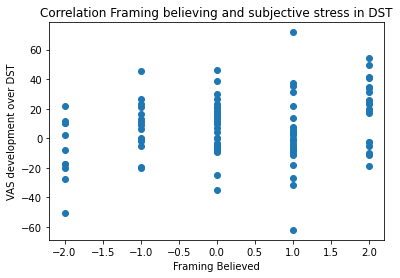

Scipy Pearson Korrelationskoeffizient und p-value: (-0.042299849743053404, 0.6713854469675796)
Scipy Spearman Korrelationskoeffizient und p-value: SpearmanrResult(correlation=-0.12072763914781626, pvalue=0.22446250875165014)


In [277]:
# only DST studies here

plt.scatter(x = meta_completed_dst["SS02"][meta_completed_dst["SS02"].notna()], y = meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["SS02"].notna()])
plt.xlabel("Framing Believed")
plt.ylabel("VAS development over DST")
plt.title("Correlation Framing believing and subjective stress in DST")
plt.show()

#print("Pearson - Korrelation mit Pandas:", (meta_completed_dst[["Speaking Percentage Total","VAS_mean_post_intermediate"]].corr(method = "pearson")))

print("Scipy Pearson Korrelationskoeffizient und p-value:", scipy.stats.pearsonr(x = meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()], y = meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()]))
np.corrcoef(meta_completed_dst["SS02"][meta_completed_dst["SS02"].notna()], meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["SS02"].notna()])
print("Scipy Spearman Korrelationskoeffizient und p-value:", scipy.stats.spearmanr(meta_completed_dst["Speaking Percentage Total"][meta_completed_dst["Speaking Percentage Total"].notna()],meta_completed_dst["VAS_mean_post_intermediate"][meta_completed_dst["Speaking Percentage Total"].notna()]))


## Correlation between VAS and PANAS 

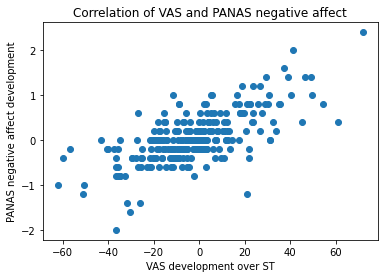

[[1.         0.67540052]
 [0.67540052 1.        ]]


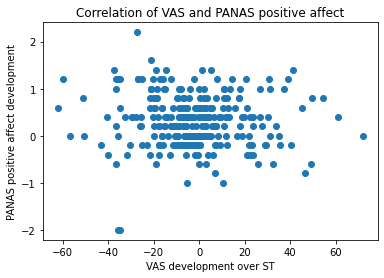

[[ 1.         -0.06274173]
 [-0.06274173  1.        ]]


In [278]:
# check correlations of different subjective stress markers for all studies
    # for negative affect
plt.scatter(x = meta_completed["VAS_mean_post_pre"], y = meta_completed["PANAS_NEG_post_pre"])
plt.xlabel("VAS development over ST")
plt.ylabel("PANAS negative affect development")
plt.title("Correlation of VAS and PANAS negative affect")
plt.show()

print(np.corrcoef(meta_completed["VAS_mean_post_pre"], meta_completed["PANAS_NEG_post_pre"]))
 
    # for positive affect
plt.scatter(x = meta_completed["VAS_mean_post_pre"], y = meta_completed["PANAS_POS_post_pre"])
plt.xlabel("VAS development over ST")
plt.ylabel("PANAS positive affect development")
plt.title("Correlation of VAS and PANAS positive affect")
plt.show()

print(np.corrcoef(meta_completed["VAS_mean_post_pre"], meta_completed["PANAS_POS_post_pre"]))

## Analysis of Stress Elements in the Post-hoc Online - Questionnaires


In [279]:
# change columns to label names for better finding of VAS, likert scales which start with "Stress" or "Usability"

complete_data = meta_completed[sosci_analysis_cols] 
DST_data = complete_data[complete_data["QUESTNNR"] == "DST_komplett_neu15102020"].reset_index(drop = True)
CDST_data = complete_data[complete_data["QUESTNNR"] == "C-DST"].reset_index(drop = True)

complete_data.columns = sosci_labels
DST_data.columns = sosci_labels
CDST_data.columns = sosci_labels

In [280]:
## calculate the means of likert-scales and VAS
# likert-scales range from -2 to +2, i.e. a positive value indicates more agreement

dict_complete = {}
dict_dst = {}
dict_cdst = {}
verbal_feedback = []

# change columns to label names for better finding of VAS, likert scales which start with "Stress" or "Usability"

for col in complete_data.columns:
    if col.startswith("Stress") or col.startswith("Usability") or col.startswith("Zusätzliche"):
            try:
                dict_complete[col + " MEAN"] = np.mean(complete_data[col].astype(float))
                dict_complete[col + " STD"] = np.std(complete_data[col].astype(float))
                dict_dst[col + " MEAN"] = np.mean (DST_data[col].astype(float))
                dict_dst[col + " STD"] = np.std(DST_data[col].astype(float))
                dict_cdst[col + " MEAN"] = np.mean(CDST_data[col].astype(float))
                dict_cdst[col + " STD"] = np.std(CDST_data[col].astype(float))

            
            except:
                for elem in complete_data[col]:
                    if str(elem) != "nan":
                        verbal_feedback.append(elem)
            
    if col == "PSS4 Sum":
            dict_complete[col] = (complete_data[col].astype(float).sum() / (complete_data[col]).notnull().sum())
            dict_dst[col] = (DST_data[col].astype(float).sum() / (DST_data[col]).notnull().sum())
            dict_cdst[col] = (CDST_data[col].astype(float).sum() / (CDST_data[col]).notnull().sum())
    
    if col == "RS_sum_german":
            dict_complete[col] = (complete_data[col].astype(float).sum() / (complete_data[col]).notnull().sum())
            dict_dst[col] = (DST_data[col].astype(float).sum() / (DST_data[col]).notnull().sum())
            dict_cdst[col] = (CDST_data[col].astype(float).sum() / (CDST_data[col]).notnull().sum())
            
    if col == "RS_sum_english":
            dict_complete[col] = (complete_data[col].astype(float).sum() / (complete_data[col]).notnull().sum())
            dict_dst[col] = (DST_data[col].astype(float).sum() / (DST_data[col]).notnull().sum())
            dict_cdst[col] = (CDST_data[col].astype(float).sum() / (CDST_data[col]).notnull().sum())            
            
        

scale_means = pd.DataFrame([dict_complete]).append(pd.DataFrame([dict_dst]), ignore_index = True).append(pd.DataFrame([dict_cdst]), ignore_index = True)



pd.set_option("display.max_rows", None, "display.max_columns", None)
scale_means.index = ["Total", "DST", "C-DST"]

display(scale_means)

/tmp/ipykernel_20712/423857104.py:40: RuntimeWarning: invalid value encountered in double_scalars
  dict_cdst[col] = (CDST_data[col].astype(float).sum() / (CDST_data[col]).notnull().sum())
/tmp/ipykernel_20712/423857104.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scale_means = pd.DataFrame([dict_complete]).append(pd.DataFrame([dict_dst]), ignore_index = True).append(pd.DataFrame([dict_cdst]), ignore_index = True)
/tmp/ipykernel_20712/423857104.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scale_means = pd.DataFrame([dict_complete]).append(pd.DataFrame([dict_dst]), ignore_index = True).append(pd.DataFrame([dict_cdst]), ignore_index = True)


Usability2 Testvideo erkennbar MEAN  \
Total                             1.960396   
DST                               1.960396   
C-DST                                  NaN   

       Usability2 Testvideo erkennbar STD  \
Total                             0.39604   
DST                               0.39604   
C-DST                                 NaN   

       Usability5_Gesicht erkennbar gesamte Zeit MEAN  \
Total                                        1.623762   
DST                                          1.623762   
C-DST                                             NaN   

       Usability5_Gesicht erkennbar gesamte Zeit STD  Usability2_VAS MEAN  \
Total                                        0.79418                  2.0   
DST                                          0.79418                  2.0   
C-DST                                            NaN                  2.0   

       Usability2_VAS STD  Usability5_Texte MEAN  Usability5_Texte STD  \
Total                 0.0               1.487365              0.856502   
DST                   0.0               1.168317              1.005621   
C-DST                 0.0               1.670455              0.694485   

       Usability5_Texte: trifft nicht zu MEAN  \
Total                                     NaN   
DST                                       NaN   
C-DST                                     NaN   

       Usability5_Texte: trifft nicht zu STD  Usability5_Dauer MEAN  \
Total                                    NaN              -1.620939   
DST                                      NaN              -1.613861   
C-DST                                    NaN              -1.625000   

       Usability5_Dauer STD  Usability_Schwierigkeit C-DST MEAN  \
Total              0.698628                           -0.539773   
DST                0.808008                                 NaN   
C-DST              0.627269                           -0.539773   

       Usability_Schwierigkeit C-DST STD  Usability5_SchwierigkeitDST MEAN  \
Total                           1.021701                          0.544554   
DST                                  NaN                          0.544554   
C-DST                           1.021701                               NaN   

       Usability5_SchwierigkeitDST STD  Usability5_Debriefing MEAN  \
Total                          1.01985                    0.967509   
DST                            1.01985                    1.485149   
C-DST                              NaN                    0.670455   

       Usability5_Debriefing STD  Usability2_Audio-Visualisierung Speech MEAN  \
Total                   1.082695                                     1.362963   
DST                     0.752736                                     1.680000   
C-DST                   1.130382                                     1.176471   

       Usability2_Audio-Visualisierung Speech STD  \
Total                                    1.463671   
DST                                      1.085173   
C-DST                                    1.617380   

       Usability2_Audio-Visualisierung falsches Feedback MEAN  \
Total                                          -1.498155        
DST                                            -1.387755        
C-DST                                          -1.560694        

       Usability2_Audio-Visualisierung falsches Feedback STD  \
Total                                           1.324965       
DST                                             1.440186       
C-DST                                           1.250694       

       Usability5_Framing_Performance-Test_glaubhaft MEAN  \
Total                                           0.083032    
DST                                             0.277228    
C-DST                                          -0.028409    

       Usability5_Framing_Performance-Test_glaubhaft STD  \
Total                                           1.320609   
DST                                     

## Correlations of Trait Markers (PSS4 and RSS-13) and the stress reactivity (VAS increase) in DST

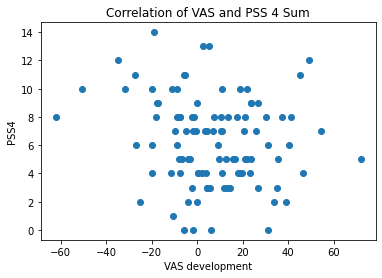

[[ 1.         -0.16771458]
 [-0.16771458  1.        ]]
N for correlation-analysis: 101
Pearson - Korrelation mit Pandas:


VAS_mean_post_pre  PSS4 Sum
VAS_mean_post_pre           1.000000 -0.167715
PSS4 Sum                   -0.167715  1.000000

Scipy Pearson Korrelationskoeffizient und p-value:


(-0.16771457644397145, 0.09365452092966622)

Scipy Spearman Korrelationskoeffizient und p-value:


SpearmanrResult(correlation=-0.15946147552904863, pvalue=0.11119821708428457)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


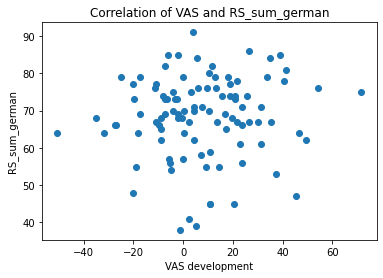

N for correlation-analysis: 100
[[1.         0.06816223]
 [0.06816223 1.        ]]
Pearson - Korrelation mit Pandas:


VAS_mean_post_pre  RS_sum_german
VAS_mean_post_pre           1.000000       0.068162
RS_sum_german               0.068162       1.000000

Scipy Pearson Korrelationskoeffizient und p-value:


(0.06816222952427183, 0.5004149977354734)

Scipy Spearman Korrelationskoeffizient und p-value:


SpearmanrResult(correlation=0.08014596799555566, pvalue=0.4279761755357693)

In [281]:
plt.scatter(x = meta_completed_dst["VAS_mean_post_pre"], y = meta_completed_dst["PSS4 Sum"])
plt.xlabel("VAS development")
plt.ylabel("PSS4")
plt.title("Correlation of VAS and PSS 4 Sum")
plt.show()

print(np.corrcoef(x = meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["PSS4 Sum"].notna()], y = meta_completed_dst["PSS4 Sum"][meta_completed_dst["PSS4 Sum"].notna()]))
print("N for correlation-analysis:", meta_completed_dst["PSS4 Sum"].notna().sum())
print("Pearson - Korrelation mit Pandas:")
display(meta_completed_dst[["VAS_mean_post_pre", "PSS4 Sum"]].corr(method = "pearson"))

print("Scipy Pearson Korrelationskoeffizient und p-value:")
display(scipy.stats.pearsonr(x = meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["PSS4 Sum"].notna()], y = meta_completed_dst["PSS4 Sum"][meta_completed_dst["PSS4 Sum"].notna()]))
print("Scipy Spearman Korrelationskoeffizient und p-value:")
display(scipy.stats.spearmanr(meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["PSS4 Sum"].notna()],meta_completed_dst["PSS4 Sum"][meta_completed_dst["PSS4 Sum"].notna()]))

print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
plt.scatter(x = meta_completed_dst["VAS_mean_post_pre"], y = meta_completed_dst["RS_sum_german"])
plt.xlabel("VAS development")
plt.ylabel("RS_sum_german")
plt.title("Correlation of VAS and RS_sum_german")
plt.show()
print("N for correlation-analysis:", meta_completed_dst["RS_sum_german"].notna().sum())
print(np.corrcoef(x = meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["RS_sum_german"].notna()], y = meta_completed_dst["RS_sum_german"][meta_completed_dst["RS_sum_german"].notna()]))
print("Pearson - Korrelation mit Pandas:")
display(meta_completed_dst[["VAS_mean_post_pre", "RS_sum_german"]].corr(method = "pearson"))

print("Scipy Pearson Korrelationskoeffizient und p-value:")
display(scipy.stats.pearsonr(x = meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["RS_sum_german"].notna()], y = meta_completed_dst["RS_sum_german"][meta_completed_dst["RS_sum_german"].notna()]))
print("Scipy Spearman Korrelationskoeffizient und p-value:")
scipy.stats.spearmanr(meta_completed_dst["VAS_mean_post_pre"][meta_completed_dst["RS_sum_german"].notna()],meta_completed_dst["RS_sum_german"][meta_completed_dst["RS_sum_german"].notna()])


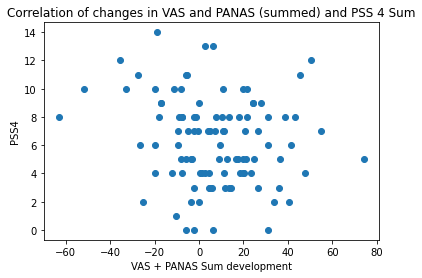

[[ 1.         -0.16567543]
 [-0.16567543  1.        ]]
Pearson - Korrelation mit Pandas:


PANAS_VAS_post_pre  PSS4 Sum
PANAS_VAS_post_pre            1.000000 -0.165675
PSS4 Sum                     -0.165675  1.000000

Scipy Pearson Korrelationskoeffizient und p-value:


(-0.16567542531937482, 0.09777120451739496)

In [282]:
plt.scatter(x = meta_completed_dst["PANAS_VAS_post_pre"], y = meta_completed_dst["PSS4 Sum"])
plt.xlabel("VAS + PANAS Sum development")
plt.ylabel("PSS4")
plt.title("Correlation of changes in VAS and PANAS (summed) and PSS 4 Sum")
plt.show()

print(np.corrcoef(x = meta_completed_dst["PANAS_VAS_post_pre"][meta_completed_dst["PSS4 Sum"].notna()], y = meta_completed_dst["PSS4 Sum"][meta_completed_dst["PSS4 Sum"].notna()]))
print("Pearson - Korrelation mit Pandas:")
display(meta_completed_dst[["PANAS_VAS_post_pre", "PSS4 Sum"]].corr(method = "pearson"))

print("Scipy Pearson Korrelationskoeffizient und p-value:")
display(scipy.stats.pearsonr(x = meta_completed_dst["PANAS_VAS_post_pre"][meta_completed_dst["PSS4 Sum"].notna()], y = meta_completed_dst["PSS4 Sum"][meta_completed_dst["PSS4 Sum"].notna()]))

## Logistic Regression for prediction of DST vs. C-DST using the VAS features


In [283]:
# for different feature selections change here
features_selected = ["VAS_stress_post_pre","VAS_ashamed_post_pre","VAS_frustrated_post_pre","VAS_overstrained_post_pre"]

# put label at first place
features_selected.insert(0, "Condition")
data = meta_completed[features_selected]
data["Condition"] = data["Condition"].replace(["C-DST","DST"], [0 , 1])

X = data.loc[:,features_selected[1]:]
y = np.ravel(data[["Condition"]])

# with SciKit
clf = LogisticRegression(C=1e9, fit_intercept=False)

# produce train and test data (conservative way)
# train_x, test_x, train_y, test_y = train_test_split(X,y)
# run model for whole data, i.e. no training/test for comparing with statistical approach
clf.fit(X, y)

coef = pd.DataFrame({'features': X.columns, 
                     'coef': clf.coef_[0], 
                     'odds_ratio': np.exp(clf.coef_[0])})

display(coef)

# with SciKit:

logit = sm.Logit(y, X)
logit_res = logit.fit()

logit_res.summary()

/tmp/ipykernel_20712/2019397587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Condition"] = data["Condition"].replace(["C-DST","DST"], [0 , 1])


features      coef  odds_ratio
0        VAS_stress_post_pre  0.012088    1.012161
1       VAS_ashamed_post_pre  0.007367    1.007395
2    VAS_frustrated_post_pre  0.013290    1.013379
3  VAS_overstrained_post_pre  0.011293    1.011357

Optimization terminated successfully.
         Current function value: 0.612461
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  284
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                 0.06486
Time:                        09:40:36   Log-Likelihood:                -173.94
converged:                       True   LL-Null:                       -186.00
Covariance Type:            nonrobust   LLR p-value:                 2.347e-05
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
VAS_stress_post_pre           0.0121      0.006      1.866      0.062      -0.001       0.025
VAS_ashamed_post_pre          0.0074      0.006      1.254      0.210      -0.004       0.019
VAS_frustrated_post_pre       0.0133      0.005      2.455      0.014       0.003       0.024
VAS_overstrained_post_pre     0.0113      0.007      1.660      0.097      -0.002       0.025
=============================================================================================
"""

## ANCOVAs & Regressions

In [284]:
# ANCOVA for groups (DST vs. C-DST) and PANAS - means with baseline covariate USING PINGOUIN

# prepare dataframe 

ancova_df = meta_completed[["Subject ID", "PANAS_NEG_post", "Condition", "PANAS_NEG_pre"]] \
    .melt(id_vars=['Subject ID', "Condition", "PANAS_NEG_post"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

ancova_df.rename(columns = {"value": "PANAS_NEG_pre"}, inplace = True)
#display(ancova_df)

# Compute the two-way mixed-design ANOVA with pingouin (mixed ANOVAs not fully implemented in statsmodels, i.e.
## if there is more than one measuremeant)
acov = pg.ancova(dv='PANAS_NEG_post', covar = 'PANAS_NEG_pre', between='Condition', data=ancova_df)




print("This is for NEGATIVE affect using Pingouin:")
display(acov)


print("---------------------------------------------------")
################################################################################################################

# here we evaluate using ANCOVA with the baseline measurement as a covariate using statsmodels regression

ancova_df = meta_completed[["Subject ID", "PANAS_NEG_post", "Condition", "PANAS_NEG_pre"]] \
    .melt(id_vars=['Subject ID', "Condition", "PANAS_NEG_post"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

ancova_df.rename(columns = {"value": "PANAS_NEG_pre"}, inplace = True)

reg = smf.ols("PANAS_NEG_post ~ Condition + PANAS_NEG_pre", data = ancova_df).fit()
ancova2 = sm.stats.anova_lm(reg, type = 2)
print("This is for NEGATIVE affect using Statsmodels regression, i.e. ANCOVA:")
display(reg.summary()) 

# multiple comparison posthoc now:

#mc = pairwise_tukeyhsd(ancova_df["PANAS_NEG_post"], ancova_df["Condition"], alpha = 0.05)

print("-----------------")


print("---------------------------------------------------")
################################################################################################################

print("Now with fitting a linear mixed model, i.e. same results as linear regression and ANCOVA")
data = meta_completed[["Subject ID", "Condition", "PANAS_NEG_post", "PANAS_NEG_pre"]]  \
    .melt(id_vars=['Subject ID', "Condition", "PANAS_NEG_pre"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

#display(data)
data.rename(columns = {"value":"PANAS_NEG_post", "Subject ID": "ID"}, inplace = True)
#data.replace(["VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"],[0.0, 1.0, 2.0], inplace = True)


model = smf.mixedlm("PANAS_NEG_post ~ Condition + PANAS_NEG_pre" , data, groups = data["ID"])
result = model.fit()
display(result.summary())

This is for NEGATIVE affect using Pingouin:


Source         SS   DF           F         p-unc       np2
0      Condition   8.121690    1   33.247576  2.134820e-08  0.105801
1  PANAS_NEG_pre  54.285529    1  222.227422  1.986636e-37  0.441604
2       Residual  68.642446  281         NaN           NaN       NaN

---------------------------------------------------
This is for NEGATIVE affect using Statsmodels regression, i.e. ANCOVA:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PANAS_NEG_post   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     127.1
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           4.87e-40
Time:                        09:40:36   Log-Likelihood:                -201.33
No. Observations:                 284   AIC:                             408.7
Df Residuals:                     281   BIC:                             419.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2905      0.089      3.276      0.001       0.116       0.465
Condition[T.DST]     0.3518      0.061      5.766      0.000       0.232       0.472
PANAS_NEG_pre        0.7627      0.051     14.907      0.000       0.662       0.863
==============================================================================
Omnibus:                       36.523   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.760
Skew:                           0.664   Prob(JB):                     3.54e-17
Kurtosis:                       5.153   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----------------
---------------------------------------------------
Now with fitting a linear mixed model, i.e. same results as linear regression and ANCOVA


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: PANAS_NEG_post
No. Observations: 284     Method:             REML          
No. Groups:       284     Scale:              0.1221        
Min. group size:  1       Log-Likelihood:     -207.8796     
Max. group size:  1       Converged:          Yes           
Mean group size:  1.0                                       
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.291    0.024 12.063 0.000  0.243  0.338
Condition[T.DST]   0.352    0.061  5.801 0.000  0.233  0.471
PANAS_NEG_pre      0.763    0.008 97.754 0.000  0.747  0.778
Group Var          0.122                                    
============================================================

"""

In [285]:
# here we evaluate using regression with the TIME as a covariate using statsmodels regression

ancova_df = meta_completed[["Subject ID", "Condition", "VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

ancova_df.rename(columns = {"value": "Score", "variable": "TIME"}, inplace = True)


display(ancova_df)

reg = smf.ols("Score ~ Condition + TIME", data = ancova_df).fit()
ancova2 = sm.stats.anova_lm(reg, type = 2)
display(ancova2) 

Subject ID Condition                   TIME   Score
0        4966.0     C-DST           VAS_pre_mean   24.50
1        4966.0     C-DST  VAS_intermediate_mean   32.25
2        4966.0     C-DST          VAS_post_mean   31.25
3        4974.0       DST           VAS_pre_mean   18.50
4        4974.0       DST  VAS_intermediate_mean   62.50
5        4974.0       DST          VAS_post_mean   59.75
6        4980.0       DST           VAS_pre_mean   39.75
7        4980.0       DST  VAS_intermediate_mean   45.00
8        4980.0       DST          VAS_post_mean   34.75
9        5000.0     C-DST           VAS_pre_mean   18.50
10       5000.0     C-DST  VAS_intermediate_mean   24.25
11       5000.0     C-DST          VAS_post_mean    6.00
12       5001.0     C-DST           VAS_pre_mean   22.00
13       5001.0     C-DST  VAS_intermediate_mean   15.50
14       5001.0     C-DST          VAS_post_mean   23.75
15       5012.0     C-DST  VAS_intermediate_mean   75.00
16       5012.0     C-DST          VAS_post_mean   25.00
17       5012.0     C-DST           VAS_pre_mean   33.75
18       5043.0     C-DST          VAS_post_mean    2.50
19       5043.0     C-DST           VAS_pre_mean   20.25
20       5043.0     C-DST  VAS_intermediate_mean   11.25
21       5077.0     C-DST          VAS_post_mean    1.00
22       5077.0     C-DST           VAS_pre_mean    0.00
23       5077.0     C-DST  VAS_intermediate_mean   21.00
24       5093.0     C-DST          VAS_post_mean    7.75
25       5093.0     C-DST           VAS_pre_mean   33.75
26       5093.0     C-DST  VAS_intermediate_mean   34.00
27       5109.0       DST          VAS_post_mean   13.25
28       5109.0       DST  VAS_intermediate_mean   44.75
29       5109.0       DST           VAS_pre_mean   40.75
30       5113.0     C-DST  VAS_intermediate_mean   13.00
31       5113.0     C-DST          VAS_post_mean    2.75
32       5113.0     C-DST           VAS_pre_mean   20.50
33       5123.0       DST  VAS_intermediate_mean   32.25
34       5123.0       DST          VAS_post_mean   46.00
35       5123.0       DST           VAS_pre_mean   51.75
36       5142.0     C-DST  VAS_intermediate_mean   17.25
37       5142.0     C-DST          VAS_post_mean   18.00
38       5142.0     C-DST           VAS_pre_mean   54.75
39       5169.0       DST  VAS_intermediate_mean   63.75
40       5169.0       DST          VAS_post_mean   61.50
41       5169.0       DST           VAS_pre_mean   56.25
42       5173.0     C-DST          VAS_post_mean   17.00
43       5173.0     C-DST           VAS_pre_mean   31.75
44       5173.0     C-DST  VAS_intermediate_mean   47.00
45       5191.0     C-DST           VAS_pre_mean    0.00
46       5191.0     C-DST  VAS_intermediate_mean    2.75
47       5191.0     C-DST          VAS_post_mean    0.00
48       5193.0     C-DST           VAS_pre_mean    0.00
49       5193.0     C-DST  VAS_intermediate_mean   31.75
50       5193.0     C-DST          VAS_post_mean    0.00
51       5194.0     C-DST           VAS_pre_mean   19.50
52       5194.0     C-DST  VAS_intermediate_mean   27.75
53       5194.0     C-DST          VAS_post_mean    1.75
54       5199.0     C-DST  VAS_intermediate_mean   12.75
55       5199.0     C-DST          VAS_post_mean    0.00
56       5199.0     C-DST           VAS_pre_mean    7.00
57       5200.0       DST          VAS_post_mean    0.00
58       5200.0       DST           VAS_pre_mean    8.00
59       5200.0       DST  VAS_intermediate_mean    0.00
60       5214.0     C-DST          VAS_post_mean   10.25
61       5214.0     C-DST           VAS_pre_mean   18.25
62       5214.0     C-DST  VAS_intermediate_mean   14.25
63       5219.0     C-DST          VAS_post_mean   14.25
64       5219.0     C-DST           VAS_pre_mean   39.75
65       5219.0     C-DST  VAS_intermediate_mean   53.50
66       5221.0     C-DST          VAS_post_mean    4.25
67       5221.0     C-DST           VAS_pre_mean    2.00
68       5221.0     C-DST  VAS_intermediate_mean   42.75
69       5222.0

df         sum_sq       mean_sq          F        PR(>F)
Condition    1.0   22298.890342  22298.890342  53.176957  6.994033e-13
TIME         2.0   22396.040493  11198.020246  26.704317  5.662844e-12
Residual   848.0  355594.977836    419.333700        NaN           NaN

Now let's do ANOVA with the changes of the scores regarding the baselines, i.e. general stress effect vs. speech effect.

In [286]:
anova_df = meta_completed[["Subject ID", "Condition", "VAS_mean_post_intermediate", "VAS_mean_intermediate_pre"]] \
    .melt(id_vars=['Subject ID', "Condition"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

anova_df.rename(columns = {"value": "VAS Score", "variable": "VAS changes"}, inplace = True)

aov = pg.mixed_anova(dv='VAS Score', within='VAS changes', between='Condition', 
                     subject='Subject ID', data=anova_df)

posthocs = pg.pairwise_ttests(dv='VAS Score', within='VAS changes',
                              between='Condition', subject='Subject ID', data=anova_df)

display(aov)
display(posthocs)

/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()


Source            SS  DF1  DF2            MS           F  \
0    Condition   7366.253098    1  282   7366.253098   41.465338   
1  VAS changes  63824.720070    1  282  63824.720070  129.615366   
2  Interaction  13970.756275    1  282  13970.756275   28.371839   

          p-unc       np2  eps  
0  5.153105e-10  0.128191  NaN  
1  5.833021e-25  0.314894  1.0  
2  2.049198e-07  0.091412  NaN

Contrast                 VAS changes  \
0              VAS changes                           -   
1                Condition                           -   
2  VAS changes * Condition   VAS_mean_intermediate_pre   
3  VAS changes * Condition  VAS_mean_post_intermediate   

                           A                           B Paired  Parametric  \
0  VAS_mean_intermediate_pre  VAS_mean_post_intermediate   True        True   
1                      C-DST                         DST  False        True   
2                      C-DST                         DST  False        True   
3                      C-DST                         DST  False        True   

           T         dof alternative         p-unc       BF10    hedges  
0  10.871271  283.000000   two-sided  3.104983e-23  1.217e+20  1.098418  
1  -6.031024  173.980183   two-sided  9.522080e-09  1.914e+06 -0.792659  
2  -6.755094  164.205856   two-sided  2.357766e-10   9.76e+07 -0.905445  
3   1.276656  177.117830   two-sided  2.033949e-01      0.293  0.166790

## Linear mixed models

In [287]:
data = meta_completed[["Subject ID", "Condition", "VAS_pre_mean", "VAS_post_mean"]]  \
    .melt(id_vars=['Subject ID', "Condition", "VAS_pre_mean"]) \
    .sort_values(by = "Subject ID") \
    .reset_index(drop = True)

#display(data)
data.rename(columns = {"value":"VAS_post_mean", "Subject ID": "ID"}, inplace = True)
#data.replace(["VAS_pre_mean", "VAS_intermediate_mean", "VAS_post_mean"],[0.0, 1.0, 2.0], inplace = True)


model = smf.mixedlm("VAS_post_mean ~ Condition + VAS_pre_mean" , data, groups = data["ID"])
result = model.fit()
display(result.summary())


/opt/anaconda3/envs/mnorden_sit/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM Dependent Variable: VAS_post_mean
No. Observations:  284     Method:             REML         
No. Groups:        284     Scale:              148.6500     
Min. group size:   1       Log-Likelihood:     -1209.5167   
Max. group size:   1       Converged:          Yes          
Mean group size:   1.0                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          1.524    1.087  1.402 0.161 -0.607  3.655
Condition[T.DST]  14.865    2.118  7.017 0.000 10.713 19.017
VAS_pre_mean       0.596    0.046 12.959 0.000  0.506  0.686
Group Var        148.650                                    
============================================================

"""

## Additional TSST vs. DST analyses 

In [288]:
# first we do a normal Welch's t-test for both affect subscales:
for counter,tsst_panas in enumerate(tsst_panas_list):
    print("This is for:", names[counter])
    print("Welch's t-TEST for PANAS positive affect change:")
    t_test = pg.ttest(meta_completed_dst["PANAS_POS_post_pre"], 
                      tsst_panas["PANAS_POS_post_pre"], correction = True)
    t_test_table = t_test.style.set_caption("T-Test for PANAS_POS_post_pre")
    display(meta_completed_dst["PANAS_POS_post_pre"].describe(), tsst_panas["PANAS_POS_post_pre"].describe())
    display(t_test_table)

    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")


    print("Welch's t-TEST for PANAS negative affect change:")

    t_test = pg.ttest(meta_completed_dst["PANAS_NEG_post_pre"], 
                      tsst_panas["PANAS_NEG_post_pre"], correction = True)
    t_test_table = t_test.style.set_caption("T-Test for PANAS_NEG_post_pre")
    display(meta_completed_dst["PANAS_NEG_post_pre"].describe(), tsst_panas["PANAS_NEG_post_pre"].describe())
    display(t_test_table)

    print("TOST-Results:")  
    print("First row is final p-value for non-equivalence-test")
    print("The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)")
    print("Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)")
    display(smws.ttost_ind(x1 = meta_completed_dst["PANAS_NEG_post_pre"] ,
                           x2 = tsst_panas["PANAS_NEG_post_pre"], 
                           low = -0.2, upp = +0.20, usevar="unequal"))


This is for: Herten1
Welch's t-TEST for PANAS positive affect change:


count    103.000000
mean       0.289320
std        0.606971
min       -2.000000
25%       -0.100000
50%        0.200000
75%        0.600000
max        2.200000
Name: PANAS_POS_post_pre, dtype: float64

count    26.000000
mean     -0.011538
std       0.514064
min      -0.800000
25%      -0.300000
50%       0.000000
75%       0.275000
max       1.400000
Name: PANAS_POS_post_pre, dtype: float64

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Welch's t-TEST for PANAS negative affect change:


count    103.000000
mean       0.269903
std        0.607605
min       -1.400000
25%        0.000000
50%        0.200000
75%        0.600000
max        2.400000
Name: PANAS_NEG_post_pre, dtype: float64

count    26.000000
mean      0.546154
std       0.683070
min      -0.400000
25%       0.100000
50%       0.300000
75%       0.875000
max       2.300000
Name: PANAS_NEG_post_pre, dtype: float64

TOST-Results:
First row is final p-value for non-equivalence-test
The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)
Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)


(0.69674529397503,
 (-0.5196662343739437, 0.69674529397503, 35.635493352484026),
 (-3.2457508096010144, 0.0012754754772511014, 35.635493352484026))

This is for: Herten2
Welch's t-TEST for PANAS positive affect change:


count    103.000000
mean       0.289320
std        0.606971
min       -2.000000
25%       -0.100000
50%        0.200000
75%        0.600000
max        2.200000
Name: PANAS_POS_post_pre, dtype: float64

count    26.000000
mean      0.015385
std       0.451391
min      -0.900000
25%      -0.300000
50%       0.100000
75%       0.300000
max       1.200000
Name: PANAS_POS_post_pre, dtype: float64

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Welch's t-TEST for PANAS negative affect change:


count    103.000000
mean       0.269903
std        0.607605
min       -1.400000
25%        0.000000
50%        0.200000
75%        0.600000
max        2.400000
Name: PANAS_NEG_post_pre, dtype: float64

count    26.000000
mean      0.323077
std       0.439370
min      -0.200000
25%       0.000000
50%       0.200000
75%       0.500000
max       1.400000
Name: PANAS_NEG_post_pre, dtype: float64

TOST-Results:
First row is final p-value for non-equivalence-test
The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)
Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)


(0.08382321303957842,
 (1.3993486074786325, 0.08382321303957842, 51.99348709064306),
 (-2.4129154523665144, 0.009693328543347925, 51.99348709064306))

This is for: Herten3
Welch's t-TEST for PANAS positive affect change:


count    103.000000
mean       0.289320
std        0.606971
min       -2.000000
25%       -0.100000
50%        0.200000
75%        0.600000
max        2.200000
Name: PANAS_POS_post_pre, dtype: float64

count    20.000000
mean      0.270000
std       0.824046
min      -2.800000
25%       0.225000
50%       0.450000
75%       0.600000
max       1.100000
Name: PANAS_POS_post_pre, dtype: float64

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Welch's t-TEST for PANAS negative affect change:


count    103.000000
mean       0.269903
std        0.607605
min       -1.400000
25%        0.000000
50%        0.200000
75%        0.600000
max        2.400000
Name: PANAS_NEG_post_pre, dtype: float64

count    20.000000
mean      0.155000
std       0.680151
min      -1.500000
25%      -0.025000
50%       0.100000
75%       0.300000
max       1.700000
Name: PANAS_NEG_post_pre, dtype: float64

TOST-Results:
First row is final p-value for non-equivalence-test
The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)
Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)


(0.30357705530815443,
 (1.926649018924592, 0.032678935832218724, 25.231929328488164),
 (-0.5206437074417779, 0.30357705530815443, 25.231929328488164))

This is for: OTW_HD
Welch's t-TEST for PANAS positive affect change:


count    103.000000
mean       0.289320
std        0.606971
min       -2.000000
25%       -0.100000
50%        0.200000
75%        0.600000
max        2.200000
Name: PANAS_POS_post_pre, dtype: float64

count    50.000000
mean     -0.138889
std       0.467267
min      -1.000000
25%      -0.500000
50%      -0.200000
75%       0.088889
max       1.100000
Name: PANAS_POS_post_pre, dtype: float64

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Welch's t-TEST for PANAS negative affect change:


count    103.000000
mean       0.269903
std        0.607605
min       -1.400000
25%        0.000000
50%        0.200000
75%        0.600000
max        2.400000
Name: PANAS_NEG_post_pre, dtype: float64

count    50.000000
mean      0.423556
std       0.531443
min      -0.500000
25%       0.041667
50%       0.300000
75%       0.800000
max       1.900000
Name: PANAS_NEG_post_pre, dtype: float64

TOST-Results:
First row is final p-value for non-equivalence-test
The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)
Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)


(0.3152621348775154,
 (0.48234174206277053, 0.3152621348775154, 109.6964795727657),
 (-3.6804996590375763, 0.00018134534444534973, 109.6964795727657))

This is for: Combined
Welch's t-TEST for PANAS positive affect change:


count    103.000000
mean       0.289320
std        0.606971
min       -2.000000
25%       -0.100000
50%        0.200000
75%        0.600000
max        2.200000
Name: PANAS_POS_post_pre, dtype: float64

count    122.000000
mean      -0.011840
std        0.558303
min       -2.800000
25%       -0.300000
50%        0.000000
75%        0.300000
max        1.400000
Name: PANAS_POS_post_pre, dtype: float64

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Welch's t-TEST for PANAS negative affect change:


count    103.000000
mean       0.269903
std        0.607605
min       -1.400000
25%        0.000000
50%        0.200000
75%        0.600000
max        2.400000
Name: PANAS_NEG_post_pre, dtype: float64

count    122.000000
mean       0.384244
std        0.582291
min       -1.500000
25%        0.000000
50%        0.300000
75%        0.700000
max        2.300000
Name: PANAS_NEG_post_pre, dtype: float64

TOST-Results:
First row is final p-value for non-equivalence-test
The null-hypothesis here is that there is a difference higher than defined as important in low and upp, so if we reject it, i.e. p<0.05, this means equivalence)
Second and third row are for lower and upper boarder respectively. Usually one reports the statistics for the bound with the bigger p-value as the outcome (i.e. this is then in the first row)


(0.1420623815317476,
 (1.0738010110173777, 0.1420623815317476, 213.36587319287966),
 (-3.9405144074083984, 5.508902692623831e-05, 213.36587319287966))